<a href="https://colab.research.google.com/github/rubygitflow/Glossary-extraction/blob/main/University_of_Artificial_Intelligence_Glossary_extraction_Outside_Test_2020_v_0_11_12_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Glossary extraction. The part-of-speech way. 
# Multiple Inputs: Lexemes, parts of speech, morphological features, alphabet.

https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/ 

**The research project**

В текущей версии: 
* добавлен блок с реализацией подгрузки данных из текстового файла и сегментации текста на предобученной сети (для проверки качества нейронной сети на новых текстах); 
* при обучениии нейронной сети отключена dice_coef метрика, чтобы обученную модель можно было прочитать с диска; 
* заполнение нулями коротких фраз в начале блока разммерностью sent_len (в pad_sequences); 
* добавлена модель PSPnet;
* увеличение обучающей базы; 
* возврат к 100%-му покрытию базы токенайзером.

# **Service data**

In [1]:
!nvidia-smi

Thu Dec 10 20:56:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Ссылки на файлы данных:

База_словарей_train_6.docx : https://drive.google.com/file/d/13QKXApDf8q8R_BYviX1J80BCJXUOlZUw/view?usp=sharing

База_словарей_test_6.docx : https://drive.google.com/file/d/19a1rOu6NuAb-Y_HrHhN7Ssg_ZvxTXHhH/view?usp=sharing

База_словарей_train_6.xml : https://drive.google.com/file/d/16lNQFww1QyYRxr8S4OsA2THypqxLQOra/view?usp=sharing

База_словарей_test_6.xml : https://drive.google.com/file/d/1-9fG7sdiZnjkarvitPYgX9PFt95eErPi/view?usp=sharing


In [2]:
color_meaning = {'00ffff':'термин', 'ffff00':'связка', '00ff00':'определение', 'd3d3d3':'расшифровка', 
                 'ff00ff':'дубль-термин', 'ff0000':'дубль-связка', '808000':'дубль-определение', '0000ff':'дубль-расшифровка',
                 'cyan':'термин','yellow':'связка','green':'определение', 'lightgray':'расшифровка',	                 
                 'magenta':'дубль-термин', 'red':'дубль-связка','darkyellow':'дубль-определение', 'blue':'дубль-расшифровка'}

                 #создаем словарь соответствий цвет-значение   

In [3]:
color_dic = {'термин':0,'связка':1,'определение':2,'расшифровка':3,
			       'дубль-термин':4,'дубль-связка':5,'дубль-определение':6,'дубль-расшифровка':7}
dic_color = {value:key for key, value in color_dic.items()}

zero_symbol = 'o'

colors_count = len(color_dic) + 1 # количество уникальных тегов (не забываем про тег отсутствия класса для разметки)

skip_amount = colors_count  # кол-во пропускаемых строк под легенду при считывании данных (здесь учитывается, что есть пусая строка, в списке тегов последнее значение используется под отсутствующий класс для разметки)

In [4]:
colors_count

9

In [5]:
# названия необходимых тегов для извлекаемых категорий
r = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}r'
rpr = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}rPr'
t = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}t'
shd = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}shd'
fill = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}fill'
highlight = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}highlight'
val = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}val'

In [6]:
''' 
  Словарь для цветовой разметки разобранного текста
'''
class color:
  GREY    = '\33[90m'
  RED2    = '\33[91m'
  GREEN2  = '\33[92m'
  YELLOW2 = '\33[93m'
  BLUE2   = '\33[94m'
  VIOLET2 = '\33[95m'
  LI_CYAN = '\33[96m'
  WHITE2  = '\33[97m'

  BLACK  = '\33[30m'
  RED    = '\33[31m'
  GREEN  = '\33[32m'
  YELLOW = '\33[33m'
  BLUE   = '\33[34m'
  VIOLET = '\33[35m'
  CYAN   = '\33[36m'
  WHITE  = '\33[37m'

  GREYBG    = '\33[100m'
  REDBG2    = '\33[101m'
  GREENBG2  = '\33[102m'
  YELLOWBG2 = '\33[103m'
  BLUEBG2   = '\33[104m'
  VIOLETBG2 = '\33[105m'
  LI_CYANBG = '\33[106m'
  WHITEBG2  = '\33[107m'

  BLACKBG  = '\33[40m'
  REDBG    = '\33[41m'
  GREENBG  = '\33[42m'
  YELLOWBG = '\33[43m'
  BLUEBG   = '\33[44m'
  VIOLETBG = '\33[45m'
  CYANBG   = '\33[46m'
  WHITEBG  = '\33[47m'


  BOLD 		  = '\33[1m'
  ITALIC 	  = '\33[3m'
  UNDERLINE = '\33[4m'

  BLINK    = '\33[5m'
  BLINK2   = '\33[6m'
  SELECTED = '\33[7m'
  END 		 = '\33[0m'
  
dic_colored_items = {0:color.LI_CYANBG+color.BLACK, 1:color.YELLOWBG2+color.BLACK, 2:color.GREENBG2+color.BLACK, 3:color.WHITEBG+color.BLACK,
			               4:color.VIOLETBG2+color.WHITE2, 5:color.REDBG2+color.WHITE2, 6:color.YELLOWBG+color.BLACK, 7:color.BLUEBG+color.WHITE2}

## Connecting libraries

In [7]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 3.4MB/s 
     |████████████████████████████████| 8.2MB 8.8MB/s 


In [8]:
!pip install polyglot
# https://github.com/aboSamoor/polyglot/issues/152
!pip install PyICU
!pip install pycld2
!pip install morfessor

     |████████████████████████████████| 133kB 7.4MB/s 
  Created wheel for polyglot: filename=polyglot-16.7.4-py2.py3-none-any.whl size=52558 sha256=93af670fa6992d12bff5269987e737ac827e428cce77de6da0a021072d58b2f8
  Stored in directory: /root/.cache/pip/wheels/5e/91/ef/f1369fdc1203b0a9347d4b24f149b83a305f39ab047986d9da
Successfully built polyglot
     |████████████████████████████████| 235kB 5.4MB/s 
  Created wheel for PyICU: filename=PyICU-2.6-cp36-cp36m-linux_x86_64.whl size=1288243 sha256=6dbdf4499e018883b3d6fa06fb7950cd1098e1dc05ce902a23bc4266b40bfffc
  Stored in directory: /root/.cache/pip/wheels/31/21/2f/1c91831e8a93537ab21f6b4b935781b681104635fdb0315791
Successfully built PyICU
     |████████████████████████████████| 41.4MB 72kB/s 
  Created wheel for pycld2: filename=pycld2-0.41-cp36-cp36m-linux_x86_64.whl size=9833517 sha256=4f0e84731d0e7fb89e98cc82cd34148e85b858c95160c8dc721f689ffa54deb7
  Stored in directory: /root/.cache/pip/wheels/c6/8f/e9/08a1a8932a490175bd140206cd86a3db

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model # Импортируем модели keras
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, concatenate, Activation, MaxPooling1D, Conv1D, concatenate  # Импортируем стандартные слои keras
from tensorflow.keras.layers import Dropout, BatchNormalization, Conv2DTranspose, Lambda, LSTM, GRU, Bidirectional, GlobalMaxPool1D # Импортируем стандартные слои keras
from tensorflow.keras.layers import SpatialDropout1D 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import load_model

from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt 
import collections
%matplotlib inline
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report # статистика точности предсказания по классам
import random
import datetime
import time

import xml.etree.ElementTree as ET

import re # https://habr.com/ru/post/349860/
import pymorphy2 # https://pymorphy2.readthedocs.io/en/latest/user/guide.html
import polyglot # https://polyglot.readthedocs.io/en/latest/
from polyglot.detect import Detector # https://polyglot.readthedocs.io/en/latest/Detection.html
from textblob import TextBlob # https://textblob.readthedocs.io/en/latest/quickstart.html
# import nltk
# from nltk import pos_tag # https://stackoverflow.com/questions/15388831/what-are-all-possible-pos-tags-of-nltk
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

import os # Импортируем библиотеку для работы с файловой системой
from google.colab import files # Импортируем Модуль для работы с файлами
from google.colab import drive # Подключаем гугл-диск

from sklearn.metrics import roc_curve, roc_auc_score

In [10]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [11]:
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
morph = pymorphy2.MorphAnalyzer()

In [13]:
all_tags_together = ['o термин связка определение расшифровка дубль-термин дубль-связка дубль-определение дубль-расшифровка']
tag_tokenizer = Tokenizer(filters=' ')
tag_tokenizer.fit_on_texts(all_tags_together)
tag_tokenizer.index_word

{1: 'o',
 2: 'термин',
 3: 'связка',
 4: 'определение',
 5: 'расшифровка',
 6: 'дубль-термин',
 7: 'дубль-связка',
 8: 'дубль-определение',
 9: 'дубль-расшифровка'}

In [14]:
# prepare color dictionary
tag_tokenizer_dic_color = {}
tag_tokenizer_dic_color[1] = color.END
for i in range(2,10):
  tag_tokenizer_dic_color[i] = dic_colored_items[color_dic[tag_tokenizer.index_word[i]]]
tag_tokenizer_dic_color

{1: '\x1b',
 2: '\x1b\x1b',
 3: '\x1b\x1b',
 4: '\x1b\x1b',
 5: '\x1b\x1b',
 6: '\x1b\x1b',
 7: '\x1b\x1b',
 8: '\x1b\x1b',
 9: '\x1b\x1b'}

## Library of local Functions

In [15]:
'''
  Сервиcная функция:
  Лемматизация для английского языка
  Функция предполагает разбор именно слов (без пробелов внутри текста - Это важно), 
  но лучшим оказался алгоритм лемматизации предложений
'''
# https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/
def textblob_lemmatize(blob):
  sent = TextBlob(blob)
  tag_dict = {"J": 'a', 
              "N": 'n', 
              "V": 'v', 
              "R": 'r'}
  words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
  lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
  res = "".join(lemmatized_list)
  return res if res!='' else blob

In [16]:
'''
  Сервиcная функция:
  Извлечение тега для лексемы на английском
  https://www.geeksforgeeks.org/python-part-of-speech-tagging-using-textblob/
  CC coordinating conjunction
  CD cardinal digit
  DT determiner
  EX existential there (like: “there is” … think of it like “there exists”)
  FW foreign word
  IN preposition/subordinating conjunction
  JJ adjective ‘big’
  JJR adjective, comparative ‘bigger’
  JJS adjective, superlative ‘biggest’
  LS list marker 1)
  MD modal could, will
  NN noun, singular ‘desk’
  NNS noun plural ‘desks’
  NNP proper noun, singular ‘Harrison’
  NNPS proper noun, plural ‘Americans’
  PDT predeterminer ‘all the kids’
  POS possessive ending parent‘s
  PRP personal pronoun I, he, she
  PRP$ possessive pronoun my, his, hers
  RB adverb very, silently,
  RBR adverb, comparative better
  RBS adverb, superlative best
  RP particle give up
  TO to go ‘to‘ the store.
  UH interjection errrrrrrrm
  VB verb, base form take
  VBD verb, past tense took
  VBG verb, gerund/present participle taking
  VBN verb, past participle taken
  VBP verb, sing. present, non-3d take
  VBZ verb, 3rd person sing. present takes
  WDT wh-determiner which
  WP wh-pronoun who, what
  WP$ possessive wh-pronoun whose
  WRB wh-abverb where, when

  https://pymorphy2.readthedocs.io/en/latest/user/grammemes.html#russian-numbers
  Граммема	Значение	          Примеры
  sing	    единственное число	хомяк, говорит
  plur	    множественное число	хомяки, говорят
'''
def textblob_tags(blob):
  # print('textblob_tags:',blob, TextBlob(blob).tags)
  try:
    pos = TextBlob(blob).tags[0][1]
    if pos in ['NN', 'NNP']:
      numbers = 'sing'
    elif pos in ['NNS', 'NNPS']:
      numbers = 'plur'
    else:
      numbers = 'None'
  except:
    pos = 'NN'
    numbers = 'sing'

  return pos, numbers

In [17]:
'''
  Сервиcная функция:
  Назначение граммемы
  https://pymorphy2.readthedocs.io/en/latest/user/grammemes.html
'''
def define_morphy( 
  pos = 'None', animacy = 'None', aspect = 'None',
  case = 'None', gender = 'None', involvement = 'None',
  mood = 'None', number = 'None', person = 'None',
  tense = 'None', transitivity = 'None', voice = 'None'
): 
  return [str(pos), str(animacy), str(aspect), str(case), str(gender), str(involvement), 
          str(mood), str(number), str(person), str(tense), str(transitivity), str(voice)]



In [18]:
'''
  Сервиcная функция:
  Извлечение морфологических признаков лексемы 
'''
def morphyus(blob):
  # 1. язык: долюно быть - sign, en, ru, el. Другие пока не расматриваются
  # 2. С заглавной ли буквы написание слова
  # итерации по
    # 3. слово в нормальной форме
    # 4. часть речи
    # 5. всё остальное

  draw_in = lambda a: ''.join(a.split())

  
  morphy = []  
  tags = morph.parse(blob)
  # print('tags',tags)
  try:
    detector = Detector(blob)
    language = detector.language.code
    # print('language',language)
  except:
    lng_lst = str(tags[0].tag).split(',')
    # print('lng_lst',lng_lst)
    if lng_lst[0]=='UNKN':
      morphy.append('sign')
      morphy.append('true' if blob[0].isupper() else 'false')
      morphy.append(textblob_lemmatize(blob).lower())
      pos, number = textblob_tags(blob)
      morphy += define_morphy(pos = pos, number = number)         
      return morphy
    elif lng_lst[0]=='LATN':
      morphy.append('en')
      morphy.append('true' if blob[0].isupper() else 'false')
      morphy.append(textblob_lemmatize(blob).lower())
      pos, number = textblob_tags(blob)
      morphy += define_morphy(pos = pos, number = number)  
      return morphy
    elif lng_lst[0]=='NUMB':
      morphy.append('sign')
      morphy.append('false')
      morphy.append(draw_in(tags[0].normal_form)) # allways .lower()
      morphy += define_morphy(pos = 'NUMB', number = lng_lst[1])  
      return morphy
    elif lng_lst[0]=='ROMN':
      morphy.append('en')
      morphy.append('true' if blob[0].isupper() else 'false')
      morphy.append(textblob_lemmatize(blob).lower())
      pos, number = textblob_tags(blob)
      morphy += define_morphy(pos = pos, number = number)  
      # print 'ROMN' morfology
      morphy.append(draw_in(tags[0].normal_form)) # allways .lower()
      morphy += define_morphy(pos = 'ROMN')
      return morphy
    elif lng_lst[0]=='PNCT':
      morphy.append('sign')
      morphy.append('false')
      morphy.append(draw_in(tags[0].normal_form)) # allways .lower()
      morphy += define_morphy(pos = 'PNCT')  
      return morphy
    elif lng_lst[0] in ['NOUN','ADJF','ADJS','COMP','VERB','INFN','PRTF','PRTS','GRND','NUMR','ADVB','NPRO','PRED','PREP','CONJ','PRCL','INTJ']:
      language = 'ru'
    else:
      language = lng_lst[0]

  # print('language:',language, '; blob:', blob)
  if language in ['bg', 'uk', 'mn', 'ab', 'ba', 'be', 'ky', 'mk', 'ro', 'ru', 'sr', 'tk', 'tt', 'ug', 'uz', 'ug']: 
  # на самом деле плохое условие. Надо менять алгоритм работы с детектором языка - detector.language
    language = 'ru'
    morphy.append('ru')
    morphy.append('true' if blob[0].isupper() else 'false')
    for elem in tags:
      morphy.append(elem.normal_form) # allways .lower()
      morphy += define_morphy(pos = elem.tag.POS,
                              animacy = elem.tag.animacy, 
                              aspect = elem.tag.aspect,
                              case = elem.tag.case, 
                              gender = elem.tag.gender, 
                              involvement = elem.tag.involvement,
                              mood = elem.tag.mood, 
                              number = elem.tag.number,
                              person = elem.tag.person,
                              tense = elem.tag.tense,
                              transitivity = elem.tag.transitivity,
                              voice = elem.tag.voice)
  else:
    # en - ak da de gl hu la mt nl sco sl sm 
    if language != 'el':
      language = 'en'
    morphy.append(language)
    morphy.append('true' if blob[0].isupper() else 'false')
    morphy.append(textblob_lemmatize(blob).lower())
    pos, number = textblob_tags(blob)
    morphy += define_morphy(pos = pos, number = number)  
    if str(tags[0].tag)=='ROMN':
      morphy.append(tags[0].normal_form)
      morphy += define_morphy(pos = 'ROMN')

  return morphy

In [19]:
'''
  Сервиcная функция:
  Загрузка выборки заданного количества фраз из файла 
'''
def load_xml(filename, paragraphs_amount):
    test_tree = ET.parse(filename)

    test_root = test_tree.getroot()
    test_body = test_root[0]
    test_row_count = paragraphs_amount + skip_amount
    return list(iter(test_body))[:test_row_count]

In [20]:
'''
  Сервиcная функция:
  Вставка пробела в заданной позиции в строке
'''
def insert_space(text, index):
  return text[:index] + ' ' + text[index:]

In [21]:
'''
  Основная функция для подготовки обучающей выборки.
  Создаём параллельные массивы с текстом — paragraphs,
  категориями лексем — tags
  и классификацией предложений — semantics
'''
def pars_xml(ps):
    # Массивы данных по параграфам
    paragraphs = []
    tags = []
    semantics = []
    exception_amount = 0
    exception_array = []
    # Массив фактических цветов в файле исходных данных
    colors = set() # все цвета в документе
    # длина массива лексем в параграфе
    max_paragraph_len = 0  # Максимальная длина предложения
    max_paragraph_len_ind = -1  # Индекс предложения с максимальной длиной

    for i, paragraph in enumerate(ps): # проходим по всем абзацам
        z_item = [0] # массив семантических индикаторов -  наличие определительной струткуры первого и второго уровня
        if i > colors_count - 1:     # пропускаем легенду для цветовой разметки    
            phrases_list = paragraph.findall(r) # находим все фразы (часть новости)
            p_words = [] # список сущностей в абзаце
            tags_w = [] # список семантических цветов для слов в абзаце

            last_ind = len(phrases_list)-1
            for ind, phrase in enumerate(phrases_list): # проходим по всем фразам в абзаце
                words = [] # список сущностей во фразе
                y_list = [] # категории для сущностей во фразе

                try:
                  text = phrase.find(t).text # получаем текст, содержащийся во фразе

                  # 1) выделяем пробелом точку (воскл.зн., вопр.зн., двоеточние) в конце предложения
                  text_comma = text.strip()
                  len_text = len(text_comma)-1
                  if ind==last_ind and len_text>0: 
                    if text_comma[len_text] in ['.', ':', '!', '?']:
                      text_comma = insert_space(text_comma, len_text)
                    
                  # 2) выделяем пробелами символы: , { } ( ) [ ] ; « » „ “ "
                  text_comma = text_comma.replace(',', ' , ')
                  text_comma = text_comma.replace('(', ' ( ')
                  text_comma = text_comma.replace(')', ' ) ')
                  text_comma = text_comma.replace('[', ' [ ')
                  text_comma = text_comma.replace(']', ' ] ')
                  text_comma = text_comma.replace('{', ' { ')
                  text_comma = text_comma.replace('}', ' } ')
                  text_comma = text_comma.replace('"', ' " ')
                  text_comma = text_comma.replace('„', ' „ ')
                  text_comma = text_comma.replace('“', ' “ ')
                  text_comma = text_comma.replace('«', ' « ')
                  text_comma = text_comma.replace('»', ' » ')
                  text_comma = text_comma.replace(';', ' ; ')
                  text_comma = text_comma.replace('%', ' %') # вставляем пробел именно слева, но не справа
                  text_comma = text_comma.replace('—', ' — ')
                  
            
                  # 3) заменяем все виды пробелов одиночным пробелом #32  
                  text_comma = text_comma.replace('\xa0', '')
                  text_comma = text_comma.replace('\x301', '')
                  text_comma = text_comma.replace('\u0301', '')
                  text_comma = text_comma.replace('\ufeff', '')
                  text_comma = text_comma.replace('  ', ' ')
                  text_comma = text_comma.replace('  ', ' ')
                  text_comma = text_comma.strip()      

                  # 4) выделяем левым пробелом двоеточие (:) при одновременном выполнении условий: 
                  # после двух буквенных символов в любом алфавите и перед правым пробелом. 
                  # https://habr.com/ru/post/349860/
                  text_comma = re.sub(r'(\w\w)(:)(\s)',  r'\1 \2\3', text_comma)
                  text_comma = re.sub(r'(\w\w)(:)$',  r'\1 \2', text_comma)

                  # отделяем пробелом слова в кириллице внутри угловых скобок — <ммм> 
                  text_comma = re.sub(r'(а..я)(>)',  r'\1 \2', text_comma)
                  text_comma = re.sub(r'(<)(а..я)',  r'\1 \2', text_comma)


                  if (len(text_comma)>0):
                    style = phrase.find(rpr) # получаем стили фразы
                    
                    if style.find(shd) is not None: # если размечали через заливку
                        color = style.find(shd).attrib[fill] # получаем значение цвета заливки
                    elif style.find(highlight) is not None: # если размечали через хайлайт
                        color = style.find(highlight).attrib[val] # получаем значение цвета хайлайта
                    else:
                        color = 'white' # иных вариантов выделения в word нет, значит эта фраза не выделена (белый цвет)
                    color = color.lower() # переводим строковое значение цвета в нижний регистр
                    meaning = color_meaning[color] if color in color_meaning else '' # если есть цвет в словаре цвет-значение, то получаем значение. в противном случае у фразы значение не было выделено
                    
                    colors.add(color) # добавляем цвет в словарь всех встреченных цветов, если нужно проанализировать их
                    
                    words = text_comma.split()
                    k = len(words)
                    if meaning in color_dic: # если во фразе присутствует какая-то выделяемая сущность
                      z_item = [1] # отмечаем фразу с понятийной структурой
                      for j in range(k):
                        y_list.append(meaning) # получаем индекс позиции, соответствующей какой-то семантической(смысловой) окраске и устанавливаем по этому индексу абсолютное значение категории
                    else:
                      for j in range(k):
                        y_list.append(zero_symbol)
            
                    p_words += words  # список сущностей в параграфе
                    tags_w += y_list # список семантических цветов для слов в параграфе

                except Exception:
                  exception_amount += 1
                  exception_array.append(i)

            # print(i, p_words)
            if p_words and len(p_words)>3: # количество слов в предложении позволяет иметь в себе определительную структуру 
                                           # как минимум из 3-х слов и завершающего знака препинания
              paragraphs.append(p_words)
              tags.append(tags_w)
              semantics.append(z_item) # записываем семантику
              
            if len(p_words) >= max_paragraph_len: 
              max_paragraph_len = len(p_words)
              max_paragraph_len_ind = i - skip_amount

        if i%100==0:
            print('line',i)

    return     paragraphs, tags, colors, max_paragraph_len, max_paragraph_len_ind, exception_array, semantics

In [22]:
'''
  Графическая функция:
  Подсчёт и вывод на печать статистики о содержании категорий определительных структур в размеченных текстах
'''
def class_stat(paragraphs, tags, ext_print = False):
  classes = np.zeros((colors_count))
  len_tags = len(tags)
  print('Длина размеченной выборки:', len_tags)
  if ext_print:
    print("\nПеречень фраз со 100% разметкой:")
  for i, elem in enumerate(tags):
    if zero_symbol in elem:
      if len(set(elem))==1:
        classes[0] += 1
    else:
      if ext_print:
        print("paragraphs[{}]".format(i), '=',paragraphs[i])
        print("tags[{}]".format(i), '=',tags[i])
        print(" ")
    for item in list(color_dic.keys()):
      if item in elem:
        real_index = int(color_dic[item]) + 1
        classes[real_index] += 1
  print("\nСтатистика по классам")
  for i in range(len(classes)):
    if i==0:
      print(f'Фраз без определительных структур: {classes[0]} - {round(classes[0]*100./len_tags,2)}%')
    else:
      key=list(color_dic.keys())[list(color_dic.values()).index(i-1)] # ключ по значению
      print(f'Фраз с категорией {key}: {classes[i]} - {round(classes[i]*100./len_tags,2)}%')

In [23]:
'''
  Графическая функция:
  Построение статистических графиков по входным данным.
'''
def draw_paragraphs_stat(paragraphs):
  # https://pyprog.pro/mpl/mpl_bar.html
  counter = []
  for elem in paragraphs:
    counter.append(len(elem))

  plt.figure(figsize=(27, 5))
  plt.grid(True)
  plt.bar(range(len(paragraphs)), counter)
  plt.suptitle('Фактическое распределение длин абзацев (в лексемах)')
  plt.show()

  dic_counter = collections.Counter(counter)
  print('Collections',dic_counter)

  plt.figure(figsize=(15, 5))
  plt.grid(True)
  plt.bar(dic_counter.keys(), dic_counter.values())
  plt.suptitle('Статистика кол-ва абзацев по их длинам')
  plt.show()

  return counter, dic_counter

In [24]:
'''
  Сервисная функция:
  Сделать разметку текста цветом
'''
def tokens_to_text(x_arr, y_arr, max_len = 0):
  res = '' 
  str_len = 0
  def add_col(col, txt):
    nonlocal res, str_len
    if max_len > 0:
      next_len = len(txt)
      if str_len + next_len > max_len:
        res = res + col + '\n ' + txt
        str_len = next_len + 1
      else:
        res = res + col + ' ' + txt
        str_len += next_len + 1
    else:
      res = res + col + ' ' + txt

  for i, el in enumerate(x_arr):
    if el==0:
      break
    col_ind = y_arr[i].argmax() + 1
    add_col(tag_tokenizer_dic_color[col_ind], tokenizer.index_word[el])

  return res + color.END

In [25]:
'''
  Сервисная функция:
  Сделать цветовую разметку текста
'''
def colorize_the_text(x_arr, y_arr, max_len = 0, padding = 'post', padding_len = 128):
  res = '' 
  str_len = 0
  def add_col(col, txt):
    nonlocal res, str_len
    if max_len > 0:
      next_len = len(txt)
      if str_len + next_len > max_len:
        res = res + col + '\n ' + txt
        str_len = next_len + 1
      else:
        res = res + col + ' ' + txt
        str_len += next_len + 1
    else:
      res = res + col + ' ' + txt

  start_y_arr = padding_len - len(x_arr)
  for i, el in enumerate(x_arr):
    if padding == 'post':
      col_ind = y_arr[i].argmax() + 1
    else:
      j = start_y_arr + i
      col_ind = y_arr[j].argmax() + 1
    add_col(tag_tokenizer_dic_color[col_ind], el)

  return res + color.END

In [26]:
'''
  Сервисная функция для обучающей модели:
  Удалить неполные данные из массива с разметкой, полученной методом сегментации:
  — фразы без разметки;
  — один выделенный класс во фразе;
  — две лексемы на два выделенных класса.
'''
def cleansed_data(Ypred, Ytest, paragraphs):
  Ypred_res = []
  Ytest_res = []
  paragraphs_res = []
  delete = 0
  for i,phrase in enumerate(Ypred):
    uniq = set()
    all = []
    for elem in phrase:
      ind = np.argmax(elem)
      if ind>0:
        uniq.add(ind)
        all.append(ind)
    if len(uniq)>1 and len(all)>2:
      Ypred_res.append(phrase)
      Ytest_res.append(Ytest[i])
      paragraphs_res.append(paragraphs[i])
    else:
      delete += 1
  if delete>0:
    print(f'Очищено фраз: {delete}')
  return np.array(Ypred_res), np.array(Ytest_res), np.array(paragraphs_res)

In [27]:
'''
  Сервисная функция для рабочей модели:
  Удалить неполные данные из массива с разметкой, полученной методом сегментации:
  — фразы без разметки;
  — один выделенный класс во фразе;
  — две лексемы на два выделенных класса;
  — фразы без "Термина" или "Дубль-Термина".
'''
def cleansed_work_data(Ypred, paragraphs):
  Ypred_res = []
  paragraphs_res = []
  delete = 0
  for i,phrase in enumerate(Ypred):
    uniq = set()
    all = []
    is_term = False
    for elem in phrase:
      ind = np.argmax(elem)
      if ind>0:
        uniq.add(ind)
        all.append(ind)
        if tag_tokenizer.index_word[ind + 1] in ['термин','дубль-термин']:
          is_term = True
    if len(uniq)>1 and len(all)>2 and is_term:
      Ypred_res.append(phrase)
      paragraphs_res.append(paragraphs[i])
    else:
      delete += 1
  if delete>0:
    print(f'Очищено фраз: {delete}')
  return np.array(Ypred_res), np.array(paragraphs_res)

# **Reading input data**

## Reading and verifying data (XML parsing). 

### Training sample

In [28]:
paragraphs_amount = 3360
ps_train = load_xml('/content/drive/My Drive/Базы/NLP/База_словарей_train_6.xml', paragraphs_amount)

In [29]:
paragraphs_train, tags_train, train_colors, max_paragraph_len, max_paragraph_len_ind, exception_array, semantics_train  = pars_xml(ps_train)
paragraphs_amount = len(paragraphs_train)  # обновляем длину массива на случай наличия в исходной базе пустых строк
paragraphs_amount, exception_array # контрольный вывод на размера принятых данных и массива индексов пустых строк

line 0
line 100
line 200
line 300
line 400
line 500
line 600
line 700
line 800
line 900
line 1000
line 1100
line 1200
line 1300
line 1400
line 1500
line 1600
line 1700
line 1800
line 1900
line 2000
line 2100
line 2200
line 2300
line 2400
line 2500
line 2600
line 2700
line 2800
line 2900
line 3000
line 3100
line 3200
line 3300


(3360, [])

In [ ]:
# # Визуальный контроль правильности разбора файла
# for i, elem in enumerate(paragraphs_train):
#   print(i+1, elem)

In [31]:
train_yes = 0
train_no = 0
for elem in semantics_train:
  if elem[0]==1:
    train_yes += 1
  else:
    train_no += 1
print(f"train: yes={train_yes}, no={train_no}")

train: yes=1808, no=1552


In [32]:
if len(train_colors) > colors_count:
  print('В документе цветов разметки больше допустимого')
train_colors # выведем все цвета, которые мы встретили

{'blue',
 'cyan',
 'darkyellow',
 'green',
 'lightgray',
 'magenta',
 'red',
 'white',
 'yellow'}

In [33]:
print(len(paragraphs_train))
print(len(tags_train))

print('Максимальная длина предложения — max_paragraph_len =',max_paragraph_len)
print('Индекс предложения с максимальной длиной — max_paragraph_len_ind =',max_paragraph_len_ind)

3360
3360
Максимальная длина предложения — max_paragraph_len = 125
Индекс предложения с максимальной длиной — max_paragraph_len_ind = 3252


In [34]:
# Корректируем максимальную длину предложения для использования U-net сеток
max_paragraph_len = 128

In [35]:
train_paragraphs_len = len(paragraphs_train)
print('Длина обучающей выборки:', train_paragraphs_len)

Длина обучающей выборки: 3360


**Извлекаем статистику по абзацам**

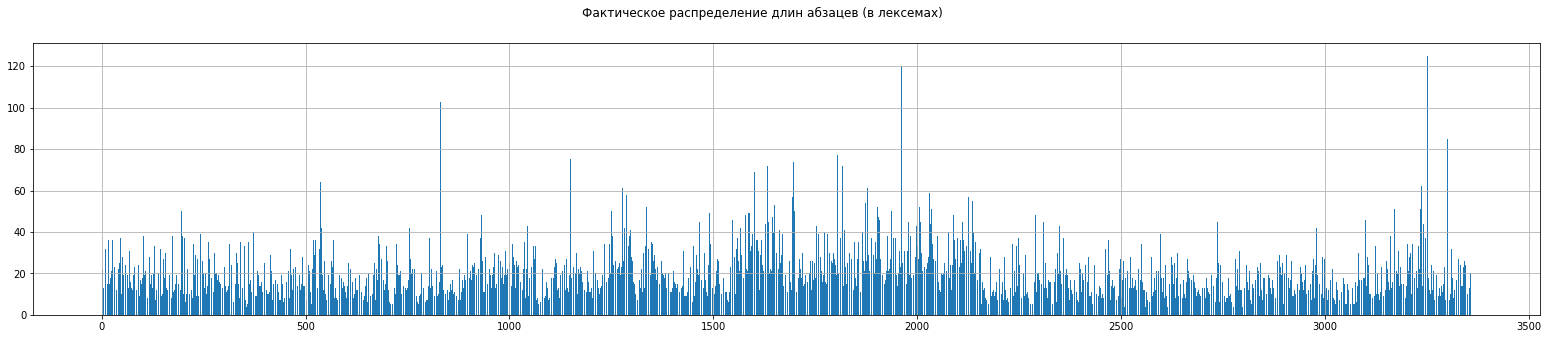

Collections Counter({13: 170, 12: 166, 15: 152, 14: 147, 11: 146, 19: 146, 10: 143, 16: 138, 8: 123, 9: 122, 18: 120, 20: 119, 17: 118, 7: 105, 22: 102, 21: 99, 23: 86, 24: 82, 25: 79, 26: 76, 5: 74, 27: 70, 6: 64, 31: 55, 30: 54, 29: 53, 28: 49, 32: 41, 4: 36, 33: 35, 37: 31, 35: 31, 36: 29, 38: 23, 34: 23, 39: 21, 40: 18, 42: 17, 41: 16, 45: 15, 51: 12, 43: 11, 52: 11, 44: 11, 47: 10, 49: 10, 48: 9, 50: 8, 56: 8, 62: 6, 46: 6, 64: 5, 57: 5, 53: 4, 55: 4, 63: 3, 73: 3, 54: 3, 61: 3, 58: 3, 69: 3, 65: 3, 75: 2, 85: 2, 72: 2, 77: 2, 59: 2, 60: 1, 103: 1, 74: 1, 83: 1, 79: 1, 120: 1, 76: 1, 67: 1, 80: 1, 99: 1, 88: 1, 104: 1, 70: 1, 114: 1, 125: 1})


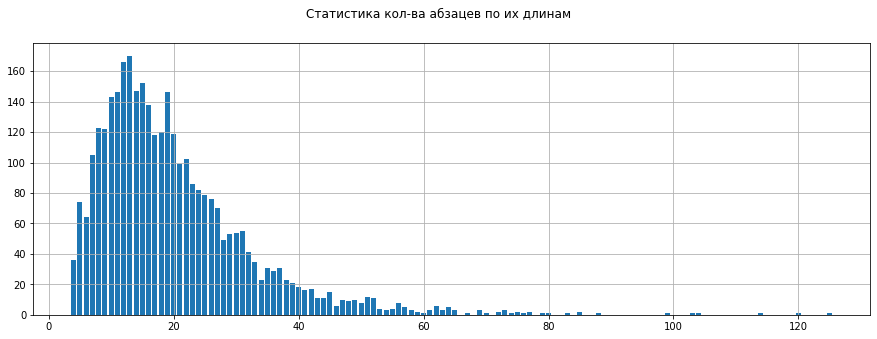

In [36]:
train_counter, train_count = draw_paragraphs_stat(paragraphs_train)

**Во скольких фразах встречается тот или  иной класс**

In [37]:
class_stat(paragraphs_train, tags_train)

Длина размеченной выборки: 3360

Статистика по классам
Фраз без определительных структур: 1552.0 - 46.19%
Фраз с категорией термин: 1794.0 - 53.39%
Фраз с категорией связка: 1741.0 - 51.82%
Фраз с категорией определение: 1700.0 - 50.6%
Фраз с категорией расшифровка: 846.0 - 25.18%
Фраз с категорией дубль-термин: 427.0 - 12.71%
Фраз с категорией дубль-связка: 295.0 - 8.78%
Фраз с категорией дубль-определение: 280.0 - 8.33%
Фраз с категорией дубль-расшифровка: 62.0 - 1.85%


### The extraction of morphological features for lexemes from the array paragraphs_train.

In [ ]:
morph_train = []
for i, elem in enumerate(paragraphs_train):
  row = []
  for j,lexem in enumerate(elem):
    row.append(morphyus(lexem))
  morph_train.append(row)
  print(f'{i+1} done {j+1}!')

In [ ]:
for mrph in morph_train[1999]:
  print(mrph)

In [40]:
# Статистика по длинам морфологических описаний для лексем 
k = 0
word = ''
index = -1
a = set()
for i, elem in enumerate(morph_train):
  for j,lexem in enumerate(elem):
    dlina = len(lexem)
    a.add(dlina)
    if dlina>k:
      index = i
      k = dlina
      word = lexem[2]

print(f'Лексема с максимально длинным морфологическим описанием: max(lexemdescription) = {k}; word = {word}; index(предложения) = {index}')
print('Перечень всех вариантов для длины морфологического описания лексемы\n',sorted(a))

Лексема с максимально длинным морфологическим описанием: max(lexemdescription) = 977; word = так; index(предложения) = 398
Перечень всех вариантов для длины морфологического описания лексемы
 [15, 28, 41, 54, 67, 80, 93, 106, 119, 132, 145, 158, 171, 184, 197, 210, 223, 236, 249, 262, 314, 327, 340, 353, 366, 379, 392, 418, 444, 470, 483, 496, 509, 548, 561, 626, 652, 665, 977]


In [41]:
# Составим массив нормальных форм слов параллельный массиву paragraphs_train
# Составим массив частей речи параллельный массиву paragraphs_train
# Составим массив падежей слов параллельный массиву paragraphs_train
# Составим массив языковой принадлежности слов параллельный массиву paragraphs_train
norms_train = []
pos_train = []
case_train = []
lang_train = []
for i, elem in enumerate(morph_train):
  norms_sentence = []
  pos_sentence = []
  case_sentence = []
  lang_sentence = []
  for j,lexem in enumerate(elem):
    len_descr = len(lexem)
    lang_sentence.append(lexem[0])
    norms_sentence.append(lexem[2])
    # собрать все части речи у лексемы
    pos = set()
    for k in range(3, len_descr,13):
      pos.add(lexem[k])
    pos_sentence.append("".join(list(pos)))
    # собрать у лексемы все падежи и 
    # признаки формы глагола, причастия, деепричастия - GRND, PRTS, PRTF, INFN, VERB
    case = set()
    if lexem[3] in ['GRND', 'PRTS', 'PRTF', 'INFN', 'VERB']:
      for k in range(4, len_descr,13):
        for m in range(k, k+11):
          case.add(lexem[m] if not lexem[m] in ['None'] else '')
    else: 
      for k in range(6, len_descr,13):
        case.add(lexem[k])
    case_sentence.append("".join(list(case)))
  norms_train.append(norms_sentence)  
  pos_train.append(pos_sentence)
  case_train.append(case_sentence)
  lang_train.append(lang_sentence)

In [ ]:
# for i, elem in enumerate(lang_train):
#   print(i+1, elem)

In [ ]:
# for i, elem in enumerate(norms_train):
#   print(i+1, elem)

In [ ]:
# for i, elem in enumerate(pos_train):
#   print(i+1, elem)

In [ ]:
# for i, elem in enumerate(case_train):
#   print(i+1, elem)

### Testing sample

In [46]:
test_paragraphs_amount = 703
ps_test = load_xml('/content/drive/My Drive/Базы/NLP/База_словарей_test_6.xml', test_paragraphs_amount)
print(len(ps_test))

712


In [47]:
paragraphs_test, tags_test, test_colors, max_test_paragraph_len, max_test_paragraph_len_ind, test_exception_array, semantics_test  = pars_xml(ps_test)
test_paragraphs_amount = len(paragraphs_test)  # обновляем длину массива на случай наличия в исходной базе пустых строк
test_paragraphs_amount, test_exception_array # контрольный вывод на размера принятых данных и массива индексов пустых строк

line 0
line 100
line 200
line 300
line 400
line 500
line 600
line 700


(703, [])

In [48]:
# # Визуальный контроль правильности разбора файла
# for i, elem in enumerate(paragraphs_test):
#   print(i+1, elem)

In [49]:
test_yes = 0
test_no = 0
for elem in semantics_test:
  if elem[0]==1:
    test_yes += 1
  else:
    test_no += 1
print(f"train: yes={test_yes}, no={test_no}")

train: yes=398, no=305


In [50]:
if len(test_colors) > colors_count:
  print('В документе цветов разметки больше допустимого')
test_colors # выведем все цвета, которые мы встретили

{'blue',
 'cyan',
 'darkyellow',
 'green',
 'lightgray',
 'magenta',
 'red',
 'white',
 'yellow'}

In [51]:
print(len(paragraphs_test))
print(len(tags_test))

print('Максимальная длина предложения — max_test_paragraph_len =',max_test_paragraph_len)
print('Индекс предложения с максимальной длиной — max_test_paragraph_len_ind =',max_test_paragraph_len_ind)

703
703
Максимальная длина предложения — max_test_paragraph_len = 58
Индекс предложения с максимальной длиной — max_test_paragraph_len_ind = 639


In [52]:
# Корректируем максимальную длину предложения для использования U-net сеток
max_test_paragraph_len = max_paragraph_len

**Извлекаем статистику по абзацам**

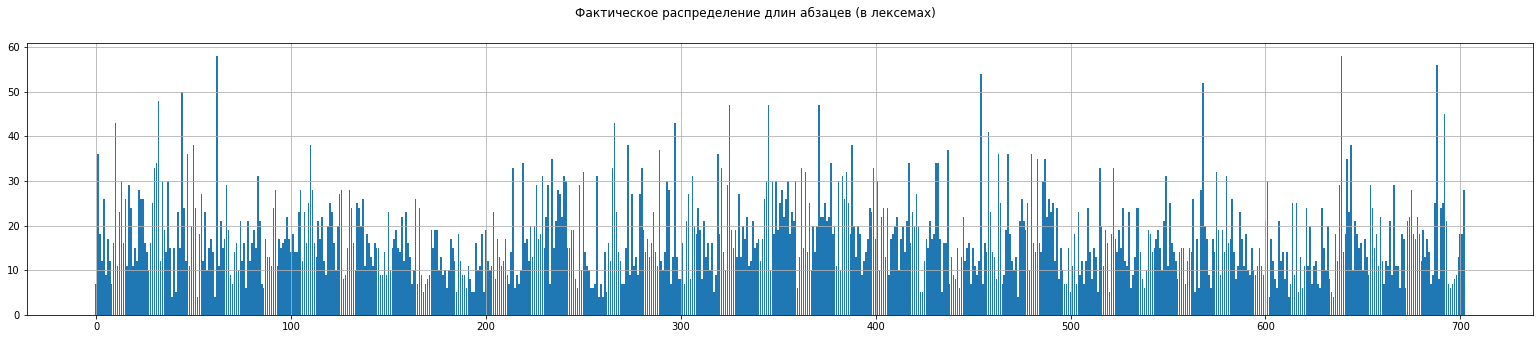

Collections Counter({15: 41, 12: 39, 14: 39, 17: 37, 9: 34, 16: 34, 11: 34, 10: 33, 7: 32, 18: 30, 13: 28, 19: 24, 21: 22, 20: 21, 8: 21, 23: 20, 24: 20, 6: 20, 5: 17, 22: 17, 25: 16, 30: 14, 26: 13, 28: 12, 29: 9, 33: 9, 4: 9, 27: 8, 31: 8, 36: 6, 34: 6, 38: 5, 35: 4, 32: 4, 43: 3, 47: 3, 58: 2, 37: 2, 48: 1, 50: 1, 54: 1, 41: 1, 52: 1, 56: 1, 45: 1})


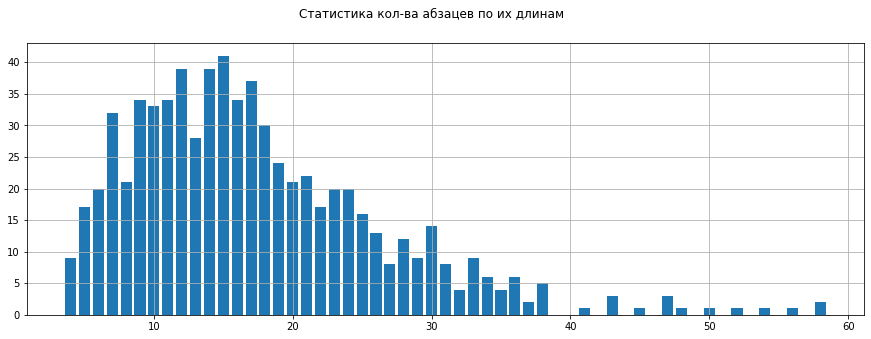

In [53]:
test_counter, test_count = draw_paragraphs_stat(paragraphs_test)

**Во скольких фразах встречается тот или  иной класс**

In [54]:
class_stat(paragraphs_test, tags_test)

Длина размеченной выборки: 703

Статистика по классам
Фраз без определительных структур: 305.0 - 43.39%
Фраз с категорией термин: 398.0 - 56.61%
Фраз с категорией связка: 395.0 - 56.19%
Фраз с категорией определение: 374.0 - 53.2%
Фраз с категорией расшифровка: 225.0 - 32.01%
Фраз с категорией дубль-термин: 72.0 - 10.24%
Фраз с категорией дубль-связка: 40.0 - 5.69%
Фраз с категорией дубль-определение: 41.0 - 5.83%
Фраз с категорией дубль-расшифровка: 9.0 - 1.28%


### The extraction of morphological features for lexemes from the array paragraphs_test.

In [ ]:
morph_test = []
for i, elem in enumerate(paragraphs_test):
  row = []
  for j,lexem in enumerate(elem):
    row.append(morphyus(lexem))
  morph_test.append(row)
  print(f'{i+1} done {j+1}!')

In [56]:
len(morph_test)

703

In [57]:
# for mrph in morph_test[665]:
#   print(mrph)

In [58]:
# Статистика по длинам морфологических описаний для лексем 
k_test = 0
word_test = ''
index_test = -1
a_test = set()
for i, elem in enumerate(morph_test):
  for j,lexem in enumerate(elem):
    dlina = len(lexem)
    a.add(dlina)
    if dlina>k_test:
      index_test = i
      k_test = dlina
      word_test = lexem[2]

print(f'Лексема с максимально длинным морфологическим описанием: max(lexemdescription) = {k_test}; word = {word_test}; index(предложения) = {index_test}')
print('Перечень всех вариантов для длины морфологического описания лексемы\n',sorted(a))

Лексема с максимально длинным морфологическим описанием: max(lexemdescription) = 665; word = так; index(предложения) = 325
Перечень всех вариантов для длины морфологического описания лексемы
 [15, 28, 41, 54, 67, 80, 93, 106, 119, 132, 145, 158, 171, 184, 197, 210, 223, 236, 249, 262, 314, 327, 340, 353, 366, 379, 392, 418, 444, 470, 483, 496, 509, 548, 561, 626, 652, 665, 977]


In [59]:
# Составим массив нормальных форм слов параллельный массиву paragraphs_test
# Составим массив частей речи параллельный массиву paragraphs_test
# Составим массив падежей слов параллельный массиву paragraphs_test
# Составим массив языковой принадлежности слов параллельный массиву paragraphs_test
norms_test = []
pos_test = []
case_test = []
lang_test = []
for i, elem in enumerate(morph_test):
  norms_sentence = []
  pos_sentence = []
  case_sentence = []
  lang_sentence = []
  for j,lexem in enumerate(elem):
    len_descr = len(lexem)
    lang_sentence.append(lexem[0])
    norms_sentence.append(lexem[2])
    # собрать все части речи у лексемы
    pos = set()
    for k in range(3, len_descr,13):
      pos.add(lexem[k])
    pos_sentence.append("".join(list(pos)))
    # собрать у лексемы все падежи и 
    # признаки формы глагола, причастия, деепричастия - GRND, PRTS, PRTF, INFN, VERB
    case = set()
    if lexem[3] in ['GRND', 'PRTS', 'PRTF', 'INFN', 'VERB']:
      for k in range(4, len_descr,13):
        for m in range(k, k+11):
          case.add(lexem[m] if not lexem[m] in ['None'] else '')
    else: 
      for k in range(6, len_descr,13):
        case.add(lexem[k])
    case_sentence.append("".join(list(case)))
  norms_test.append(norms_sentence)  
  pos_test.append(pos_sentence)
  case_test.append(case_sentence)
  lang_test.append(lang_sentence)

In [60]:
# for i, elem in enumerate(lang_test):
#   print(i+1, elem)

In [61]:
# for i, elem in enumerate(norms_test):
#   print(i+1, elem)

In [62]:
# for i, elem in enumerate(pos_test):
#   print(i+1, elem)

In [63]:
# for i, elem in enumerate(case_test):
#   print(i+1, elem)

# **Step 1. Text Classification** on the Parts of Speech

## Preparing a dataset

Объединим обучающий и тестовый массивы, чтобы воспользоваться общим токенизатором для нескольких входов с данными о pos, case, и т.д.

In [64]:
full_pcln = pos_train + pos_test + case_train + case_test + lang_train + lang_test + norms_train + norms_test
full_semantics = semantics_train + semantics_test
print(len(full_pcln))
print(len(full_semantics))

16252
4063


In [65]:
full_pcln_together = [' '.join(sequence) for sequence in full_pcln]

In [66]:
# full_pcln_together[max_paragraph_len_ind]

In [67]:
# full_semantics[max_paragraph_len_ind]

In [68]:
num_words = 10000 
# 2000 из расчёта: 
# 550 единиц на морфологические признаки и на наименования частей речи
# 1450 единиц на наиболее частотные лексемы из текста
sent_len = max_paragraph_len 
tokenizer = Tokenizer(num_words, filters=' \t\n', oov_token='<UNK>')

In [69]:
tokenizer.fit_on_texts(full_pcln_together)

In [70]:
# реальная длина словаря. Сравниваем со значением num_words
len(tokenizer.index_word)

9604

**Токенизируем входные данные.** (Выходные данные у нас изначально представляют собой токены)

In [71]:
X = tokenizer.texts_to_sequences(full_pcln_together)

In [72]:
Y = np.array(full_semantics)

**Теперь разобъём X на два входных массива с данными о pos, cases, lang и norms размерностью paragraphs_amount + test_paragraphs_amount каждый**

In [73]:
L = paragraphs_amount + test_paragraphs_amount
M = 2*L
N = M+L
X_pos = X[:L]
X_case = X[L:M]
X_lang = X[M:N]
X_norms = X[N:]

**Проверка входящих и исходящих массивов на соответствие их размерностей** 

(для выявления факта порчи данных функцией Tokenizer)

In [74]:
len(X_pos)==len(Y)

True

In [75]:
len(X_case)==len(Y)

True

In [76]:
len(X_lang)==len(Y)

True

In [77]:
len(X_norms)==len(Y)

True

In [78]:
# print(Y)

In [79]:
# print(X_pos[0])

In [80]:
# print(X_case[0])

In [81]:
# print(X_lang[0])

In [82]:
# print(X_norms[0])

**Выравнивание массивов до максимального размера абзаца**

In [83]:
X_pos = pad_sequences(X_pos, sent_len, padding='post', truncating='post') # заполнение в конце и обрезка с конца предложения

In [84]:
X_case = pad_sequences(X_case, sent_len, padding='post', truncating='post') # заполнение в конце и обрезка с конца предложения

In [85]:
X_lang = pad_sequences(X_lang, sent_len, padding='post', truncating='post')

In [86]:
X_norms = pad_sequences(X_norms, sent_len, padding='post', truncating='post')

In [87]:
X_pos.shape

(4063, 128)

In [88]:
X_case.shape

(4063, 128)

In [89]:
X_lang.shape

(4063, 128)

In [90]:
X_norms.shape

(4063, 128)

In [91]:
Y.shape

(4063, 1)

In [92]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
Xtrain_pos, Xtest_pos, Ytrain, Ytest = train_test_split(X_pos, Y, train_size=train_paragraphs_len, shuffle=False) # Не перемешиваем данные и берём целую часть на тренировочную выборку

In [93]:
Xtrain_case = X_case[:train_paragraphs_len]
Xtest_case = X_case[train_paragraphs_len:]

Xtrain_lang = X_lang[:train_paragraphs_len]
Xtest_lang = X_lang[train_paragraphs_len:]

Xtrain_norms = X_norms[:train_paragraphs_len]
Xtest_norms = X_norms[train_paragraphs_len:]

### Total for training and testing samples we have:

In [94]:
print('Xtrain_pos.shape=',Xtrain_pos.shape)
print('Xtest_pos.shape=',Xtest_pos.shape)
print('Xtrain_case.shape=',Xtrain_case.shape)
print('Xtest_case.shape=',Xtest_case.shape)

print('Xtrain_lang.shape=',Xtrain_lang.shape)
print('Xtest_lang.shape=',Xtest_lang.shape)
print('Xtrain_norms.shape=',Xtrain_norms.shape)
print('Xtest_norms.shape=',Xtest_norms.shape)

print('Ytrain.shape=',Ytrain.shape)
print('Ytest.shape=',Ytest.shape)

Xtrain_pos.shape= (3360, 128)
Xtest_pos.shape= (703, 128)
Xtrain_case.shape= (3360, 128)
Xtest_case.shape= (703, 128)
Xtrain_lang.shape= (3360, 128)
Xtest_lang.shape= (703, 128)
Xtrain_norms.shape= (3360, 128)
Xtest_norms.shape= (703, 128)
Ytrain.shape= (3360, 1)
Ytest.shape= (703, 1)


In [95]:
# Xtrain_pos[1]

In [96]:
# Xtrain_case[1]

In [97]:
# Xtrain_lang[1]

In [98]:
# Xtrain_norms[1]

In [99]:
# Ytrain[1]

## Recurrent neural network model (LSTM)

In [100]:
embedding_size = 100

# параллельная архитектура
input_pos = Input((sent_len,))
x_pos = Embedding(num_words, embedding_size)(input_pos)
x_pos = Conv1D(64, 3, padding='same', name='input1_conv1')(x_pos)
x_pos = BatchNormalization()(x_pos)
x_pos = Activation('relu')(x_pos)
x_pos = Dropout(0.2)(x_pos)

input_case = Input((sent_len,))
x_case = Embedding(num_words, embedding_size)(input_case)
x_case = Conv1D(64, 3, padding='same', name='input2_conv1')(x_case)
x_case = BatchNormalization()(x_case)
x_case = Activation('relu')(x_case)
x_case = Dropout(0.2)(x_case)

input_lang = Input((sent_len,))
x_lang = Embedding(num_words, embedding_size)(input_lang)
x_lang = Conv1D(64, 3, padding='same', name='input3_conv1')(x_lang)
x_lang = BatchNormalization()(x_lang)
x_lang = Activation('relu')(x_lang)
x_lang = Dropout(0.2)(x_lang)

input_norms = Input((sent_len,))
x_norms = Embedding(num_words, embedding_size)(input_norms)
x_norms = Conv1D(64, 3, padding='same', name='input4_conv1')(x_norms)
x_norms = BatchNormalization()(x_norms)
x_norms = Activation('relu')(x_norms)
x_norms = Dropout(0.2)(x_norms)

x = concatenate([x_pos, x_case, x_lang, x_norms])

# последовательная архитектура
# x_pos = Embedding(num_words, embedding_size)(input_pos)
# x_pos = BatchNormalization()(x_pos)
# x_pos = LSTM(128, return_sequences=True)(x_pos)
# x_pos = Dropout(0.2)(x_pos)

# input_case = Input((sent_len,))
# x_case = Embedding(num_words, embedding_size)(input_case)

# input_lang = Input((sent_len,))
# x_lang = Embedding(num_words, embedding_size)(input_lang)

# input_norms = Input((sent_len,))
# x_norms = Embedding(num_words, embedding_size)(input_norms)


# x = concatenate([x_pos, x_case])
# x = BatchNormalization()(x)
# x = LSTM(128, return_sequences=True)(x)
# x = Dropout(0.2)(x)

# x = concatenate([x, x_lang])
# x = BatchNormalization()(x)
# x = LSTM(128, return_sequences=True)(x)
# x = Dropout(0.2)(x)

# x = concatenate([x, x_norms])
# x = BatchNormalization()(x)
x = LSTM(128, return_sequences=True)(x)
x = SpatialDropout1D(0.2)(x)
x = Flatten()(x)
# x = BatchNormalization()(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

modelLSTM = Model(inputs=[input_pos, input_case, input_lang, input_norms], outputs=output)

#  'adam' 'rmsprop'   Adam
modelLSTM.compile(loss='binary_crossentropy', metrics=[AUC(num_thresholds=150)], optimizer=RMSprop(lr=1e-4)) #

modelLSTM.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128)]        0                                            
_______________________________________________________________________________________

In [101]:
'''
  callback-функция раннего останова по достижению достаточного процента точности
'''
def stop_NNT(about):
  print(about) 
  # https://www.tensorflow.org/guide/keras/custom_callback
  modelLSTM.stop_training = True

def on_epoch_end(epoch, logs):
  if (epoch > 10):
    precision = logs.get('val_auc')
    precision_train = logs.get('auc')
    if precision_train > 0.999 and precision > 0.996:
      stop_NNT("\nОбучение приостановлено при достаточном значении точности . val_auc = {}".format(round(precision, 3)))      

early_stop = tf.keras.callbacks.LambdaCallback(on_epoch_end=on_epoch_end)

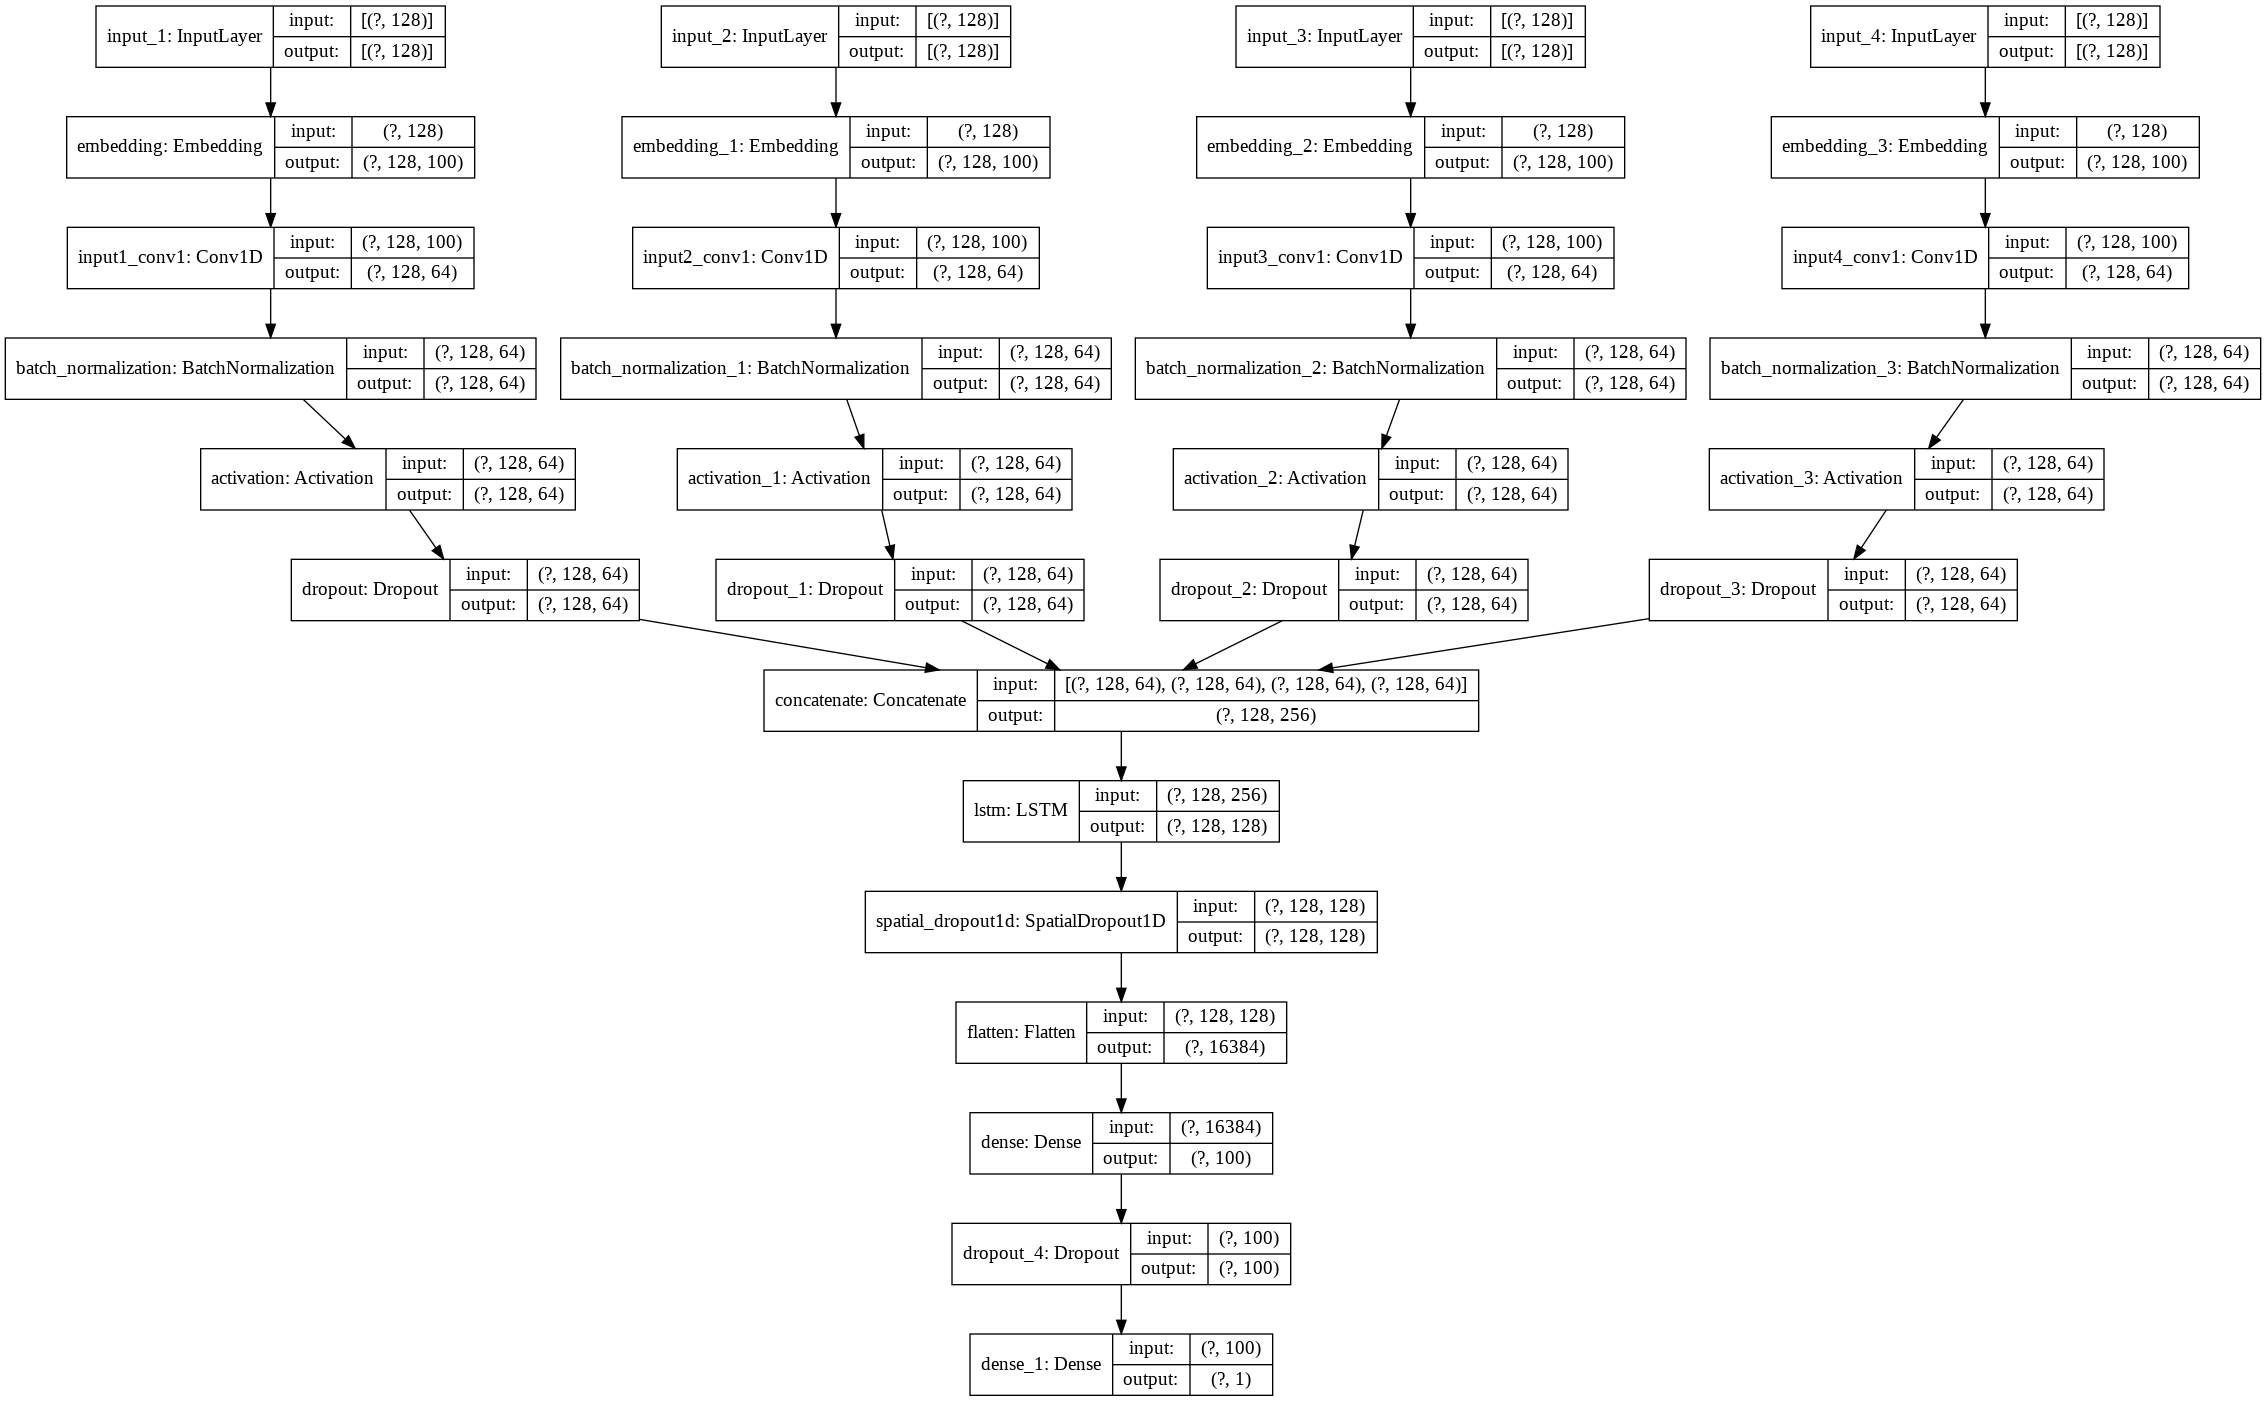

In [102]:
plot_model(modelLSTM, show_shapes=True)

In [ ]:
historyLSTM = modelLSTM.fit(x=[Xtrain_pos, Xtrain_case, Xtrain_lang, Xtrain_norms], y=Ytrain, 
                            batch_size=96, epochs=61, 
                            validation_data=([Xtest_pos, Xtest_case, Xtest_lang, Xtest_norms], Ytest), 
                            callbacks=[early_stop])
                    
modelLSTM.save( '/content/drive/My Drive/tmp/modelLSTM_classification(production).h5' )

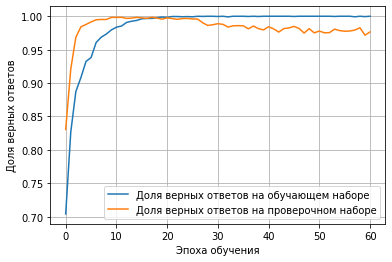

In [104]:
# график прогрессии обучения нейросети в Matplotlib
plt.plot(historyLSTM.history['auc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyLSTM.history['val_auc'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend(loc='best')
plt.show()

**Проверка качества работы нейронной сети**

In [105]:
Y_hat = modelLSTM.predict([Xtest_pos, Xtest_case, Xtest_lang, Xtest_norms])
Y_hat.shape, Ytest.shape

((703, 1), (703, 1))

In [106]:
y_coincidence = 0
y_unrecognized = 0
y_contrived = 0
for i, pred in enumerate(Y_hat):
  b = Ytest[i][0]
  a = round(pred[0])
  print(i+1, a, b, paragraphs_test[i])
  if a+b>1.5:
    y_coincidence += 1
  elif a+b<0.5:
    y_coincidence += 1
  else:
    if a>0.5:
      y_contrived += 1
    else:
      y_unrecognized += 1

print(f"\nРаспознано: {y_coincidence}; Нераспознано: {y_unrecognized}; Надумано: {y_contrived}")  

1 1.0 1 ['Свойство', '—', 'необходимое', 'условие', 'принадлежности', 'классу', '.']
2 1.0 1 ['Парадигма', 'программирования', 'как', 'исходная', 'концептуальная', 'схема', 'постановки', 'проблем', 'и', 'их', 'решения', 'является', 'инструментом', 'грамматического', 'описания', 'фактов', ',', 'событий', ',', 'явлений', 'и', 'процессов', ',', 'возможно', ',', 'не', 'существующих', 'одновременно', ',', 'но', 'интуитивно', 'объединяемых', 'в', 'общее', 'понятие', '.']
3 1.0 1 ['Ветвление', '—', 'однократное', 'выполнение', 'одной', 'из', 'двух', 'или', 'более', 'операций', ',', 'в', 'зависимости', 'от', 'выполнения', 'заданного', 'условия', '.']
4 1.0 1 ['Локальные', 'переменные', '–', 'это', 'переменные', ',', 'объявленные', 'внутри', 'любого', 'блока', 'программы', '.']
5 1.0 1 ['Императивная', '(', 'процедурная', ')', 'часть', 'языка', 'ДРАКОН', 'опирается', 'на', 'новую', 'парадигму', 'программирования', '—', 'двумерное', '(', 'графическое', ')', 'структурное', 'программирование', '['

ROC-кривая (англ. receiver operating characteristic, рабочая характеристика приёмника) — график, позволяющий оценить качество бинарной классификации, отображает соотношение между долей объектов от общего количества носителей признака, верно классифицированных как несущие признак (англ. true positive rate, TPR, называемой чувствительностью алгоритма классификации), и долей объектов от общего количества объектов, не несущих признака, ошибочно классифицированных как несущие признак (англ. false positive rate, FPR, величина 1-FPR называется специфичностью алгоритма классификации) при варьировании порога решающего правила.

https://ru.wikipedia.org/wiki/ROC-%D0%BA%D1%80%D0%B8%D0%B2%D0%B0%D1%8F

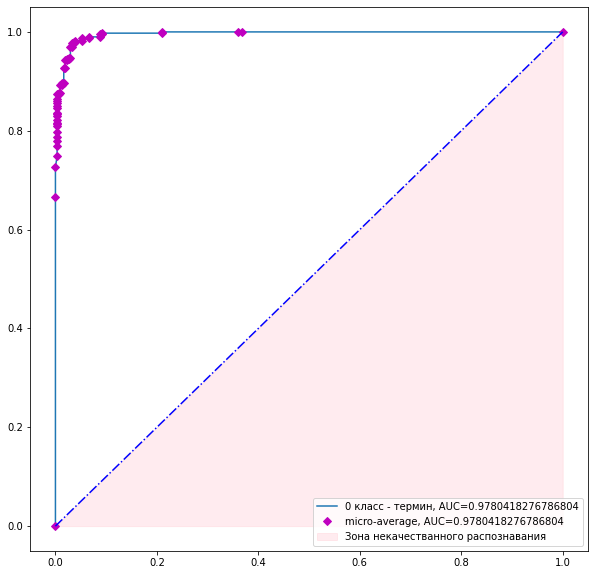

In [107]:
plt.figure(figsize=(10,10))


num_classes = 1 #узнаем, сколько всего классов
for i in range(num_classes): #проходимся по всем классам
  fpr, tpr, thresholds = roc_curve(Ytest[:, i], Y_hat[:, i]) #получаем roc-кривую для очередного класса
  plt.plot(fpr, tpr, label='{} класс - {}, AUC={}'.format(i, dic_color[i], AUC()(Ytest[:, i], Y_hat[:, i]))) #отрисовываем кривую и подписываем ее площадь

avg_fpr, avg_tpr, thresholds = roc_curve(Ytest.flatten(), Y_hat.flatten()) #получаем micro-average (общую) кривую roc
plt.plot(avg_fpr, avg_tpr, 'mD',label='micro-average, AUC={}'.format(AUC()(Ytest, Y_hat)))#отрисовываем кривую и подписываем ее площадь
plt.plot([0,1], [0,1], 'b-.') #обозначим границу качественной работы нейросети
plt.fill_between([0,1], [0,1], label='Зона некачестванного распознавания', color='pink', alpha=0.3) #обозначим границу некачественной работы нейросети
plt.legend()

## Fetching arrays for the next step in extracting definitional structures in phrases with expected semantic status

In [108]:
pos_train_2 = []
case_train_2 = []
lang_train_2 = []
norms_train_2 = []
tags_train_2 = []
paragraphs_train_2 = []
for i, elem in enumerate(semantics_train):
  if elem[0]==1:
    pos_train_2.append(pos_train[i])
    case_train_2.append(case_train[i])
    lang_train_2.append(lang_train[i])
    norms_train_2.append(norms_train[i])
    paragraphs_train_2.append(paragraphs_train[i])
    tags_train_2.append(tags_train[i])

print(f'Обучающие массивы (с размерностью {train_yes})', 
      len(pos_train_2), len(case_train_2), 
      len(lang_train_2), len(norms_train_2), 
      len(tags_train_2), len(paragraphs_train_2))


Обучающие массивы (с размерностью 1808) 1808 1808 1808 1808 1808 1808


In [109]:
pos_test_2 = []
case_test_2 = []
lang_test_2 = []
norms_test_2 = []
tags_test_2 = []
paragraphs_test_2 = []
for i, elem in enumerate(Y_hat):
  if round(elem[0])>0:
    pos_test_2.append(pos_test[i])
    case_test_2.append(case_test[i])
    lang_test_2.append(lang_test[i])
    norms_test_2.append(norms_test[i])
    paragraphs_test_2.append(paragraphs_test[i])
    tags_test_2.append(tags_test[i])

print(f'Тренировочные массивы (с размерностью {test_yes}):',
      len(pos_test_2), len(case_test_2), 
      len(lang_test_2), len(norms_test_2), 
      len(tags_test_2), len(paragraphs_test_2))


Тренировочные массивы (с размерностью 398): 423 423 423 423 423 423


# **Step 2. Segmentation of text** on the Parts of Speech

## Preparing a dataset

Объединим обучающий и тестовый массивы, чтобы воспользоваться общим токенизатором.

In [110]:
# Здесь для обучения оставим обучающую выборку в полном объёме, 
# а из тестовой возьмём только то, что выбрала нейронка на предыдущем шаге
all_pcln = pos_train + pos_test_2 + case_train + case_test_2 + \
           lang_train + lang_test_2 + norms_train + norms_test_2 
all_tags = tags_train + tags_test_2
all_paragraphs = paragraphs_train + paragraphs_test_2
train_test_paragraphs_amount_2 = len(all_paragraphs)

print(len(all_pcln))
print(len(all_tags))
print(len(all_paragraphs))

print(f'train_test_paragraphs_amount_2 = {train_test_paragraphs_amount_2}')

15132
3783
3783
train_test_paragraphs_amount_2 = 3783


In [111]:
all_pcln_together = [' '.join(sequence) for sequence in all_pcln]

In [112]:
len(all_pcln_together)

15132

In [113]:
all_pcln_together[0]

'ADJF NOUN PNCT NOUN NOUN PNCT NOUNPREP ADJF VERB NOUN NOUN NOUN PNCT ADJFPRCLCONJ INTJINFNVERB VERB PNCT NPROPRCLADVBCONJ VERB NPRO NOUN INTJPRCLNOUNCONJ PRTF NOUN PNCT'

In [114]:
all_tags_together = [' '.join(tag) for tag in all_tags]

In [115]:
all_tags_together[0]

'термин термин связка определение определение o расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка расшифровка o'

**Токенизируем входные и выходные данные.**

In [116]:
X_2 = tokenizer.texts_to_sequences(all_pcln_together)

In [117]:
Y_2 = tag_tokenizer.texts_to_sequences(all_tags_together)

In [118]:
Y_2[13]

[2, 2, 2, 2, 3, 5, 5, 5, 5, 1]

**Теперь разобъём X на два входных массива с данными о pos и cases размерностью paragraphs_amount + test_paragraphs_amount каждый**

In [119]:
L = train_test_paragraphs_amount_2
M = 2*L
N = M+L
X_2_pos = X_2[:L]
X_2_case = X_2[L:M]
X_2_lang = X_2[M:N]
X_2_norms = X_2[N:]

**Проверка входящих и исходящих массивов на соответствие их размерностей** 

(для выявления факта порчи данных функцией Tokenizer)

In [120]:
len(X_2_pos)==len(Y_2)

True

In [121]:
len(X_2_case)==len(Y_2)

True

In [122]:
len(X_2_lang)==len(Y_2)

True

In [123]:
len(X_2_norms)==len(Y_2)

True

In [124]:
len(Y_2)

3783

In [125]:
# Проверка на согласованность входных и выходных данных
for i, elem in enumerate(X_2_pos):
  if len(Y_2[i]) != len(X_2_pos[i]):
    print('X_2_pos[{}] ='.format(i),X_2_pos[i])
    print('Y_2[{}] ='.format(i),Y_2[i])
    # Если все массивы равны, то здесь  ничего не должно печататься
  else:
    pass
    # print('len(X_2_pos[{}]) ='.format(i),len(Y_2[i]))
  if len(Y_2[i]) != len(X_2_case[i]):
    print('X_2_case[{}] ='.format(i),X_2_case[i])
    print('Y_2[{}] ='.format(i),Y_2[i])
    # Если все массивы равны, то здесь  ничего не должно печататься
  else:
    pass
    # print('len(X_2_case[{}]) ='.format(i),len(Y_2[i]))
  if len(Y_2[i]) != len(X_2_lang[i]):
    print('X_2_lang[{}] ='.format(i),X_2_lang[i])
    print('Y_2[{}] ='.format(i),Y_2[i])
    # Если все массивы равны, то здесь  ничего не должно печататься
  else:
    pass
    # print('len(X_2_lang[{}]) ='.format(i),len(Y_2[i]))
  if len(Y_2[i]) != len(X_2_norms[i]):
    print('X_2_norms[{}] ='.format(i),X_2_norms[i])
    print('Y_2[{}] ='.format(i),Y_2[i])
    # Если все массивы равны, то здесь  ничего не должно печататься
  else:
    pass
    # print('len(X_2_norms[{}]) ='.format(i),len(Y_2[i]))

**Выравнивание массивов до максимального размера абзаца**

In [126]:
X_2_pos = pad_sequences(X_2_pos, sent_len, padding='pre', truncating='post') # заполнение в начале и обрезка с конца предложения

In [127]:
X_2_case = pad_sequences(X_2_case, sent_len, padding='pre', truncating='post') # заполнение в начале и обрезка с конца предложения

In [128]:
X_2_lang = pad_sequences(X_2_lang, sent_len, padding='pre', truncating='post') # заполнение в начале и обрезка с конца предложения

In [129]:
X_2_norms = pad_sequences(X_2_norms, sent_len, padding='pre', truncating='post') # заполнение в начале и обрезка с конца предложения

In [130]:
X_2_pos.shape

(3783, 128)

In [131]:
X_2_case.shape

(3783, 128)

In [132]:
X_2_lang.shape

(3783, 128)

In [133]:
X_2_norms.shape

(3783, 128)

In [134]:
Y_2 = pad_sequences(Y_2, sent_len, value=1, padding='pre', truncating='post') # заполнение в начале и обрезка с конца предложения

In [135]:
Y_2.shape

(3783, 128)

In [136]:
Y_2 = to_categorical(Y_2, colors_count+1)  # см. лекцию "Занятие № 6 Углубленный курс по текстам" https://youtu.be/Nfw7ZY-WzS8?t=1533
Y_2.shape

(3783, 128, 10)

In [137]:
Y_2 = Y_2[:, :, 1:]  # см. лекцию "Занятие № 6 Углубленный курс по текстам" https://youtu.be/Nfw7ZY-WzS8?t=1533
Y_2.shape

(3783, 128, 9)

In [138]:
print(colorize_the_text(all_paragraphs[13], Y_2[13], 0, 'pre', sent_len))

 hash ( x ) - Возвращает хеш указанного объекта .


Далее заменяем массивы из первого этапа по классификации предложений

In [139]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
Xtrain_pos, Xtest_pos, Ytrain, Ytest = train_test_split(X_2_pos, Y_2, train_size=train_paragraphs_len, shuffle=False) # Не перемешиваем данные и берём целую часть на тренировочную выборку

In [140]:
Xtrain_case = X_2_case[:train_paragraphs_len]
Xtest_case = X_2_case[train_paragraphs_len:]

Xtrain_lang = X_2_lang[:train_paragraphs_len]
Xtest_lang = X_2_lang[train_paragraphs_len:]

Xtrain_norms = X_2_norms[:train_paragraphs_len]
Xtest_norms = X_2_norms[train_paragraphs_len:]

### Total for training and testing samples we have:

In [141]:
# Новые размерности уже "только" для массивов с определительными структурами, 
# с учетом вычисленных на этапе классификации предложений

print('Xtrain_pos.shape=',Xtrain_pos.shape)
print('Xtest_pos.shape=',Xtest_pos.shape)
print('Xtrain_case.shape=',Xtrain_case.shape)
print('Xtest_case.shape=',Xtest_case.shape)
print('Xtrain_lang.shape=',Xtrain_lang.shape)
print('Xtest_lang.shape=',Xtest_lang.shape)
print('Xtrain_norms.shape=',Xtrain_norms.shape)
print('Xtest_norms.shape=',Xtest_norms.shape)
print('Ytrain.shape=',Ytrain.shape)
print('Ytest.shape=',Ytest.shape)

Xtrain_pos.shape= (3360, 128)
Xtest_pos.shape= (423, 128)
Xtrain_case.shape= (3360, 128)
Xtest_case.shape= (423, 128)
Xtrain_lang.shape= (3360, 128)
Xtest_lang.shape= (423, 128)
Xtrain_norms.shape= (3360, 128)
Xtest_norms.shape= (423, 128)
Ytrain.shape= (3360, 128, 9)
Ytest.shape= (423, 128, 9)


In [ ]:
# Xtrain_pos[1]

In [ ]:
# Xtrain_case[1]

In [ ]:
# Xtrain_lang[1]

In [ ]:
# Xtrain_norms[1]

In [ ]:
# Ytrain[1]

In [147]:
# Пример окраски размеченного текста
print(colorize_the_text(paragraphs_test_2[0], Ytest[0], max_paragraph_len, 'pre', sent_len))

 Свойство — необходимое условие принадлежности классу .


## Modelling

In [148]:
emb_size = 128

In [149]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

In [150]:
model_dir = "/content/drive/My Drive/tmp/"

In [151]:
'''
  callback-функция сохранения на диск лучшей модели в процессе обучения
  запись осуществляется на google-диск
'''
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=1
    )
]

### **PSPnet**

*Последовательная архитектура*

In [152]:
# Функция для создания PSPnet-сети
def create_PSPNet(conv_size = 512, 
                  num_classes = 9,
                  sentence_len = 200,
                  num_words = 5000,
                  embedding_size = 50
                  ):

    # У кераса нет Conv1DTranspose, так что прописываем вручную. Нужен для развёртывания сети после maxpooling
    def Conv1DTranspose(input_tensor, filters, kernel_size=1, strides=2, padding='same'):
        """
        input_tensor: входной тензор (batch_size, time_steps, dims)
        filters: int, output dimension, выходной тензор будет иметь размер (batch_size, time_steps, filters)
        kernel_size: размер ядра свертки 
        strides: int, шаг ядра
        padding: 'same' | действительный
        """
        x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
        x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding)(x)
        x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
        return x
        
    input_pos = Input((sentence_len,))
    x_pos = Embedding(num_words, embedding_size)(input_pos)
    x_pos = Conv1D(conv_size, 3, padding='same', name='input1_conv1')(x_pos)
    x_pos = BatchNormalization()(x_pos)
    x_pos = Activation('relu')(x_pos)

    input_case = Input((sentence_len,))
    x_case = Embedding(num_words, embedding_size)(input_case)

    input_lang = Input((sentence_len,))
    x_lang = Embedding(num_words, embedding_size)(input_lang)

    input_norms = Input((sentence_len,))
    x_norms = Embedding(num_words, embedding_size)(input_norms)

    x_pos_case = concatenate([x_pos, x_case])
    x_pos_case = Conv1D(conv_size, 3, padding='same', name='input2_conv1')(x_pos_case)
    x_pos_case = BatchNormalization()(x_pos_case)
    x_pos_case = Activation('relu')(x_pos_case)

    x_pos_case_lang = concatenate([x_pos_case, x_lang])
    x_pos_case_lang = Conv1D(conv_size, 3, padding='same', name='input3_conv1')(x_pos_case_lang)
    x_pos_case_lang = BatchNormalization()(x_pos_case_lang)
    x_pos_case_lang = Activation('relu')(x_pos_case_lang)

    x_pos_case_lang_norms = concatenate([x_pos_case_lang, x_norms])
    x_pos_case_lang_norms = Conv1D(conv_size, 3, padding='same', name='input4_conv1')(x_pos_case_lang_norms)
    x_pos_case_lang_norms = BatchNormalization()(x_pos_case_lang_norms)
    x_pos_case_lang_norms = Activation('relu')(x_pos_case_lang_norms)


    # Block 1    
    x = Conv1D(conv_size, 3, padding='same')(x_pos_case_lang_norms)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x_mp_2 = MaxPooling1D(2)(x)
    x_mp_4 = MaxPooling1D(4)(x)
    x_mp_8 = MaxPooling1D(8)(x)
    x_mp_16 = MaxPooling1D(16)(x)
    x_mp_32 = MaxPooling1D(32)(x)

    x_mp_2 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_2)
    x_mp_2 = Dropout(0.5)(x_mp_2)

    x_mp_4 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_4)
    x_mp_4 = Dropout(0.5)(x_mp_4)

    x_mp_8 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_8)
    x_mp_8 = Dropout(0.5)(x_mp_8)

    x_mp_16 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_16)
    x_mp_16 = Dropout(0.5)(x_mp_16)

    x_mp_32 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_32)
    x_mp_32 = Dropout(0.5)(x_mp_32) 

    x_mp_2 = Conv1DTranspose(x_mp_2,conv_size, 2)
    x_mp_2 = Activation('relu')(x_mp_2)

    x_mp_4 = Conv1DTranspose(x_mp_4,conv_size, 4, strides=4)
    x_mp_4 = Activation('relu')(x_mp_4)

    x_mp_8 = Conv1DTranspose(x_mp_8,conv_size, 8, strides=8)
    x_mp_8 = Activation('relu')(x_mp_8)

    x_mp_16 = Conv1DTranspose(x_mp_16,conv_size, 16, strides=16)
    x_mp_16 = Activation('relu')(x_mp_16)

    x_mp_32 = Conv1DTranspose(x_mp_32,conv_size, 32, strides=32)
    x_mp_32 = Activation('relu')(x_mp_32)


    fin = concatenate([x_pos_case_lang_norms, x_mp_2, x_mp_4, x_mp_8, x_mp_16, x_mp_32])    
    fin = Conv1D(conv_size, 3, padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)
    fin = Conv1D(conv_size, 3, padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)

    fin = Conv1D(num_classes, 3, activation='softmax', padding='same')(fin)

    model = Model([input_pos, input_case, input_lang, input_norms], fin)
    model.compile(optimizer=Adadelta(lr=0.001),
                  loss='categorical_crossentropy')
    
    return model

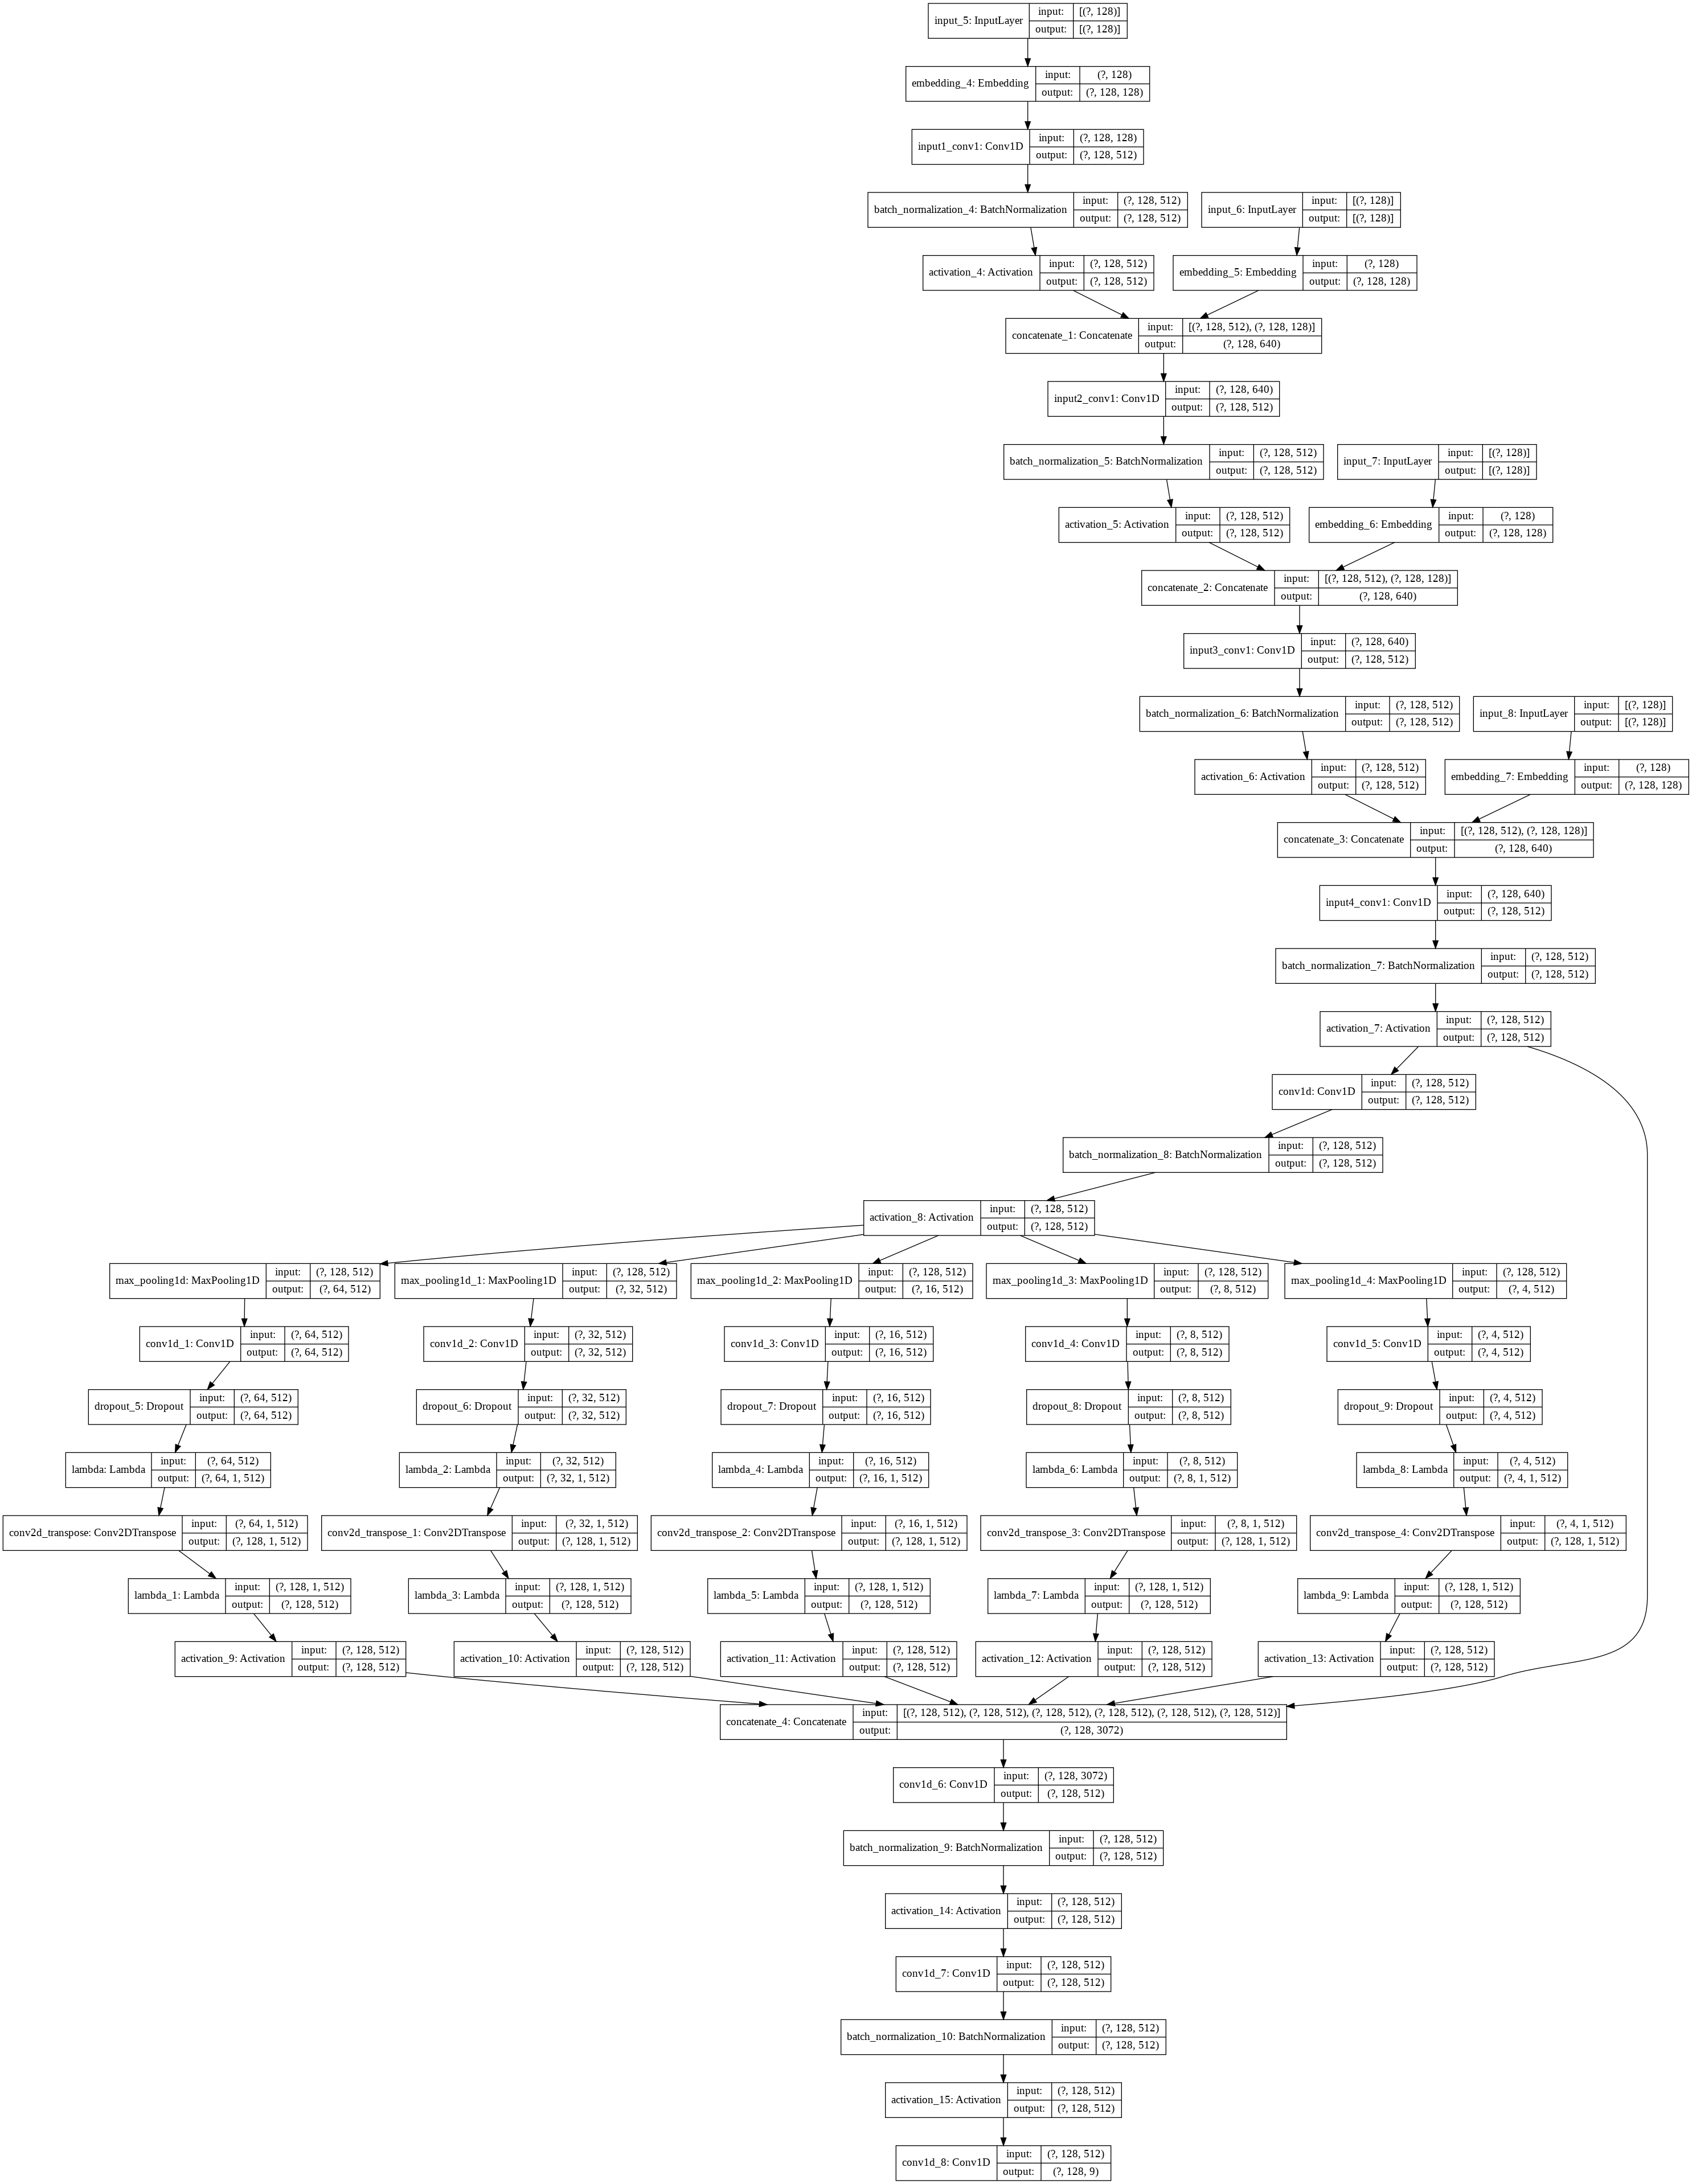

In [153]:
modelPSPnet = create_PSPNet(512, colors_count, sent_len, num_words, emb_size)
plot_model(modelPSPnet, show_shapes=True)

In [ ]:
historyPSPnet = modelPSPnet.fit(x=[Xtrain_pos, Xtrain_case, Xtrain_lang, Xtrain_norms], y=Ytrain, 
                            epochs=100, batch_size=128,
                            validation_data=([Xtest_pos, Xtest_case, Xtest_lang, Xtest_norms], Ytest))                    
modelPSPnet.save( '/content/drive/My Drive/tmp/modelPSPnet_consistent(production).h5' )

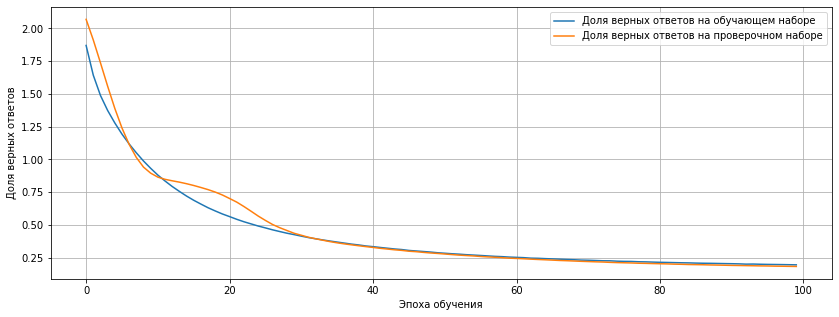

In [155]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyPSPnet.history['loss'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyPSPnet.history['val_loss'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [158]:
YpredPSPnet = modelPSPnet.predict([Xtest_pos, Xtest_case, Xtest_lang, Xtest_norms])
YpredPSPnet_test, Ytest_res, paragraphs_test_res = cleansed_data(YpredPSPnet, Ytest, paragraphs_test_2) # нехорошие данные здесь всё-таки подчищаем

Очищено фраз: 11


In [159]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest_res.argmax(axis=-1).flatten(), 
                            YpredPSPnet_test.argmax(axis=-1).flatten(), 
                            target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.98      0.98      0.98     47146
           термин       0.68      0.80      0.73       781
           связка       0.71      0.77      0.74       561
      определение       0.57      0.68      0.62      1694
      расшифровка       0.61      0.55      0.58      2074
     дубль-термин       0.32      0.28      0.30       188
     дубль-связка       0.11      0.02      0.03        65
дубль-определение       0.13      0.06      0.08       147
дубль-расшифровка       0.00      0.00      0.00        80

         accuracy                           0.94     52736
        macro avg       0.46      0.46      0.45     52736
     weighted avg       0.94      0.94      0.94     52736



**Проверка тестовой выборки (насколько хорошо обучена сеть)**

In [160]:
# выбираем конкретную фразу из тестовой выборки
i = 2 
print(f'{i + 1}.')
print(colorize_the_text(paragraphs_test_res[i], Ytest_res[i], 0, 'pre', sent_len))
print(colorize_the_text(paragraphs_test_res[i], YpredPSPnet_test[i], 0, 'pre', sent_len))

3.
 Ветвление — однократное выполнение одной из двух или более операций , в зависимости от выполнения заданного условия .
 Ветвление — однократное выполнение одной из двух или более операций , в зависимости от выполнения заданного условия .


In [161]:
# воспроизводим все фразы из тестовой выборки
for i, el in enumerate(paragraphs_test_res):
  print(f'{i+1}.')
  print(colorize_the_text(el, Ytest_res[i], 0, 'pre', sent_len))
  print(colorize_the_text(el, YpredPSPnet_test[i], 0, 'pre', sent_len))

# На github не отображается расцветка текста
# Чтобы её посмотреть, воспользуйтесь ссылкой на https://colab.research.google.com/ выше

1.
 Свойство — необходимое условие принадлежности классу .
 Свойство — необходимое условие принадлежности классу .
2.
 Парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее понятие .
 Парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее понятие .
3.
 Ветвление — однократное выполнение одной из двух или более операций , в зависимости от выполнения заданного условия .
 Ветвление — однократное выполнение одной из двух или более операций , в зависимости от выполнения заданного условия .
4.
 Локальные переменные – это переменные , объявленные внутри любого блока программы .
 Локальные пере

### **PSPnet**

*Параллельная архитектура*

In [162]:
# Функция для создания PSPnet-сети
def create_PSPNet_par(conv_size = 512, 
                  num_classes = 9,
                  sentence_len = 200,
                  num_words = 5000,
                  embedding_size = 50
                  ):

    # У кераса нет Conv1DTranspose, так что прописываем вручную. Нужен для развёртывания сети после maxpooling
    def Conv1DTranspose(input_tensor, filters, kernel_size=1, strides=2, padding='same'):
        """
        input_tensor: входной тензор (batch_size, time_steps, dims)
        filters: int, output dimension, выходной тензор будет иметь размер (batch_size, time_steps, filters)
        kernel_size: размер ядра свертки 
        strides: int, шаг ядра
        padding: 'same' | действительный
        """
        x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
        x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding)(x)
        x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
        return x
        
    # параллельная архитектура
    input_pos = Input((sentence_len,))
    x_pos = Embedding(num_words, embedding_size)(input_pos)
    x_pos = BatchNormalization()(x_pos)
    x_pos = Conv1D(conv_size, 3, padding='same', name='input1_conv1')(x_pos)
    x_pos = Activation('relu')(x_pos)

    input_case = Input((sentence_len,))
    x_case = Embedding(num_words, embedding_size)(input_case)
    x_case = BatchNormalization()(x_case)
    x_case = Conv1D(conv_size, 3, padding='same', name='input2_conv1')(x_case)
    x_case = Activation('relu')(x_case)

    input_lang = Input((sentence_len,))
    x_lang = Embedding(num_words, embedding_size)(input_lang)
    x_lang = BatchNormalization()(x_lang)
    x_lang = Conv1D(conv_size, 3, padding='same', name='input3_conv1')(x_lang)
    x_lang = Activation('relu')(x_lang)

    input_norms = Input((sentence_len,))
    x_norms = Embedding(num_words, embedding_size)(input_norms)
    x_norms = BatchNormalization()(x_norms)
    x_norms = Conv1D(conv_size, 3, padding='same', name='input4_conv1')(x_norms)
    x_norms = Activation('relu')(x_norms)

    x_pos_case_lang_norms = concatenate([x_pos, x_case, x_lang, x_norms])

    # Block 1    
    x = Conv1D(conv_size, 3, padding='same')(x_pos_case_lang_norms)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x_mp_2 = MaxPooling1D(2)(x)
    x_mp_4 = MaxPooling1D(4)(x)
    x_mp_8 = MaxPooling1D(8)(x)
    x_mp_16 = MaxPooling1D(16)(x)
    x_mp_32 = MaxPooling1D(32)(x)

    x_mp_2 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_2)
    x_mp_2 = Dropout(0.5)(x_mp_2)

    x_mp_4 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_4)
    x_mp_4 = Dropout(0.5)(x_mp_4)

    x_mp_8 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_8)
    x_mp_8 = Dropout(0.5)(x_mp_8)

    x_mp_16 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_16)
    x_mp_16 = Dropout(0.5)(x_mp_16)

    x_mp_32 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_32)
    x_mp_32 = Dropout(0.5)(x_mp_32) 

    x_mp_2 = Conv1DTranspose(x_mp_2,conv_size, 2)
    x_mp_2 = Activation('relu')(x_mp_2)

    x_mp_4 = Conv1DTranspose(x_mp_4,conv_size, 4, strides=4)
    x_mp_4 = Activation('relu')(x_mp_4)

    x_mp_8 = Conv1DTranspose(x_mp_8,conv_size, 8, strides=8)
    x_mp_8 = Activation('relu')(x_mp_8)

    x_mp_16 = Conv1DTranspose(x_mp_16,conv_size, 16, strides=16)
    x_mp_16 = Activation('relu')(x_mp_16)

    x_mp_32 = Conv1DTranspose(x_mp_32,conv_size, 32, strides=32)
    x_mp_32 = Activation('relu')(x_mp_32)


    fin = concatenate([x_pos_case_lang_norms, x_mp_2, x_mp_4, x_mp_8, x_mp_16, x_mp_32])    
    fin = Conv1D(conv_size, 3, padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)
    fin = Conv1D(conv_size, 3, padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)

    fin = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(fin)

    model = Model([input_pos, input_case, input_lang, input_norms], fin)
    model.compile(optimizer=Adadelta(lr=0.001),
                  loss='categorical_crossentropy')
    
    return model

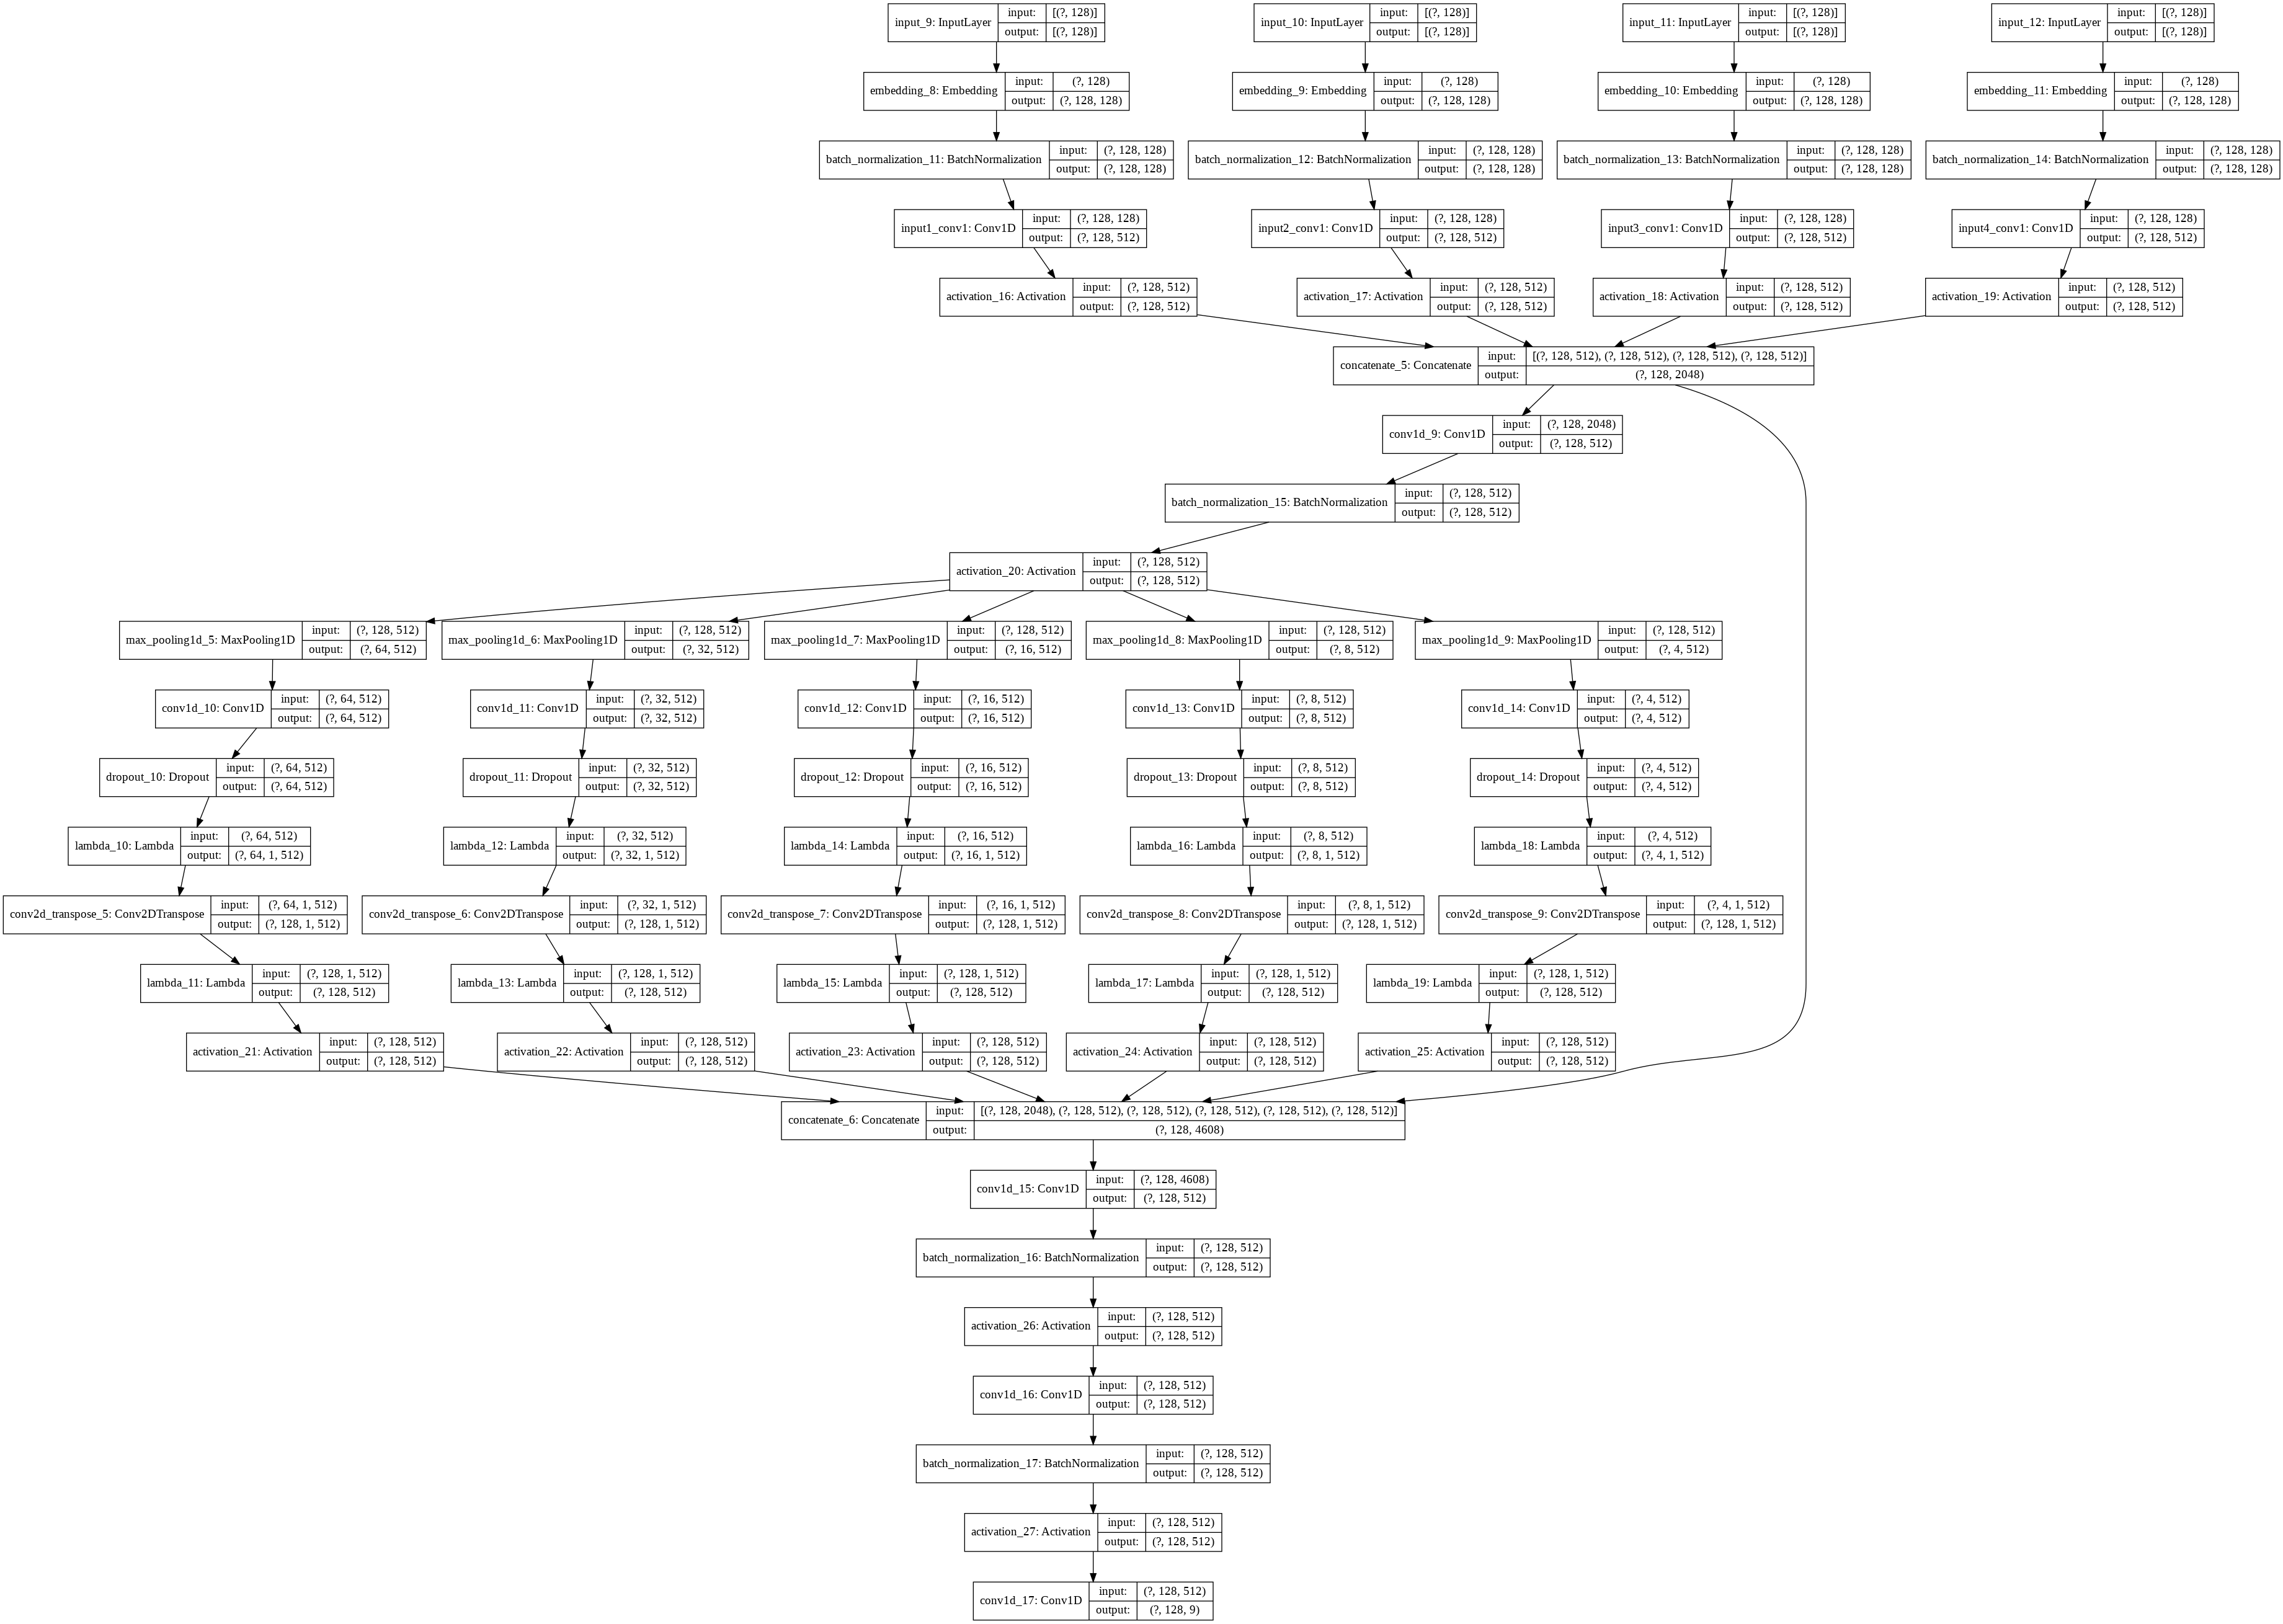

In [163]:
modelPSPnet_par = create_PSPNet_par(512, colors_count, sent_len, num_words, emb_size)
plot_model(modelPSPnet_par, show_shapes=True)

In [164]:
historyPSPnet_par = modelPSPnet_par.fit(x=[Xtrain_pos, Xtrain_case, Xtrain_lang, Xtrain_norms], y=Ytrain, 
                            epochs=100, batch_size=128,
                            validation_data=([Xtest_pos, Xtest_case, Xtest_lang, Xtest_norms], Ytest))                    
modelPSPnet_par.save( '/content/drive/My Drive/tmp/modelPSPnet_parallel(production).h5' )

Epoch 1/100
27/27 [==============================] - 7s 275ms/step - loss: 2.3143 - val_loss: 2.2159
Epoch 2/100
27/27 [==============================] - 7s 251ms/step - loss: 2.2183 - val_loss: 2.2060
Epoch 3/100
27/27 [==============================] - 7s 251ms/step - loss: 2.1438 - val_loss: 2.1776
Epoch 4/100
27/27 [==============================] - 7s 251ms/step - loss: 2.0740 - val_loss: 2.1343
Epoch 5/100
27/27 [==============================] - 7s 250ms/step - loss: 2.0094 - val_loss: 2.0799
Epoch 6/100
27/27 [==============================] - 7s 251ms/step - loss: 1.9485 - val_loss: 2.0198
Epoch 7/100
27/27 [==============================] - 7s 251ms/step - loss: 1.8909 - val_loss: 1.9566
Epoch 8/100
27/27 [==============================] - 7s 251ms/step - loss: 1.8355 - val_loss: 1.8928
Epoch 9/100
27/27 [==============================] - 7s 251ms/step - loss: 1.7831 - val_loss: 1.8309
Epoch 10/100
27/27 [==============================] - 7s 251ms/step - loss: 1.7342 - val_lo

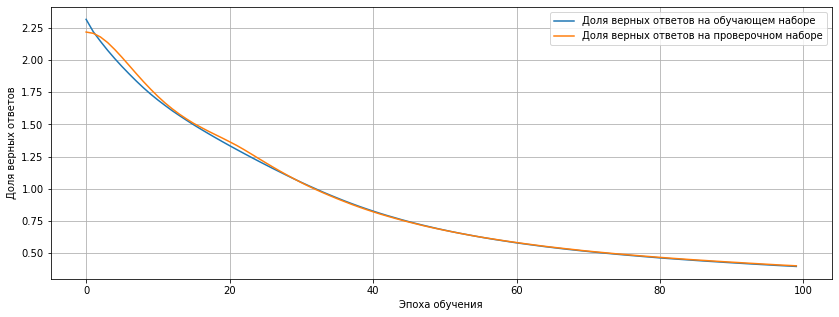

In [165]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyPSPnet_par.history['loss'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyPSPnet_par.history['val_loss'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [166]:
YpredPSPnet_par = modelPSPnet_par.predict([Xtest_pos, Xtest_case, Xtest_lang, Xtest_norms])
YpredPSPnet_par, Ytest_res_par, paragraphs_test_res_par = cleansed_data(YpredPSPnet_par, Ytest, paragraphs_test_2) # нехорошие данные здесь всё-таки подчищаем

Очищено фраз: 20


In [167]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest_res_par.argmax(axis=-1).flatten(), 
                            YpredPSPnet_par.argmax(axis=-1).flatten(), 
                            target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       1.00      0.96      0.98     46174
           термин       0.33      0.28      0.30       745
           связка       0.04      0.01      0.01       539
      определение       0.00      0.00      0.00      1641
      расшифровка       0.00      0.00      0.00      2022
     дубль-термин       0.03      0.86      0.05       183
     дубль-связка       0.00      0.02      0.00        62
дубль-определение       0.00      0.00      0.00       138
дубль-расшифровка       0.00      0.00      0.00        80

         accuracy                           0.87     51584
        macro avg       0.16      0.24      0.15     51584
     weighted avg       0.90      0.87      0.88     51584



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Проверка тестовой выборки (насколько хорошо обучена сеть)**

In [170]:
# выбираем конкретную фразу из тестовой выборки
i = 2 
print(f'{i + 1}.')
print(colorize_the_text(paragraphs_test_res[i], Ytest_res_par[i], 0, 'pre', sent_len))
print(colorize_the_text(paragraphs_test_res[i], YpredPSPnet_par[i], 0, 'pre', sent_len))

3.
 Ветвление — однократное выполнение одной из двух или более операций , в зависимости от выполнения заданного условия .
 Ветвление — однократное выполнение одной из двух или более операций , в зависимости от выполнения заданного условия .


In [ ]:
# воспроизводим все фразы из тестовой выборки
for i, el in enumerate(paragraphs_test_res_par):
  print(f'{i+1}.')
  print(colorize_the_text(el, Ytest_res_par[i], 0, 'pre', sent_len))
  print(colorize_the_text(el, YpredPSPnet_par[i], 0, 'pre', sent_len))

# На github не отображается расцветка текста
# Чтобы её посмотреть, воспользуйтесь ссылкой на https://colab.research.google.com/ выше

### **Recurrent neural network GRU**

#### Algorithm: Embedding + Bidirectional(GRU) + GRU , batch_size = 128, activation='softmax'

*Последовательная архитектура*

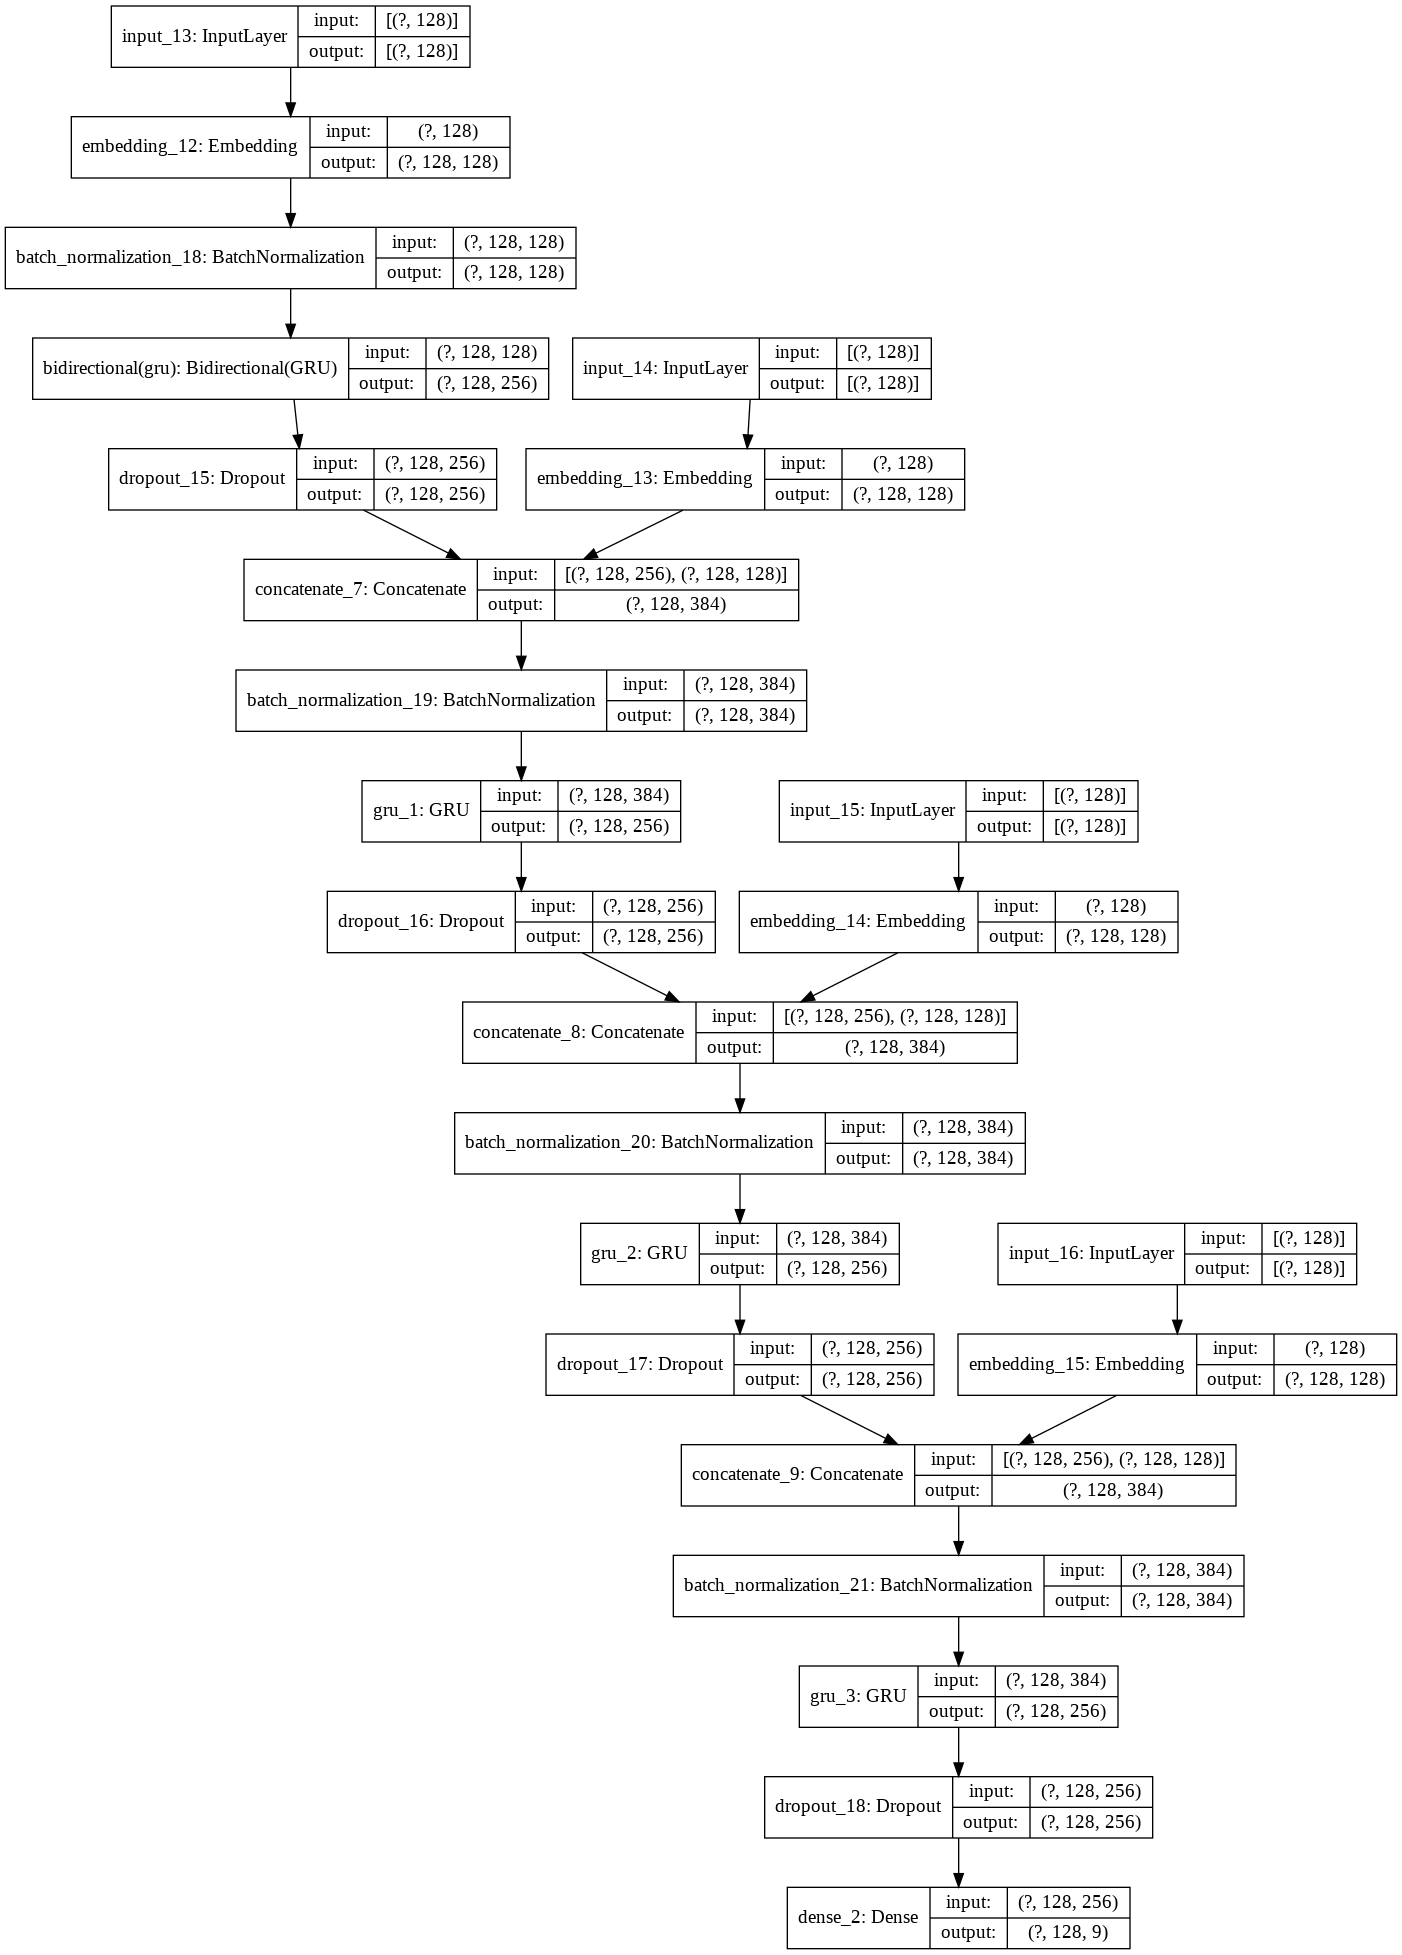

In [172]:
input_pos = Input((sent_len,))
x_pos = Embedding(num_words, emb_size)(input_pos)
x_pos = BatchNormalization()(x_pos)
x_pos = Bidirectional(GRU(emb_size, return_sequences=True))(x_pos)
x_pos = Dropout(0.2)(x_pos)

input_case = Input((sent_len,))
x_case = Embedding(num_words, emb_size)(input_case)

input_lang = Input((sent_len,))
x_lang = Embedding(num_words, emb_size)(input_lang)

input_norms = Input((sent_len,))
x_norms = Embedding(num_words, emb_size)(input_norms)

x = concatenate([x_pos, x_case])
x = BatchNormalization()(x)
x = GRU(emb_size * 2, return_sequences=True)(x)
x = Dropout(0.2)(x)

x = concatenate([x, x_lang])
x = BatchNormalization()(x)
x = GRU(emb_size * 2, return_sequences=True)(x)
x = Dropout(0.2)(x)

x = concatenate([x, x_norms])
x = BatchNormalization()(x)
x = GRU(emb_size * 2, return_sequences=True)(x)
x = Dropout(0.2)(x)

output = Dense(colors_count, activation='softmax')(x)

modelEGRU = Model(inputs=[input_pos, input_case, input_lang, input_norms], outputs=output)

modelEGRU.compile(loss='categorical_crossentropy', optimizer='adam')
# modelEGRU.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=[dice_coef, AUC(num_thresholds=150)])

plot_model(modelEGRU, show_shapes=True)

In [ ]:
historyEGRU = modelEGRU.fit(x=[Xtrain_pos, Xtrain_case, Xtrain_lang, Xtrain_norms], y=Ytrain,
                            epochs=100, batch_size=128,
                            validation_data=([Xtest_pos, Xtest_case, Xtest_lang, Xtest_norms], Ytest))
                    
modelEGRU.save( '/content/drive/My Drive/tmp/modelEGRU_consistent(production).h5' )

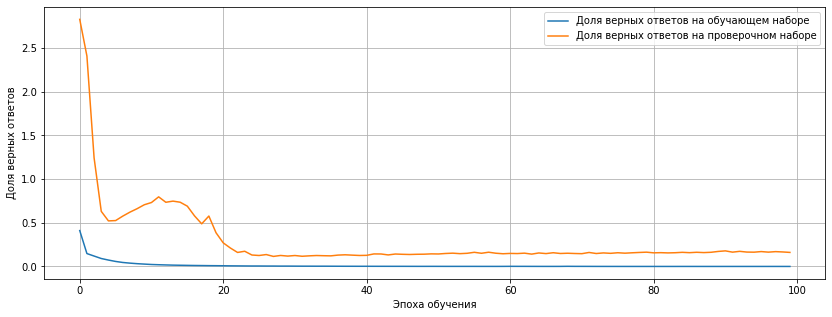

In [174]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyEGRU.history['loss'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyEGRU.history['val_loss'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

**Проверка тренировочной выборки (насколько хорошо выучены примеры)**

In [175]:
YpredEGRU_train = modelEGRU.predict([Xtrain_pos, Xtrain_case, Xtrain_lang, Xtrain_norms])

In [ ]:
for i, el in enumerate(paragraphs_train):
  print(f'{i+1}.')
  print(colorize_the_text(el, Ytrain[i], 0, 'pre', sent_len))
  print(colorize_the_text(el, YpredEGRU_train[i], 0, 'pre', sent_len))

*Чтобы память не забивать, результат 100%-го совпадения предсказаний с разметкой обучающей выборки удалён из текста*

**Проверка тестовой выборки (насколько хорошо обучена сеть)**

In [177]:
YpredEGRU_test = modelEGRU.predict([Xtest_pos, Xtest_case, Xtest_lang, Xtest_norms])
YpredEGRU_test, Ytest_res, paragraphs_test_res = cleansed_data(YpredEGRU_test, Ytest, paragraphs_test_2) # нехорошие данные здесь всё-таки подчищаем

Очищено фраз: 34


In [178]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest_res.argmax(axis=-1).flatten(), 
                            YpredEGRU_test.argmax(axis=-1).flatten(), 
                            target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.99      0.99      0.99     44302
           термин       0.91      0.84      0.88       764
           связка       0.95      0.93      0.94       548
      определение       0.90      0.88      0.89      1677
      расшифровка       0.85      0.83      0.84      2025
     дубль-термин       0.63      0.63      0.63       184
     дубль-связка       0.54      0.34      0.42        65
дубль-определение       0.50      0.35      0.41       147
дубль-расшифровка       0.38      0.04      0.07        80

         accuracy                           0.98     49792
        macro avg       0.74      0.65      0.67     49792
     weighted avg       0.97      0.98      0.97     49792



In [179]:
# выбираем конкретную фразу из тестовой выборки
i = 254 - 1
print(f'{i}.')
print(colorize_the_text(paragraphs_test_res[i], Ytest_res[i], 0, 'pre', sent_len))
print(colorize_the_text(paragraphs_test_res[i], YpredEGRU_test[i], 0, 'pre', sent_len))

253.
 Окружность диаметра AB — это фигура , состоящая из точек A , B и всех точек плоскости , из которых отрезок AB виден под прямым углом ( Определение через угол , опирающийся на диаметр окружности ) .
 Окружность диаметра AB — это фигура , состоящая из точек A , B и всех точек плоскости , из которых отрезок AB виден под прямым углом ( Определение через угол , опирающийся на диаметр окружности ) .


In [180]:
# воспроизводим все фразы из тестовой выборки
for i, el in enumerate(paragraphs_test_res):
  print(f'{i+1}.')
  print(colorize_the_text(el, Ytest_res[i], 0, 'pre', sent_len))
  print(colorize_the_text(el, YpredEGRU_test[i], 0, 'pre', sent_len))

# На github не отображается расцветка текста
# Чтобы её посмотреть, воспользуйтесь ссылкой на https://colab.research.google.com/

1.
 Свойство — необходимое условие принадлежности классу .
 Свойство — необходимое условие принадлежности классу .
2.
 Парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее понятие .
 Парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее понятие .
3.
 Ветвление — однократное выполнение одной из двух или более операций , в зависимости от выполнения заданного условия .
 Ветвление — однократное выполнение одной из двух или более операций , в зависимости от выполнения заданного условия .
4.
 Локальные переменные – это переменные , объявленные внутри любого блока программы .
 Локальные пере

#### Algorithm: Embedding + Bidirectional(GRU) + GRU , batch_size = 128, activation='softmax'

*Параллельная архитектура*

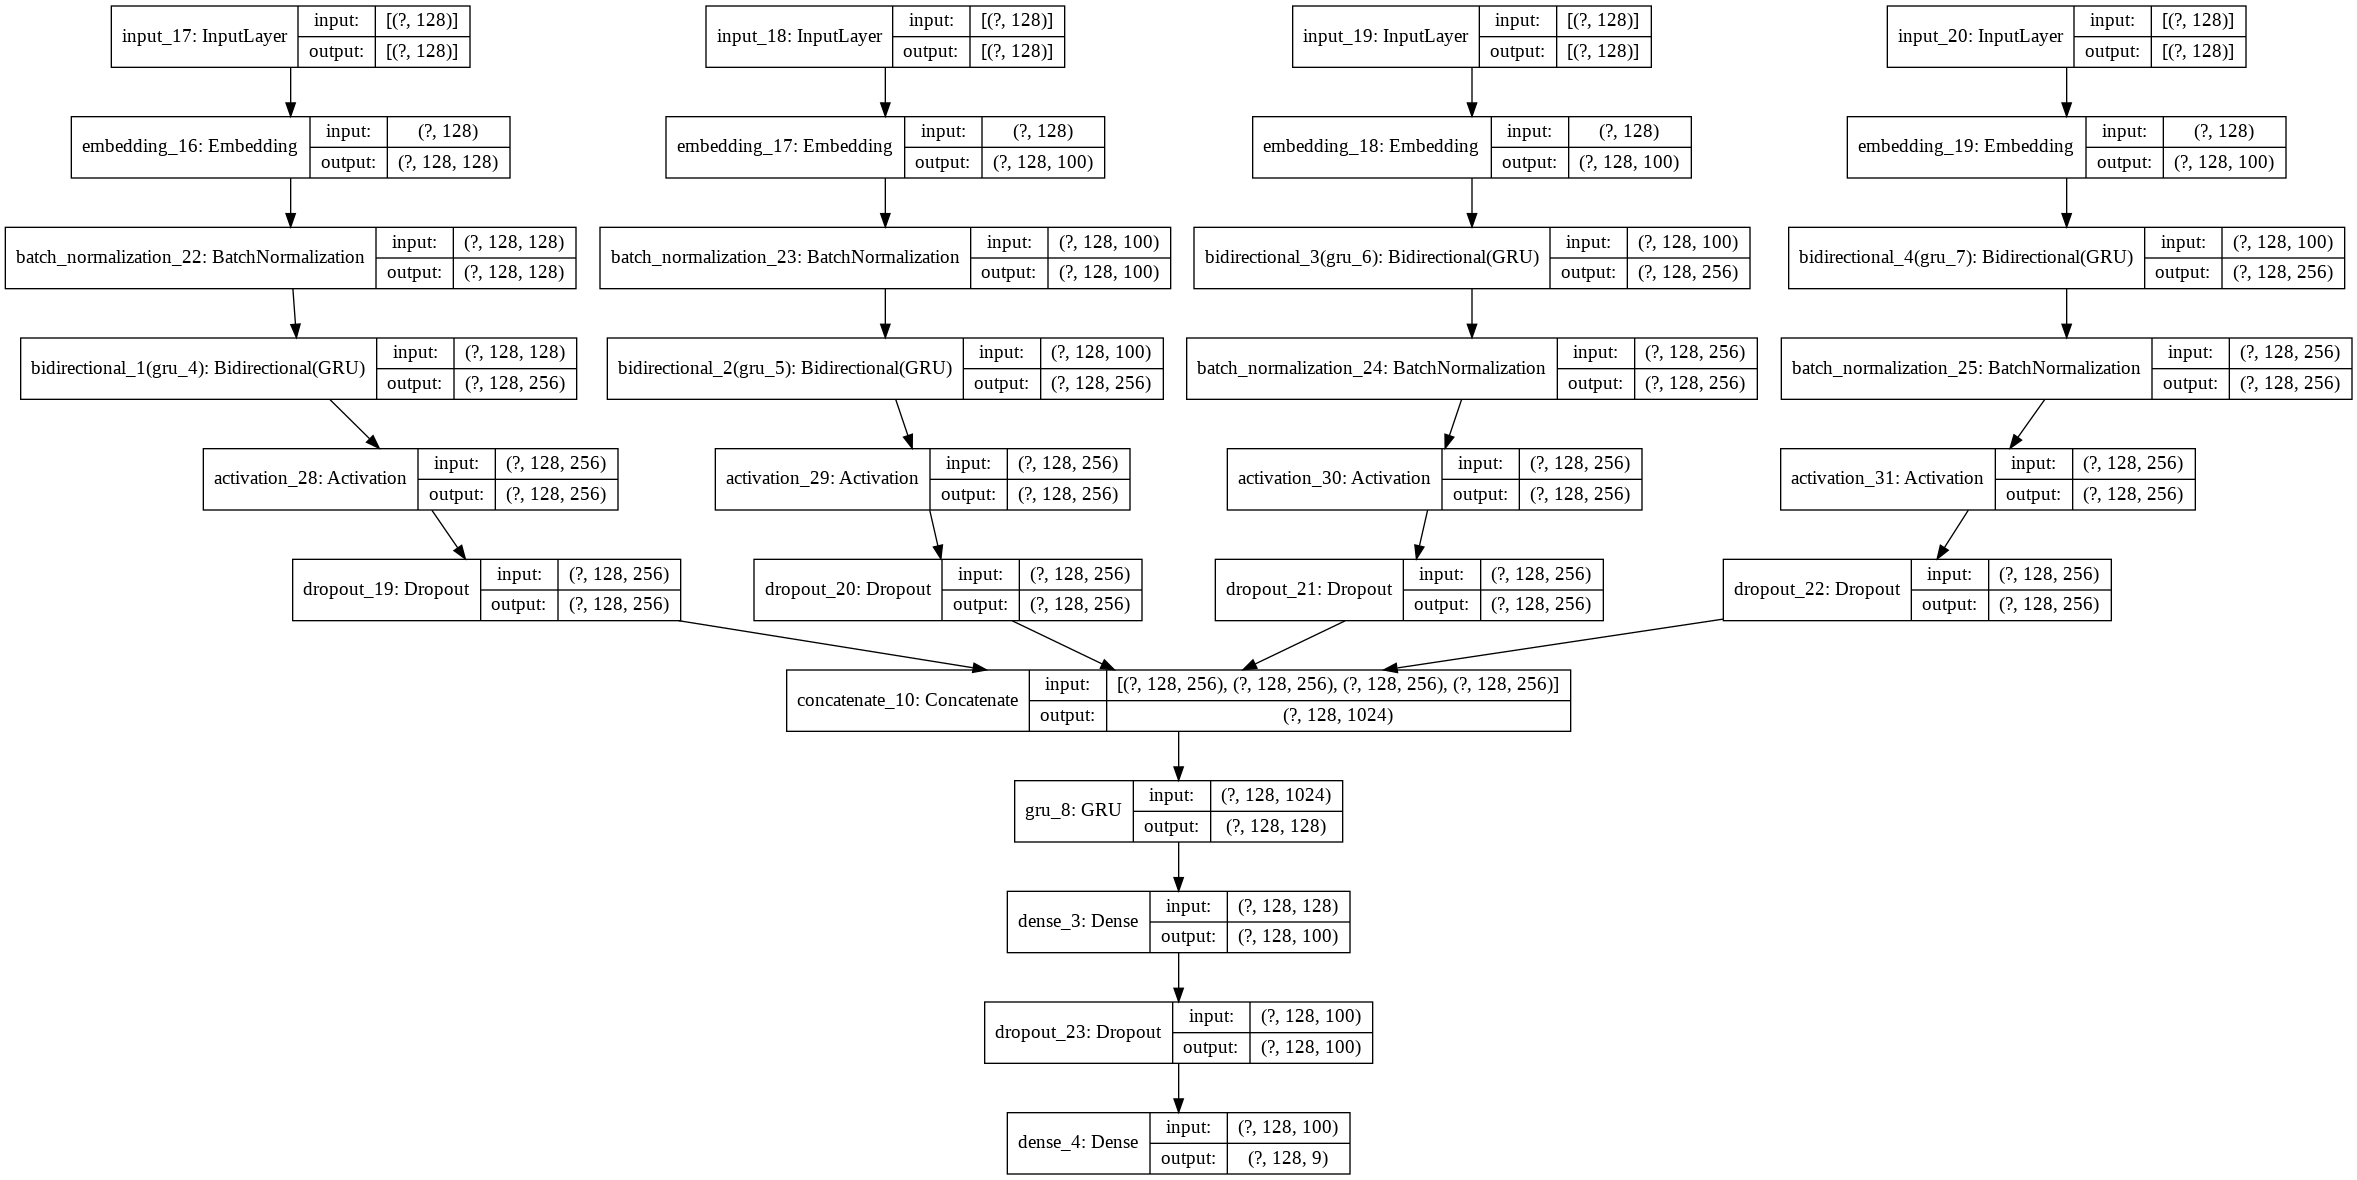

In [181]:
# параллельная архитектура
input_pos = Input((sent_len,))
x_pos = Embedding(num_words, emb_size)(input_pos)
x_pos = BatchNormalization()(x_pos)
x_pos = Bidirectional(GRU(emb_size, return_sequences=True))(x_pos)
x_pos = Activation('relu')(x_pos)
x_pos = Dropout(0.2)(x_pos)

input_case = Input((sent_len,))
x_case = Embedding(num_words, embedding_size)(input_case)
x_case = BatchNormalization()(x_case)
x_case = Bidirectional(GRU(emb_size, return_sequences=True))(x_case)
x_case = Activation('relu')(x_case)
x_case = Dropout(0.2)(x_case)

input_lang = Input((sent_len,))
x_lang = Embedding(num_words, embedding_size)(input_lang)
x_lang = Bidirectional(GRU(emb_size, return_sequences=True))(x_lang)
x_lang = BatchNormalization()(x_lang)
x_lang = Activation('relu')(x_lang)
x_lang = Dropout(0.2)(x_lang)

input_norms = Input((sent_len,))
x_norms = Embedding(num_words, embedding_size)(input_norms)
x_norms = Bidirectional(GRU(emb_size, return_sequences=True))(x_norms)
x_norms = BatchNormalization()(x_norms)
x_norms = Activation('relu')(x_norms)
x_norms = Dropout(0.2)(x_norms)

x = concatenate([x_pos, x_case, x_lang, x_norms])

x = GRU(emb_size, return_sequences=True)(x)
# x = BatchNormalization()(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.2)(x)

output = Dense(colors_count, activation='softmax')(x)

modelEGRUpar = Model(inputs=[input_pos, input_case, input_lang, input_norms], outputs=output)

modelEGRUpar.compile(loss='categorical_crossentropy', optimizer='adam')
# modelEGRUpar.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=[dice_coef, AUC(num_thresholds=150)])

plot_model(modelEGRUpar, show_shapes=True)

In [ ]:
historyEGRUpar = modelEGRUpar.fit(x=[Xtrain_pos, Xtrain_case, Xtrain_lang, Xtrain_norms], y=Ytrain,
                            epochs=100, batch_size=128,
                            validation_data=([Xtest_pos, Xtest_case, Xtest_lang, Xtest_norms], Ytest))
                    
modelEGRUpar.save( '/content/drive/My Drive/tmp/modelEGRU_parallel(production).h5' )

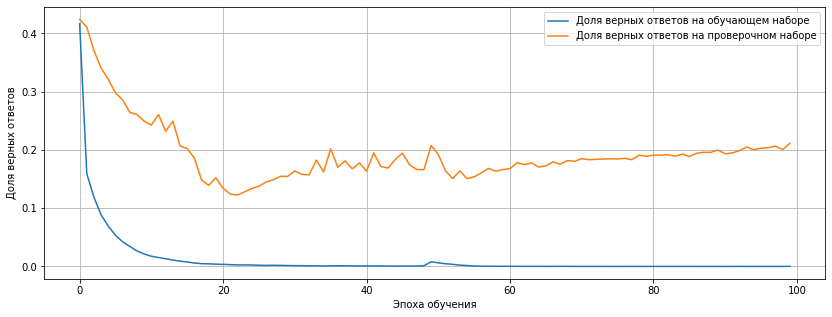

In [183]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyEGRUpar.history['loss'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyEGRUpar.history['val_loss'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

**Проверка тренировочной выборки (насколько хорошо выучены примеры)**

In [ ]:
YpredEGRU_train_par = modelEGRUpar.predict([Xtrain_pos, Xtrain_case, Xtrain_lang, Xtrain_norms])

In [ ]:
for i, el in enumerate(paragraphs_train):
  print(f'{i+1}.')
  print(colorize_the_text(el, Ytrain[i], 0, 'pre', sent_len))
  print(colorize_the_text(el, YpredEGRU_train_par[i], 0, 'pre', sent_len))

*Чтобы память не забивать, результат 100%-го совпадения предсказаний с разметкой обучающей выборки удалён из текста*

**Проверка тестовой выборки (насколько хорошо обучена сеть)**

In [184]:
YpredEGRU_test_par = modelEGRUpar.predict([Xtest_pos, Xtest_case, Xtest_lang, Xtest_norms])
YpredEGRU_test_par, Ytest_par_res, paragraphs_test_par_res = cleansed_data(YpredEGRU_test_par, Ytest, paragraphs_test_2) # нехорошие данные здесь всё-таки подчищаем

Очищено фраз: 35


In [187]:
# Встроенная функция sklearn возвращает и точность и полноту по классам 
print(classification_report(Ytest_par_res.argmax(axis=-1).flatten(), 
                            YpredEGRU_test_par.argmax(axis=-1).flatten(), 
                            target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.99      0.99      0.99     44236
           термин       0.92      0.87      0.89       767
           связка       0.91      0.97      0.94       541
      определение       0.83      0.91      0.87      1659
      расшифровка       0.89      0.75      0.81      1991
     дубль-термин       0.72      0.69      0.70       182
     дубль-связка       0.62      0.33      0.43        63
дубль-определение       0.54      0.36      0.43       145
дубль-расшифровка       0.22      0.03      0.04        80

         accuracy                           0.97     49664
        macro avg       0.74      0.66      0.68     49664
     weighted avg       0.97      0.97      0.97     49664



In [185]:
# выбираем конкретную фразу из тестовой выборки
i = 2 - 1
print(f'{i}.')
print(colorize_the_text(paragraphs_test_par_res[i], Ytest_par_res[i], 0, 'pre', sent_len))
print(colorize_the_text(paragraphs_test_par_res[i], YpredEGRU_test_par[i], 0, 'pre', sent_len))

1.
 Парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее понятие .
 Парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее понятие .


In [186]:
# воспроизводим все фразы из тестовой выборки
for i, el in enumerate(paragraphs_test_par_res):
  print(f'{i+1}.')
  print(colorize_the_text(el, Ytest_par_res[i], 0, 'pre', sent_len))
  print(colorize_the_text(el, YpredEGRU_test_par[i], 0, 'pre', sent_len))

# На github не отображается расцветка текста
# Чтобы её посмотреть, воспользуйтесь ссылкой на https://colab.research.google.com/

1.
 Свойство — необходимое условие принадлежности классу .
 Свойство — необходимое условие принадлежности классу .
2.
 Парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее понятие .
 Парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее понятие .
3.
 Ветвление — однократное выполнение одной из двух или более операций , в зависимости от выполнения заданного условия .
 Ветвление — однократное выполнение одной из двух или более операций , в зависимости от выполнения заданного условия .
4.
 Локальные переменные – это переменные , объявленные внутри любого блока программы .
 Локальные пере

### **One-dimensional convolution**

#### Алгоритм: Embedding + Conv1D , batch_size = 16, activation='softmax'

*Последовательная архитектура*

In [188]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов для рапознавания
    - sentence_len - длина предложения
    - num_words - количество слов в словаре
    - embedding_size - длина эмбединга
'''
def pseudoLinearSegmentationNet(
      num_classes = 9,
      sentence_len = 200,
      num_words = 5000,
      activation_function = 'softmax',
      embedding_size = 500
      ):
    input_pos = Input((sentence_len,))
    x_pos = Embedding(num_words, embedding_size)(input_pos)
    x_pos = Conv1D(64, 3, padding='same', name='input1_conv1')(x_pos)
    x_pos = BatchNormalization()(x_pos)
    x_pos = Activation('relu')(x_pos)

    input_case = Input((sentence_len,))
    x_case = Embedding(num_words, embedding_size)(input_case)

    input_lang = Input((sentence_len,))
    x_lang = Embedding(num_words, embedding_size)(input_lang)

    input_norms = Input((sentence_len,))
    x_norms = Embedding(num_words, embedding_size)(input_norms)

    x = concatenate([x_pos, x_case])
    x = Conv1D(128, 5, padding='same', name='input2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, x_lang])
    x = Conv1D(128, 5, padding='same', name='input3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, x_norms])
    x = Conv1D(128, 5, padding='same', name='input4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = LSTM(128, return_sequences=True)(x)
    x = SpatialDropout1D(0.2)(x)
    # x = BatchNormalization()(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.2)(x)

    # x = Dropout(0.2)(x)
    output = Conv1D(num_classes,3, activation=activation_function, padding='same')(x)

    model = Model(inputs=[input_pos, input_case, input_lang, input_norms], outputs=output)

    model.compile(optimizer='rmsprop', 
                  loss='categorical_crossentropy')

    return model # Возвращаем сформированную модель

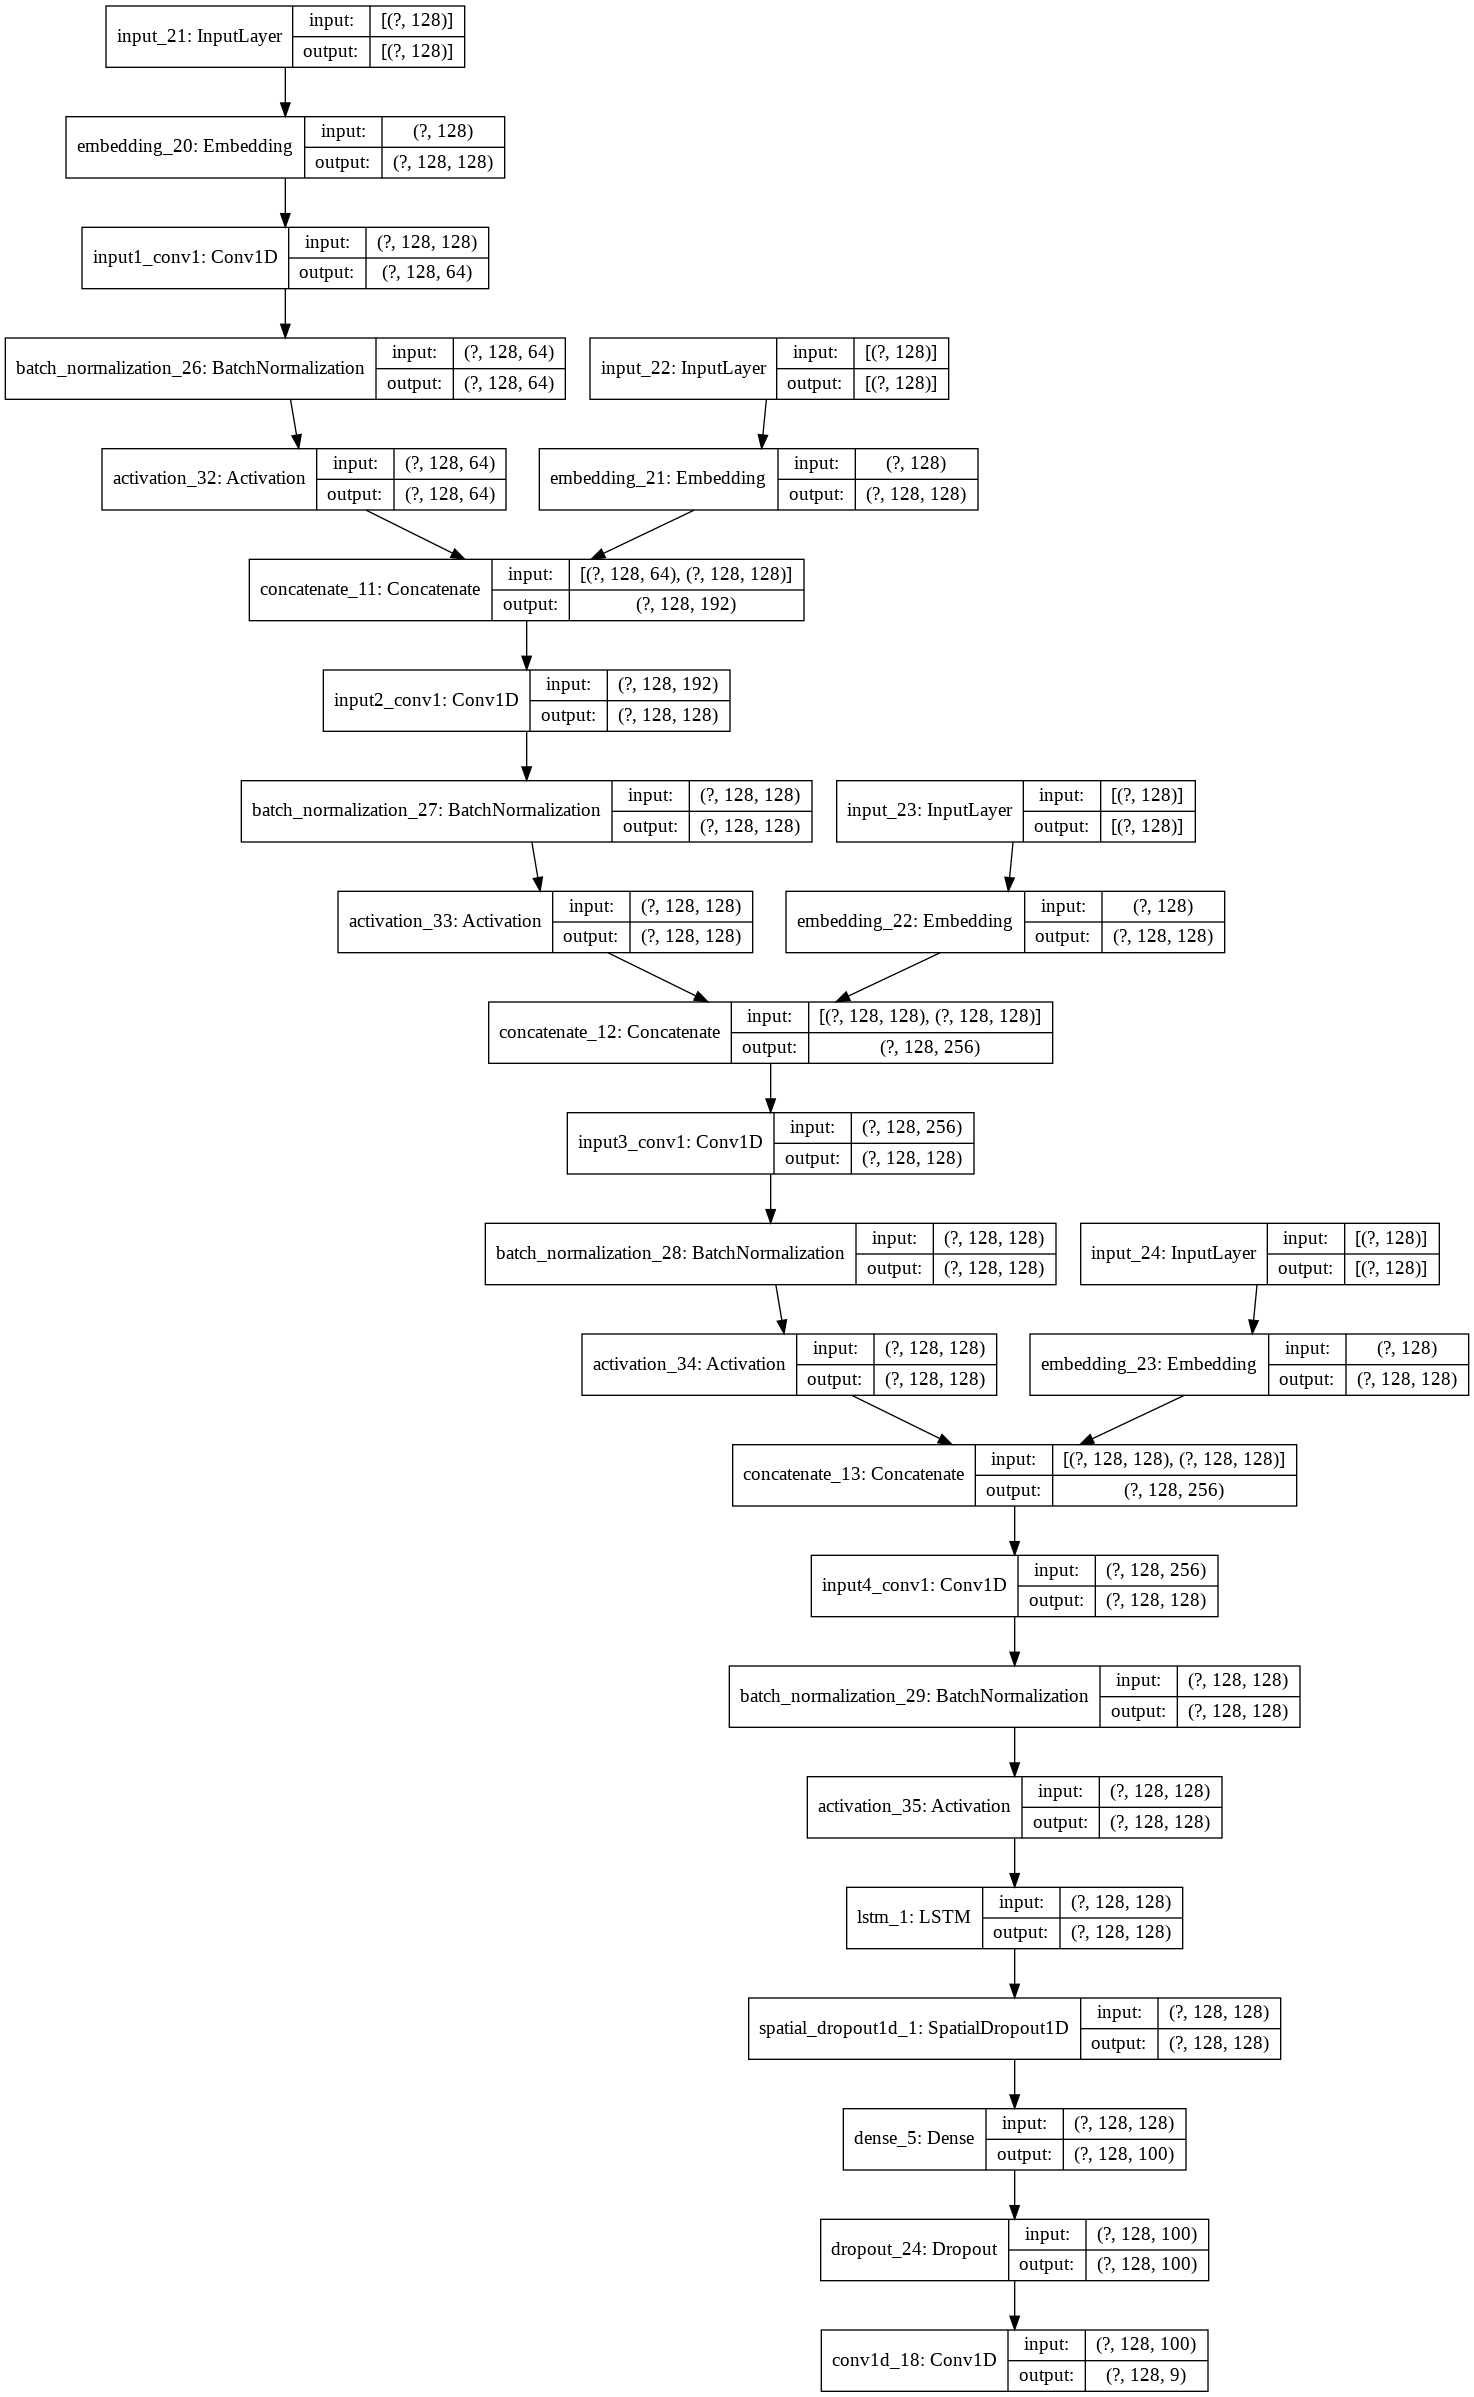

In [189]:
modelL = pseudoLinearSegmentationNet(colors_count, sent_len, num_words, 'softmax', emb_size) # Создаем модель linearSegmentationNet
plot_model(modelL, show_shapes=True)

In [ ]:
historyL = modelL.fit(x=[Xtrain_pos, Xtrain_case, Xtrain_lang, Xtrain_norms], y=Ytrain, 
                      epochs=100, batch_size=64,
                      validation_data=([Xtest_pos, Xtest_case, Xtest_lang, Xtest_norms], Ytest)) # Обучаем модель на выборке по всем классам
modelL.save( '/content/drive/My Drive/tmp/modelL_consistent(production).h5' )

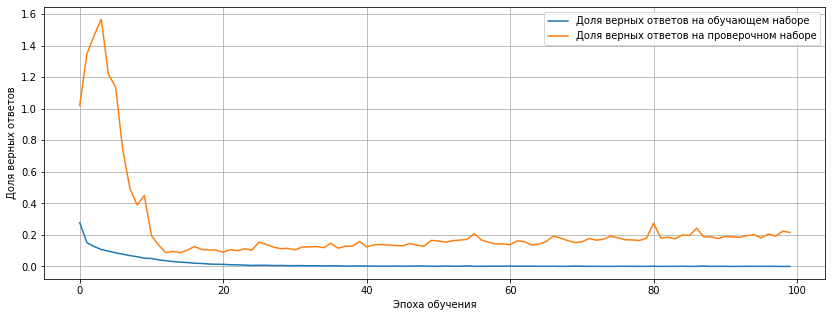

In [191]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyL.history['loss'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyL.history['val_loss'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [192]:
YpredL_test = modelL.predict([Xtest_pos, Xtest_case, Xtest_lang, Xtest_norms])
YpredL_test, Ytest_res, paragraphs_test_res = cleansed_data(YpredL_test, Ytest, paragraphs_test_2) # нехорошие данные здесь всё-таки подчищаем

Очищено фраз: 38


In [193]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest_res.argmax(axis=-1).flatten(), 
                            YpredL_test.argmax(axis=-1).flatten(), 
                            target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.99      0.99      0.99     43856
           термин       0.91      0.89      0.90       755
           связка       0.92      0.96      0.94       541
      определение       0.91      0.91      0.91      1675
      расшифровка       0.88      0.89      0.89      1977
     дубль-термин       0.60      0.71      0.65       184
     дубль-связка       0.76      0.43      0.55        65
дубль-определение       0.62      0.48      0.54       147
дубль-расшифровка       0.72      0.39      0.50        80

         accuracy                           0.98     49280
        macro avg       0.81      0.74      0.76     49280
     weighted avg       0.98      0.98      0.98     49280



**Проверка тестовой выборки (насколько хорошо обучена сеть)**

In [194]:
# выбираем конкретную фразу из тестовой выборки
i = 2 - 1
print(f'{i}.')
print(colorize_the_text(paragraphs_test_res[i], Ytest_res[i], 0, 'pre', sent_len))
print(colorize_the_text(paragraphs_test_res[i], YpredL_test[i], 0, 'pre', sent_len))

1.
 Парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее понятие .
 Парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее понятие .


In [195]:
# воспроизводим все фразы из тестовой выборки
for i, el in enumerate(paragraphs_test_res):
  print(f'{i+1}.')
  print(colorize_the_text(el, Ytest_res[i], 0, 'pre', sent_len))
  print(colorize_the_text(el, YpredL_test[i], 0, 'pre', sent_len))

# На github не отображается расцветка текста
# Чтобы её посмотреть, воспользуйтесь ссылкой на https://colab.research.google.com/

1.
 Свойство — необходимое условие принадлежности классу .
 Свойство — необходимое условие принадлежности классу .
2.
 Парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее понятие .
 Парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее понятие .
3.
 Ветвление — однократное выполнение одной из двух или более операций , в зависимости от выполнения заданного условия .
 Ветвление — однократное выполнение одной из двух или более операций , в зависимости от выполнения заданного условия .
4.
 Локальные переменные – это переменные , объявленные внутри любого блока программы .
 Локальные пере

#### Алгоритм: Embedding + Conv1D , batch_size = 16, activation='softmax'

*Параллельная архитектура*

In [199]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов для рапознавания
    - sentence_len - длина предложения
    - num_words - количество слов в словаре
    - embedding_size - длина эмбединга
'''
def pseudoLinearSegmentationNet_par(
      num_classes = 9,
      sentence_len = 200,
      num_words = 5000,
      activation_function = 'softmax',
      embedding_size = 500
      ):
    input_pos = Input((sentence_len,))
    x_pos = Embedding(num_words, embedding_size)(input_pos)
    x_pos = Conv1D(64, 3, padding='same', name='input1_conv1')(x_pos)
    x_pos = BatchNormalization()(x_pos)
    x_pos = Activation('relu')(x_pos)
    x_pos = Dropout(0.2)(x_pos)

    input_case = Input((sentence_len,))
    x_case = Embedding(num_words, embedding_size)(input_case)
    x_case = Conv1D(64, 3, padding='same', name='input2_conv1')(x_case)
    x_case = BatchNormalization()(x_case)
    x_case = Activation('relu')(x_case)
    x_case = Dropout(0.2)(x_case)

    input_lang = Input((sentence_len,))
    x_lang = Embedding(num_words, embedding_size)(input_lang)
    x_lang = Conv1D(64, 3, padding='same', name='input3_conv1')(x_lang)
    x_lang = BatchNormalization()(x_lang)
    x_lang = Activation('relu')(x_lang)
    x_lang = Dropout(0.2)(x_lang)

    input_norms = Input((sentence_len,))
    x_norms = Embedding(num_words, embedding_size)(input_norms)
    x_norms = Conv1D(64, 3, padding='same', name='input4_conv1')(x_norms)
    x_norms = BatchNormalization()(x_norms)
    x_norms = Activation('relu')(x_norms)
    x_norms = Dropout(0.2)(x_norms)

    x = concatenate([x_pos, x_case, x_lang, x_norms])

    x = LSTM(128, return_sequences=True)(x)
    x = SpatialDropout1D(0.2)(x)
    # x = BatchNormalization()(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.2)(x)

    # x = Dropout(0.2)(x)
    output = Conv1D(num_classes,3, activation=activation_function, padding='same')(x)

    model = Model(inputs=[input_pos, input_case, input_lang, input_norms], outputs=output)

    model.compile(optimizer='rmsprop', 
                  loss='categorical_crossentropy')

    return model # Возвращаем сформированную модель

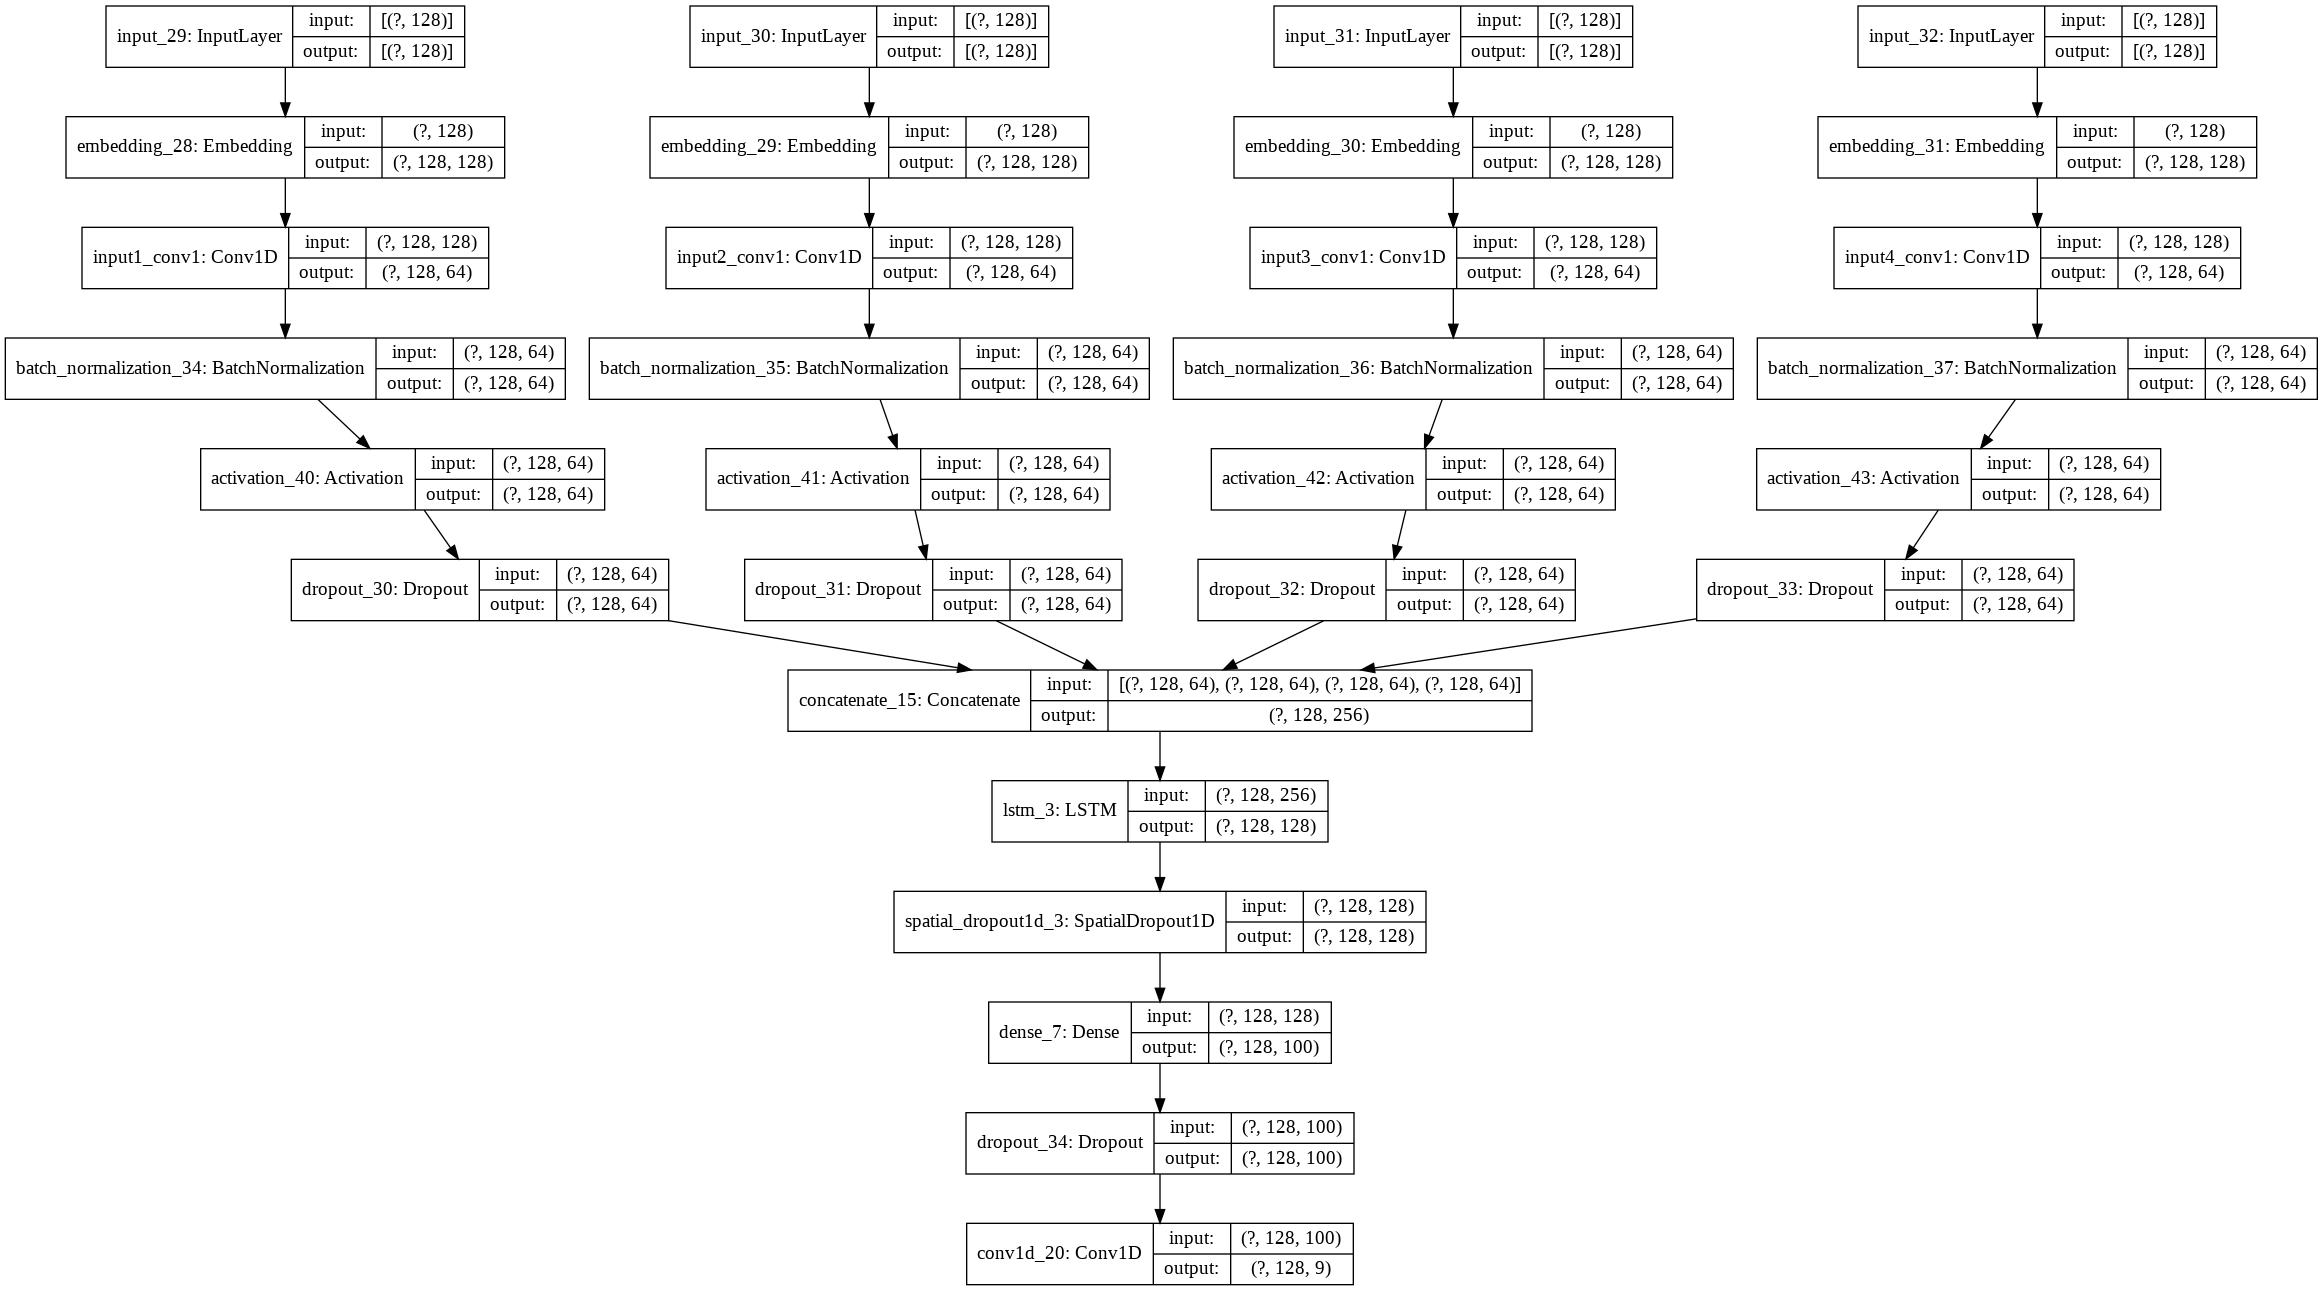

In [200]:
modelL_par = pseudoLinearSegmentationNet_par(colors_count, sent_len, num_words, 'softmax', emb_size) # Создаем модель linearSegmentationNet
plot_model(modelL_par, show_shapes=True)

In [ ]:
historyL_par = modelL_par.fit(x=[Xtrain_pos, Xtrain_case, Xtrain_lang, Xtrain_norms], y=Ytrain, 
                      epochs=100, batch_size=64,
                      validation_data=([Xtest_pos, Xtest_case, Xtest_lang, Xtest_norms], Ytest)) # Обучаем модель на выборке по всем классам

modelL_par.save( '/content/drive/My Drive/tmp/modelL_parallel(production).h5' )

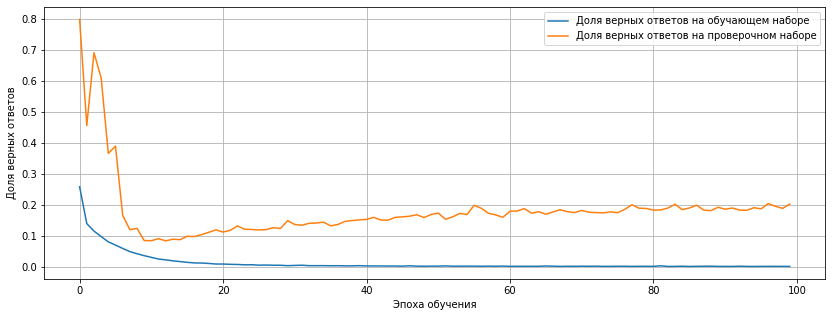

In [202]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyL_par.history['loss'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyL_par.history['val_loss'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [203]:
YpredL_par = modelL_par.predict([Xtest_pos, Xtest_case, Xtest_lang, Xtest_norms])
YpredL_par, Ytest_par_res, paragraphs_par_test_res = cleansed_data(YpredL_par, Ytest, paragraphs_test_2) # нехорошие данные здесь всё-таки подчищаем


Очищено фраз: 30


In [204]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest_par_res.argmax(axis=-1).flatten(), 
                            YpredL_par.argmax(axis=-1).flatten(), 
                            target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.99      1.00      0.99     44814
           термин       0.93      0.86      0.89       773
           связка       0.93      0.96      0.94       555
      определение       0.91      0.90      0.91      1678
      расшифровка       0.92      0.83      0.87      2004
     дубль-термин       0.53      0.74      0.62       188
     дубль-связка       0.41      0.43      0.42        65
дубль-определение       0.45      0.50      0.47       147
дубль-расшифровка       0.50      0.14      0.22        80

         accuracy                           0.98     50304
        macro avg       0.73      0.71      0.70     50304
     weighted avg       0.98      0.98      0.98     50304



**Проверка тестовой выборки (насколько хорошо обучена сеть)**

In [205]:
# выбираем конкретную фразу из тестовой выборки
i = 2 - 1
print(f'{i}.')
print(colorize_the_text(paragraphs_par_test_res[i], Ytest_par_res[i], 0, 'pre', sent_len))
print(colorize_the_text(paragraphs_par_test_res[i], YpredL_par[i], 0, 'pre', sent_len))

1.
 Парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее понятие .
 Парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее понятие .


In [206]:
# воспроизводим все фразы из тестовой выборки
for i, el in enumerate(paragraphs_par_test_res):
  print(f'{i+1}.')
  print(colorize_the_text(el, Ytest_par_res[i], 0, 'pre', sent_len))
  print(colorize_the_text(el, YpredL_par[i], 0, 'pre', sent_len))

# На github не отображается расцветка текста
# Чтобы её посмотреть, воспользуйтесь ссылкой на https://colab.research.google.com/

1.
 Свойство — необходимое условие принадлежности классу .
 Свойство — необходимое условие принадлежности классу .
2.
 Парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее понятие .
 Парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее понятие .
3.
 Ветвление — однократное выполнение одной из двух или более операций , в зависимости от выполнения заданного условия .
 Ветвление — однократное выполнение одной из двух или более операций , в зависимости от выполнения заданного условия .
4.
 Локальные переменные – это переменные , объявленные внутри любого блока программы .
 Локальные пере

### **U-net**

#### U-net classic

*Последовательная архитектура*



In [208]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - sentence_len - длина предложения
    - num_words - количество слов в словаре
    - embedding_size - длина эмбединга
'''

def unet(
      num_classes = 6,
      sentence_len = 200,
      num_words = 5000,
      activation_function = 'softmax',
      embedding_size = 50
      ):
    input_pos = Input((sentence_len,))
    x_pos = Embedding(num_words, embedding_size)(input_pos)
    x_pos = Conv1D(64, 3, padding='same', name='input1_conv1')(x_pos)
    x_pos = BatchNormalization()(x_pos)
    x_pos = Activation('relu')(x_pos)

    input_case = Input((sentence_len,))
    x_case = Embedding(num_words, embedding_size)(input_case)

    input_lang = Input((sentence_len,))
    x_lang = Embedding(num_words, embedding_size)(input_lang)

    input_norms = Input((sentence_len,))
    x_norms = Embedding(num_words, embedding_size)(input_norms)

    x = concatenate([x_pos, x_case])
    x = Conv1D(128, 5, padding='same', name='input2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, x_lang])
    x = Conv1D(128, 5, padding='same', name='input3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, x_norms])
    x = Conv1D(128, 5, padding='same', name='input4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # Block 1
    x = Conv1D(64, 3, padding='same', name='block1_conv1')(x) # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same', name='block1_conv2')(x)         # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling1D()(block_1_out)                                        # Добавляем слой MaxPooling1D

    # Block 2
    x = Conv1D(128, 3, padding='same', name='block2_conv1')(x)        # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(128, 3, padding='same', name='block2_conv2')(x)        # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling1D()(block_2_out)                                        # Добавляем слой MaxPooling1D

    # Block 3
    x = Conv1D(256, 3, padding='same', name='block3_conv1')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same', name='block3_conv2')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same', name='block3_conv3')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling1D()(block_3_out)                                        # Добавляем слой MaxPooling1D

    # Block 4
    x = Conv1D(512, 3, padding='same', name='block4_conv1')(x)        # Добавляем Conv1D-слой с 512-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block4_conv2')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block4_conv3')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    # UP 2
    # x = Conv1DTranspose(x, 256, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 256 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(256, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                      # Объединем текущий слой со слоем block_3_out
    x = Conv1D(256, 3, padding='same')(x)                             # Добавляем слой Conv1D с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 3
    # x = Conv1DTranspose(x, 128, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 128 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(128, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                      # Объединем текущий слой со слоем block_2_out
    x = Conv1D(128, 3, padding='same')(x)                             # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(128, 3, padding='same')(x) # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    # UP 4
    # x = Conv1DTranspose(x, 64, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 64 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(64, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = concatenate([x, block_1_out])  # Объединем текущий слой со слоем block_1_out
    x = Conv1D(64, 3, padding='same')(x) # Добавляем слой Conv1D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same')(x) # Добавляем слой Conv1D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv1D(num_classes, 3, activation='softmax', padding='same')(x)  # Добавляем Conv1D-Слой с softmax-активацией на num_classes-нейронов

    model = Model([input_pos, input_case, input_lang, input_norms], x)                                   # Создаем модель со входами и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy')
    
    return model # Возвращаем сформированную модель

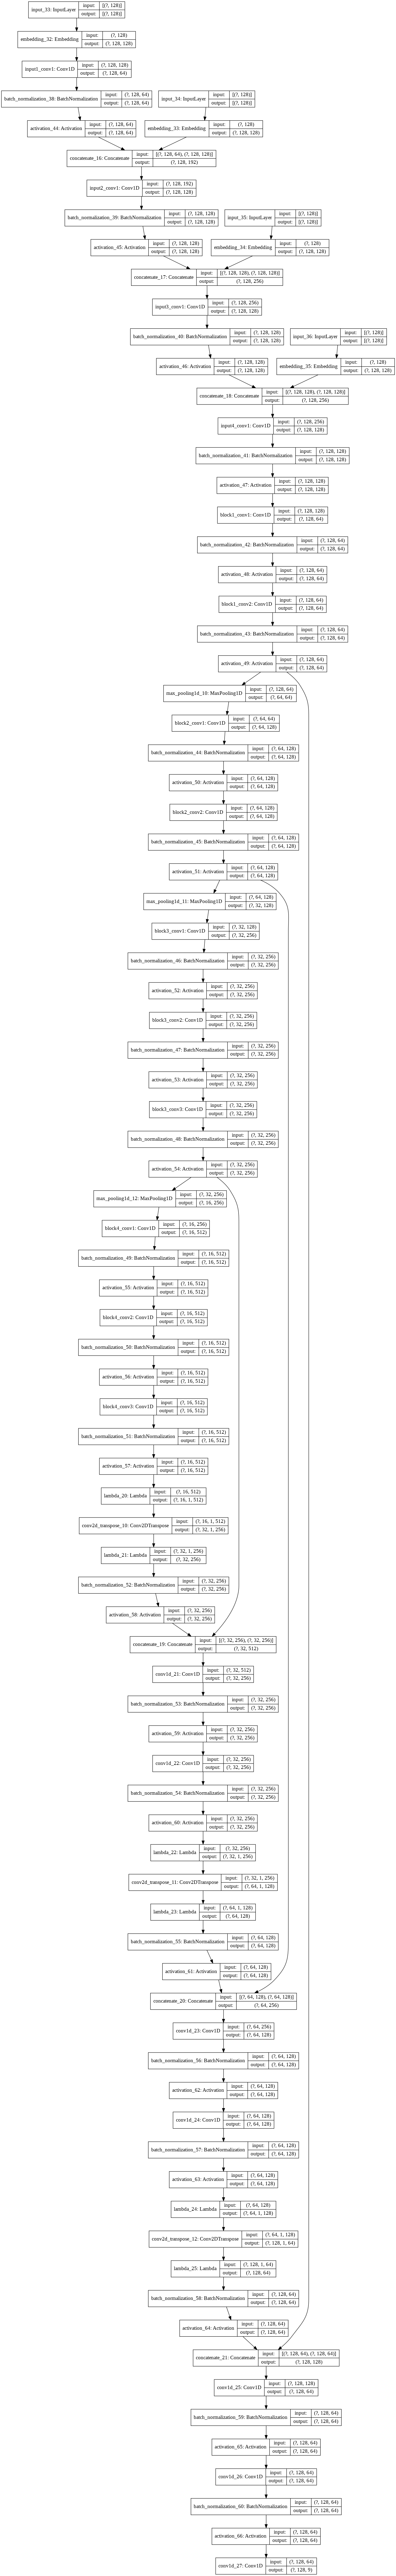

In [209]:
modelUnet = unet(colors_count, sent_len, num_words, 'softmax', emb_size) # Создаем модель unet
plot_model(modelUnet, show_shapes=True)

In [ ]:
historyUnet = modelUnet.fit(x=[Xtrain_pos, Xtrain_case, Xtrain_lang, Xtrain_norms], y=Ytrain, 
                            epochs=100, batch_size=64,
                            validation_data=([Xtest_pos, Xtest_case, Xtest_lang, Xtest_norms], Ytest))                    
modelUnet.save( '/content/drive/My Drive/tmp/modelUnet_consistent(production).h5' )

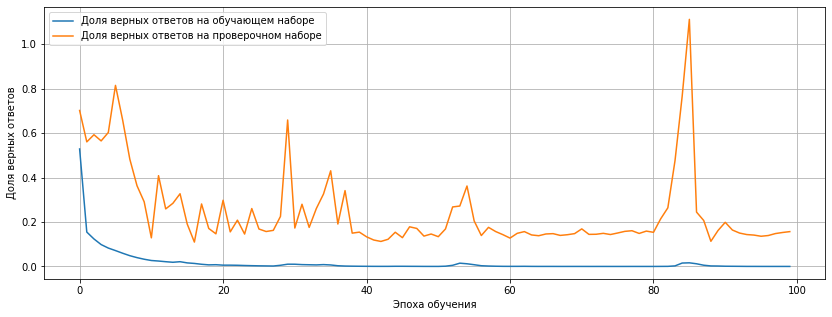

In [211]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyUnet.history['loss'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyUnet.history['val_loss'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [212]:
YpredUnet = modelUnet.predict([Xtest_pos, Xtest_case, Xtest_lang, Xtest_norms])
YpredUnet_test, Ytest_res, paragraphs_test_res = cleansed_data(YpredUnet, Ytest, paragraphs_test_2) # нехорошие данные здесь всё-таки подчищаем

Очищено фраз: 34


In [213]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest_res.argmax(axis=-1).flatten(), 
                            YpredUnet_test.argmax(axis=-1).flatten(), 
                            target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.99      1.00      0.99     44292
           термин       0.90      0.90      0.90       770
           связка       0.91      0.93      0.92       551
      определение       0.88      0.88      0.88      1670
      расшифровка       0.87      0.77      0.82      2030
     дубль-термин       0.70      0.62      0.66       187
     дубль-связка       0.54      0.38      0.45        65
дубль-определение       0.56      0.29      0.38       147
дубль-расшифровка       0.00      0.00      0.00        80

         accuracy                           0.97     49792
        macro avg       0.71      0.64      0.67     49792
     weighted avg       0.97      0.97      0.97     49792



**Проверка тестовой выборки (насколько хорошо обучена сеть)**

In [214]:
# выбираем конкретную фразу из тестовой выборки
i = 2 
print(f'{i + 1}.')
print(colorize_the_text(paragraphs_test_res[i], Ytest_res[i], 0, 'pre', sent_len))
print(colorize_the_text(paragraphs_test_res[i], YpredUnet_test[i], 0, 'pre', sent_len))

3.
 Ветвление — однократное выполнение одной из двух или более операций , в зависимости от выполнения заданного условия .
 Ветвление — однократное выполнение одной из двух или более операций , в зависимости от выполнения заданного условия .


In [215]:
# воспроизводим все фразы из тестовой выборки
for i, el in enumerate(paragraphs_test_res):
  print(f'{i+1}.')
  print(colorize_the_text(el, Ytest_res[i], 0, 'pre', sent_len))
  print(colorize_the_text(el, YpredUnet_test[i], 0, 'pre', sent_len))

# На github не отображается расцветка текста
# Чтобы её посмотреть, воспользуйтесь ссылкой на https://colab.research.google.com/ выше

1.
 Свойство — необходимое условие принадлежности классу .
 Свойство — необходимое условие принадлежности классу .
2.
 Парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее понятие .
 Парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее понятие .
3.
 Ветвление — однократное выполнение одной из двух или более операций , в зависимости от выполнения заданного условия .
 Ветвление — однократное выполнение одной из двух или более операций , в зависимости от выполнения заданного условия .
4.
 Локальные переменные – это переменные , объявленные внутри любого блока программы .
 Локальные пере

#### U-net classic

*Параллельная архитектура*



In [216]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - sentence_len - длина предложения
    - num_words - количество слов в словаре
    - embedding_size - длина эмбединга
'''

def unet_par(
      num_classes = 6,
      sentence_len = 200,
      num_words = 5000,
      activation_function = 'softmax',
      embedding_size = 50
      ):
    # параллельная архитектура
    input_pos = Input((sentence_len,))
    x_pos = Embedding(num_words, embedding_size)(input_pos)
    x_pos = BatchNormalization()(x_pos)
    x_pos = Conv1D(64, 3, padding='same', name='input1_conv1')(x_pos)
    x_pos = Activation('relu')(x_pos)
    x_pos = Dropout(0.2)(x_pos)

    input_case = Input((sentence_len,))
    x_case = Embedding(num_words, embedding_size)(input_case)
    x_case = BatchNormalization()(x_case)
    x_case = Conv1D(64, 3, padding='same', name='input2_conv1')(x_case)
    x_case = Activation('relu')(x_case)
    x_case = Dropout(0.2)(x_case)

    input_lang = Input((sentence_len,))
    x_lang = Embedding(num_words, embedding_size)(input_lang)
    x_lang = Conv1D(64, 3, padding='same', name='input3_conv1')(x_lang)
    x_lang = BatchNormalization()(x_lang)
    x_lang = Activation('relu')(x_lang)
    x_lang = Dropout(0.2)(x_lang)

    input_norms = Input((sentence_len,))
    x_norms = Embedding(num_words, embedding_size)(input_norms)
    x_norms = Conv1D(64, 3, padding='same', name='input4_conv1')(x_norms)
    x_norms = BatchNormalization()(x_norms)
    x_norms = Activation('relu')(x_norms)
    x_norms = Dropout(0.2)(x_norms)

    x = concatenate([x_pos, x_case, x_lang, x_norms])


    # Block 1
    x = Conv1D(64, 3, padding='same', name='block1_conv1')(x) # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same', name='block1_conv2')(x)         # Добавляем Conv1D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling1D()(block_1_out)                                        # Добавляем слой MaxPooling1D

    # Block 2
    x = Conv1D(128, 3, padding='same', name='block2_conv1')(x)        # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(128, 3, padding='same', name='block2_conv2')(x)        # Добавляем Conv1D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling1D()(block_2_out)                                        # Добавляем слой MaxPooling1D

    # Block 3
    x = Conv1D(256, 3, padding='same', name='block3_conv1')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same', name='block3_conv2')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same', name='block3_conv3')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling1D()(block_3_out)                                        # Добавляем слой MaxPooling1D

    # Block 4
    x = Conv1D(512, 3, padding='same', name='block4_conv1')(x)        # Добавляем Conv1D-слой с 512-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block4_conv2')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(512, 3, padding='same', name='block4_conv3')(x)        # Добавляем Conv1D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    # UP 2
    # x = Conv1DTranspose(x, 256, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 256 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(256, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                      # Объединем текущий слой со слоем block_3_out
    x = Conv1D(256, 3, padding='same')(x)                             # Добавляем слой Conv1D с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 3
    # x = Conv1DTranspose(x, 128, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 128 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(128, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                      # Объединем текущий слой со слоем block_2_out
    x = Conv1D(128, 3, padding='same')(x)                             # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv1D(128, 3, padding='same')(x) # Добавляем слой Conv1D с 128 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    # UP 4
    # x = Conv1DTranspose(x, 64, 2, strides=2, padding='same')(x)    # Добавляем слой Conv1DTranspose с 64 нейронами
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(x)
    x = Conv2DTranspose(64, (2, 1), strides=(2, 1), padding='same')(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = concatenate([x, block_1_out])  # Объединем текущий слой со слоем block_1_out
    x = Conv1D(64, 3, padding='same')(x) # Добавляем слой Conv1D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv1D(64, 3, padding='same')(x) # Добавляем слой Conv1D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv1D(num_classes, 3, activation='softmax', padding='same')(x)  # Добавляем Conv1D-Слой с softmax-активацией на num_classes-нейронов

    model = Model([input_pos, input_case, input_lang, input_norms], x)                                   # Создаем модель со входами и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy')
    
    return model # Возвращаем сформированную модель

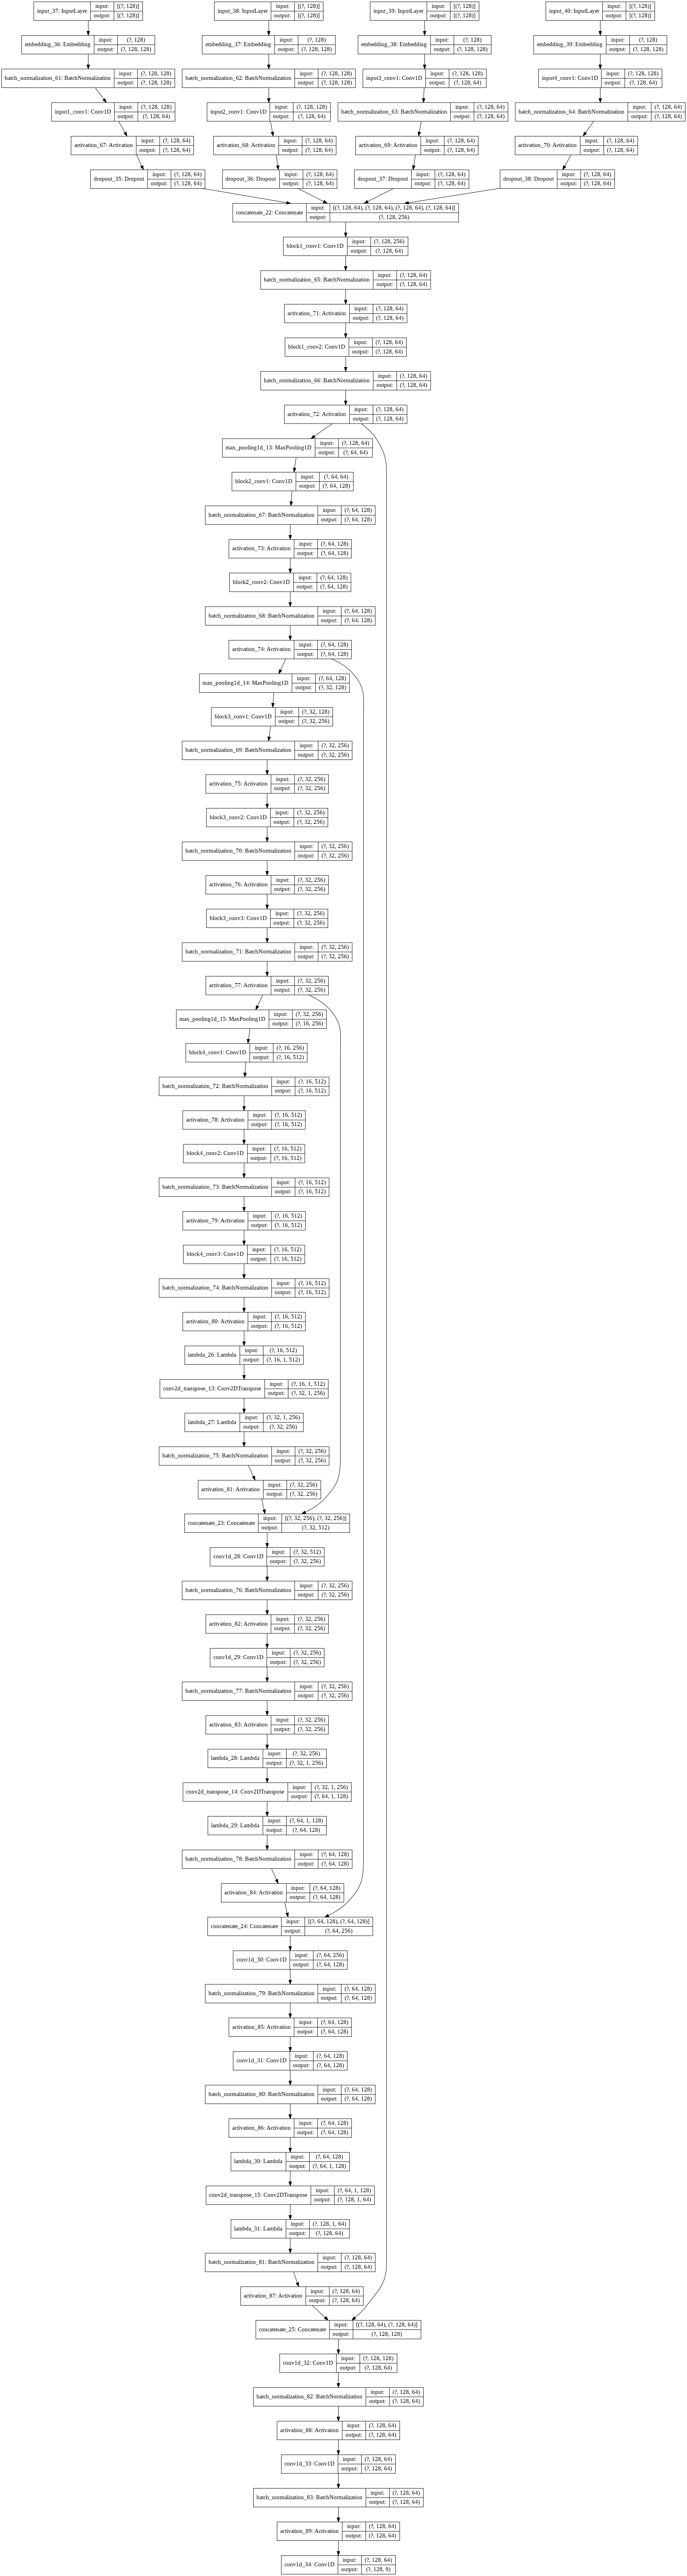

In [217]:
modelUnet_par = unet_par(colors_count, sent_len, num_words, 'softmax', emb_size) # Создаем модель unet
plot_model(modelUnet_par, show_shapes=True)

In [ ]:
historyUnet_par = modelUnet_par.fit(x=[Xtrain_pos, Xtrain_case, Xtrain_lang, Xtrain_norms], y=Ytrain, 
                            epochs=100, batch_size=64,
                            validation_data=([Xtest_pos, Xtest_case, Xtest_lang, Xtest_norms], Ytest))                    
modelUnet.save( '/content/drive/My Drive/tmp/modelUnet_parallel(production).h5' )

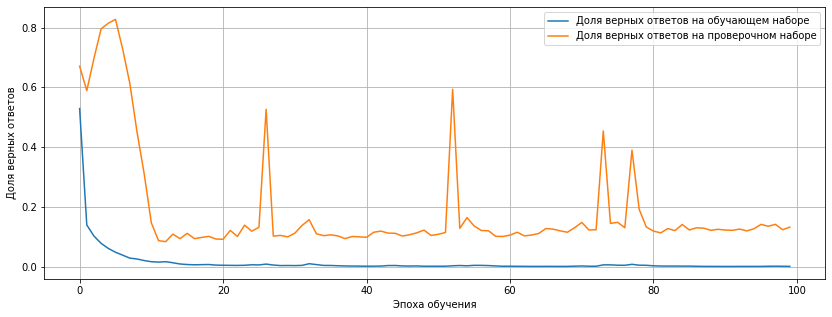

In [219]:
# Отобразим график обучения модели
plt.figure(figsize=(14, 5))
plt.plot(historyUnet_par.history['loss'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(historyUnet_par.history['val_loss'], 
         label='Доля верных ответов на проверочном наборе')
plt.grid(True)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [220]:
YpredUnet_par = modelUnet_par.predict([Xtest_pos, Xtest_case, Xtest_lang, Xtest_norms])
YpredUnet_par, Ytest_res_par, paragraphs_test_res_par = cleansed_data(YpredUnet_par, Ytest, paragraphs_test_2) # нехорошие данные здесь всё-таки подчищаем

Очищено фраз: 30


In [221]:
# Встроенная функция sklearn возвращает и точность и полноту по классам
print(classification_report(Ytest_res_par.argmax(axis=-1).flatten(), 
                            YpredUnet_par.argmax(axis=-1).flatten(), 
                            target_names=list(tag_tokenizer.index_word.values())))  

                   precision    recall  f1-score   support

                o       0.99      0.99      0.99     44756
           термин       0.89      0.94      0.91       777
           связка       0.93      0.94      0.94       557
      определение       0.92      0.88      0.90      1692
      расшифровка       0.83      0.88      0.85      2042
     дубль-термин       0.81      0.69      0.74       188
     дубль-связка       0.64      0.32      0.43        65
дубль-определение       0.55      0.35      0.43       147
дубль-расшифровка       0.08      0.01      0.02        80

         accuracy                           0.98     50304
        macro avg       0.74      0.67      0.69     50304
     weighted avg       0.98      0.98      0.98     50304



**Проверка тестовой выборки (насколько хорошо обучена сеть)**

In [222]:
# выбираем конкретную фразу из тестовой выборки
i = 2
print(f'{i + 1}.')
print(colorize_the_text(paragraphs_test_res_par[i], Ytest_res_par[i], 0, 'pre', sent_len))
print(colorize_the_text(paragraphs_test_res_par[i], YpredUnet_par[i], 0, 'pre', sent_len))

3.
 Ветвление — однократное выполнение одной из двух или более операций , в зависимости от выполнения заданного условия .
 Ветвление — однократное выполнение одной из двух или более операций , в зависимости от выполнения заданного условия .


In [223]:
# воспроизводим все фразы из тестовой выборки
for i, el in enumerate(paragraphs_test_res_par):
  print(f'{i+1}.')
  print(colorize_the_text(el, Ytest_res_par[i], 0, 'pre', sent_len))
  print(colorize_the_text(el, YpredUnet_par[i], 0, 'pre', sent_len))

# На github не отображается расцветка текста
# Чтобы её посмотреть, воспользуйтесь ссылкой на https://colab.research.google.com/ выше

1.
 Свойство — необходимое условие принадлежности классу .
 Свойство — необходимое условие принадлежности классу .
2.
 Парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее понятие .
 Парадигма программирования как исходная концептуальная схема постановки проблем и их решения является инструментом грамматического описания фактов , событий , явлений и процессов , возможно , не существующих одновременно , но интуитивно объединяемых в общее понятие .
3.
 Ветвление — однократное выполнение одной из двух или более операций , в зависимости от выполнения заданного условия .
 Ветвление — однократное выполнение одной из двух или более операций , в зависимости от выполнения заданного условия .
4.
 Локальные переменные – это переменные , объявленные внутри любого блока программы .
 Локальные пере

# **Checking the neural network model with new data**

## Input data

In [ ]:
# Читаем файл
fileName = '/content/drive/My Drive/Базы/NLP/any_text.txt'
f = open(fileName, 'r') #Открываем наш файл для чтения и считываем из него данные 
text = f.read() #Записываем прочитанный текст в переменную 
text

In [ ]:
text = re.sub(r'\n\n',  r'\n', text)
text = re.sub(r'\n\n',  r'\n', text)
text = re.sub(r'(\n)([А-Я])',  r'. \2', text)
text = re.sub(r'\n',  r' ', text)
text = text.replace('..',  '.')
text

In [ ]:
txt_list = sent_tokenize(text, language="russian")
txt_list

In [ ]:
len(txt_list)

In [ ]:
paragraphs_work = []
max_work_paragraph_len = 0
for elem in txt_list: 
  lexems = word_tokenize(elem, language="russian")
  paragraph_length = len(lexems)
  max_work_paragraph_len = paragraph_length if paragraph_length>max_work_paragraph_len else max_work_paragraph_len
  if paragraph_length>3 and paragraph_length<129:
    paragraphs_work.append(lexems) 
  print(lexems)
work_paragraphs_amount = len(paragraphs_work)
print('work_paragraphs_amount',work_paragraphs_amount, 'max_work_paragraph_len',max_work_paragraph_len)

In [ ]:
morph_work = []
for i, elem in enumerate(paragraphs_work):
  row = []
  for j,lexem in enumerate(elem):
    row.append(morphyus(lexem))
  morph_work.append(row)
  print(f'{i+1} done {j+1}!')
len(morph_work)

In [333]:
# Составим массив нормальных форм слов параллельный массиву paragraphs_work
# Составим массив частей речи параллельный массиву paragraphs_work
# Составим массив падежей слов параллельный массиву paragraphs_work
# Составим массив языковой принадлежности слов параллельный массиву paragraphs_work
norms_work = []
pos_work = []
case_work = []
lang_work = []
for i, elem in enumerate(morph_work):
  norms_sentence = []
  pos_sentence = []
  case_sentence = []
  lang_sentence = []
  for j,lexem in enumerate(elem):
    len_descr = len(lexem)
    lang_sentence.append(lexem[0])
    norms_sentence.append(lexem[2])
    # собрать все части речи у лексемы
    pos = set()
    for k in range(3, len_descr,13):
      pos.add(lexem[k])
    pos_sentence.append("".join(list(pos)))
    # собрать у лексемы все падежи и 
    # признаки формы глагола, причастия, деепричастия - GRND, PRTS, PRTF, INFN, VERB
    case = set()
    if lexem[3] in ['GRND', 'PRTS', 'PRTF', 'INFN', 'VERB']:
      for k in range(4, len_descr,13):
        for m in range(k, k+11):
          case.add(lexem[m] if not lexem[m] in ['None'] else '')
    else: 
      for k in range(6, len_descr,13):
        case.add(lexem[k])
    case_sentence.append("".join(list(case)))
  norms_work.append(norms_sentence)  
  pos_work.append(pos_sentence)
  case_work.append(case_sentence)
  lang_work.append(lang_sentence)

In [ ]:
norms_work[0]

In [ ]:
pos_work[0]

In [ ]:
case_work[0]

In [ ]:
lang_work[0]

## Dataset

Соберём входные данные в один массив

In [334]:
full_work_pcln = pos_work + case_work + lang_work + norms_work
full_work_pcln_together = [' '.join(sequence) for sequence in full_work_pcln]

Токенизируем входные данные. 

In [335]:
wX = tokenizer.texts_to_sequences(full_work_pcln_together)

Теперь разобъём wX на входные массивы по типам данных: pos, cases, lang и norms

In [336]:
L = work_paragraphs_amount
M = 2*L
N = M+L
wX_pos = wX[:L]
wX_case = wX[L:M]
wX_lang = wX[M:N]
wX_norms = wX[N:]

In [ ]:
# wX_pos[0]

In [ ]:
# wX_case[0]

In [ ]:
# wX_lang[0]

In [ ]:
# wX_norms[0]

Выравнивание массивов до максимального размера абзаца

In [337]:
wX_pos = pad_sequences(wX_pos, sent_len, padding='pre', truncating='post')  # заполнение в начале и обрезка с конца предложения
wX_case = pad_sequences(wX_case, sent_len, padding='pre', truncating='post')
wX_lang = pad_sequences(wX_lang, sent_len, padding='pre', truncating='post')
wX_norms = pad_sequences(wX_norms, sent_len, padding='pre', truncating='post')

Сводная информация по подготовленным массивам

In [ ]:
print('wX_pos.shape=',wX_pos.shape)
print('wX_case.shape=',wX_case.shape)
print('wX_lang.shape=',wX_lang.shape)
print('wX_norms.shape=',wX_norms.shape)

## Segmentation

Подключаемся к нейросетевой модели

In [ ]:
# # параллельная архитектура
# input_pos = Input((sent_len,))
# x_pos = Embedding(num_words, emb_size)(input_pos)
# x_pos = BatchNormalization()(x_pos)
# x_pos = Bidirectional(GRU(emb_size, return_sequences=True))(x_pos)
# x_pos = Activation('relu')(x_pos)
# x_pos = Dropout(0.2)(x_pos)

# input_case = Input((sent_len,))
# x_case = Embedding(num_words, emb_size)(input_case)
# x_case = BatchNormalization()(x_case)
# x_case = Bidirectional(GRU(emb_size, return_sequences=True))(x_case)
# x_case = Activation('relu')(x_case)
# x_case = Dropout(0.2)(x_case)

# input_lang = Input((sent_len,))
# x_lang = Embedding(num_words, emb_size)(input_lang)
# x_lang = Bidirectional(GRU(emb_size, return_sequences=True))(x_lang)
# x_lang = BatchNormalization()(x_lang)
# x_lang = Activation('relu')(x_lang)
# x_lang = Dropout(0.2)(x_lang)

# input_norms = Input((sent_len,))
# x_norms = Embedding(num_words, emb_size)(input_norms)
# x_norms = Bidirectional(GRU(emb_size, return_sequences=True))(x_norms)
# x_norms = BatchNormalization()(x_norms)
# x_norms = Activation('relu')(x_norms)
# x_norms = Dropout(0.2)(x_norms)

# x = concatenate([x_pos, x_case, x_lang, x_norms])

# x = GRU(emb_size, return_sequences=True)(x)
# x = Dense(100, activation='relu')(x)
# x = Dropout(0.2)(x)

# output = Dense(colors_count, activation='softmax')(x)

# modelEGRUpar = Model(inputs=[input_pos, input_case, input_lang, input_norms], outputs=output)

# modelEGRUpar.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[dice_coef])

In [274]:
model_cur = load_model('/content/drive/My Drive/tmp/modelL_consistent(production).h5')

In [ ]:
Ypred_cur = model_cur.predict([wX_pos, wX_case, wX_lang, wX_norms])
Ypred_cur_res, paragraphs_work_res = cleansed_work_data(Ypred_cur, paragraphs_work) # подчищаем нехорошие данные

1. **Статья по Python**

In [340]:
# воспроизводим все фразы из тестовой выборки
for i, el in enumerate(paragraphs_work_res):
  print(f'{i+1}.')
  print(colorize_the_text(el, Ypred_cur_res[i], 0, 'pre', sent_len))

1.
 В результате , x – это лишь ссылка на текущий элемент списка и , как мы уже говорили , если попытаться изменить значение коллекции через x , то ничего не произойдет , т.к. мы лишь изменим саму ссылку x. Если же внутри цикла требуется не только перебирать элементы , но и менять их , то необходимо обращаться к текущему элементу по его индексу , например , так : i = 0 for x in a : if x % 2 == 0 : a [ i ] += 1 i += 1 print ( a ) .
2.
 Здесь sequence – это любой итерируемый объект ; start – начальное значение индекса .
3.
 Смотрите , если просто взять и вызвать эту функцию , а затем , результат вывести в консоль : g = enumerate ( a ) print ( g ) то увидим сообщение : < enumerate object at 0x01B5F628 > .
4.
 Никакого кортежа здесь нет , g – это итерируемый объект , то есть , объект-итератор , который можно перебирать с помощью функции next : print ( next ( g ) ) .


2. **Статья по регулярным выражениям**

In [325]:
# воспроизводим все фразы из тестовой выборки
for i, el in enumerate(paragraphs_work_res):
  print(f'{i+1}.')
  print(colorize_the_text(el, Ypred_cur_res[i], 0, 'pre', sent_len))

1.
 Регулярные выражения – это небольшой язык , который вы можете использовать внутри Python и многих других языках программирования .
2.
 Основное использование регулярных выражений – это сопоставление строк .
3.
 Обратите внимание на то , что Python – идеальный язык для парсинга текстов согласно его правам , и его можно использовать во всем , что вы делаете с регулярными выражениями .
4.
 Основная связка метасимволов , с которой вы будете сталкиваться , это квадратные скобки : [ и ] .
5.
 Они используются для создания « класса символов » , который является набором символов , которые вы можете сопоставить .
6.
 Последний повторяемый метасимвол это { a , b } , где а и b являются десятичными целыми числами .


3. **Статья по ООП в Python**

In [309]:
# воспроизводим все фразы из тестовой выборки
for i, el in enumerate(paragraphs_work_res):
  print(f'{i+1}.')
  print(colorize_the_text(el, Ypred_cur_res[i], 0, 'pre', sent_len))

1.
 Сразу следует отметить , что ООП – это совершенно другая парадигма программирования , нежели структурное программирование , основу которого в основном образует функциональное программирование .
2.
 Это первый столп ( наследование ) , на котором базируется ООП .
3.
 Это называется полиморфизмом в ООП .
4.
 Это второй столп ООП – полиморфизм .
5.
 Инкапсуляция – это возможность закрывать данные и методы класса от внешнего вмешательства .
6.
 Вот так в целом можно представить себе три основные концепции , лежащие в основе парадигмы ООП : инкапсуляция ; наследование ; полиморфизм .
7.
 Вот также следует воспринимать класс – это схема для построения однотипных экземпляров данного класса .
8.
 И мы впоследствии можем вывести это описание с помощью предопределенного свойства __doc__ : print ( Point.__doc__ ) .
9.
 В терминологии ООП языка Python переменные x , y внутри класса Point или его экземпляров называются атрибутами ( или свойствами ) .
10.
 С атрибутами экземпляров класса можно ра

4. **Статья по бухгалтерской тематике**

In [290]:
# воспроизводим все фразы из тестовой выборки
for i, el in enumerate(paragraphs_work_res):
  print(f'{i+1}.')
  print(colorize_the_text(el, Ypred_cur_res[i], 0, 'pre', sent_len))

1.
 В современном мире , где структура бухгалтерского баланса компаний на 75-80 % состоит из нематериальных активов , можно сказать , что текущее состояние бухгалтерского учета не удовлетворяет потребностям внешних пользователей информации о компаниях для принятия долгосрочных решений .
2.
 Нематериальные активы представляют собой неосязаемые и не имеющие физической формы активы , являющиеся для организации материальной ценностью .


5. **Выдержка из государственного нормативного документа**

In [276]:
# воспроизводим все фразы из тестовой выборки
for i, el in enumerate(paragraphs_work_res):
  print(f'{i+1}.')
  print(colorize_the_text(el, Ypred_cur_res[i], 0, 'pre', sent_len))

1.
 Настоящие Правила устанавливают порядок обеспечения организаторами официальных спортивных соревнований ( далее - соревнования ) и собственниками ( пользователями ) объектов спорта общественного порядка и общественной безопасности при проведении соревнований .
2.
 Требования , предусмотренные подпунктом `` ж '' пункта 8 настоящих Правил , применяются только при проведении соревнований по таким видам спорта , как `` баскетбол '' , `` волейбол '' , `` регби '' , `` футбол '' и `` хоккей '' , а также по спортивным единоборствам .
3.
 Инструкция разрабатывается собственниками ( пользователями ) объектов спорта на основе типовой инструкции , утвержденной федеральным органом исполнительной власти в области физической культуры и спорта , согласовывается с территориальными органами безопасности и территориальными органами Министерства внутренних дел Российской Федерации на районном уровне и утверждается собственниками ( пользователями ) объектов спорта не реже одного раза в 3 года .
4.
 Пла

6. **Статья по культуре**

In [258]:
# воспроизводим все фразы из тестовой выборки
for i, el in enumerate(paragraphs_work_res):
  print(f'{i+1}.')
  print(colorize_the_text(el, Ypred_cur_res[i], 0, 'pre', sent_len))

1.
 Ирина Пегова - актриса нарасхват .
2.
 В сентябре начались съемки продолжения `` Акушерки '' в Минске .
3.
 Уже в театральном училище понимала , что я - характерная артистка .
4.
 Однажды ей позвонила девочка , чей папа - директор музея , которого играет Михаил Пореченков , оказался за решеткой.. Совсем недавно показали фильм `` От печали до радости '' , где вы играете с целой династией Добронравовых - Федором , Виктором и Иваном .
5.
 Двадцать восьмой кинофестиваль `` Окно в Европу '' , который проходит в эти дни в Выборге , 13 декабря закроется фильмом `` Зоя '' с вашим участием .
6.
 Съемки проходили в деревне Забродье Вилейского района Беларуси - там удалось отыскать довоенные деревянные постройки .
7.
 Папа - спортивный тренер , мама - работница Выксинского металлургического комбината .


7. **Статья по радиофизике**

In [242]:
# воспроизводим все фразы из тестовой выборки
for i, el in enumerate(paragraphs_work_res):
  print(f'{i+1}.')
  print(colorize_the_text(el, Ypred_cur_res[i], 0, 'pre', sent_len))

1.
 макс ⎟ ⎟ ⎠ ⎞ ⎜ ⎜ ⎝ ⎛ 2 2 L σ 3 .
2.
 Метод преобразования аналог-код : ПУ — поразрядное уравновешивание ; СИ — счетно-импульсный .
3.
 Метод кодирования : Х — код Хемминга с обнаружением двукратных и исправлением однократных ошибок , Ц — циклический код с обнаружением двукратных ошибок , ПИ — код с повторением и инверсией .
4.
 Вид модуляции сигналов в канале связи : 1 ) АМ — амплитудная модуляция ; 2 ) ЧМ — частотная модуляция ; 3 ) ЧМ ( ОБП ) — частотная модуляция ( одна боковая полоса ) .
5.
 Д – датчик аналоговых сигналов ; .
6.
 РК — коммутатор каналов ; .
7.
 АЦП — аналогово-цифровой преобразователь ; .
8.
 Кодер — преобразователь двоичного безизбыточного кода в код избыточный ; .
9.
 Декодер — устройство коррекции ошибок и выделения информационных символов ; .
10.
 ФП , РП — формирователь и различитель импульсного признака ; .
11.
 АС ПРД , АС ПРМ — аппаратура связи приемника и передатчика ; .
12.
 ЦИ — цифровая индикация ; .
13.
 П/П — преобразователь последовательного кода